# Run basic `scanpy` QC and doublet detection with `scrublet` for merged, post-`cellbender` `23-0092` dataset

- **Developed by**: Carlos Talavera-López PhD
- **Modified by** : Srivalli Kolla
- **Modification date** : 07 May, 2024
- **Würzburg Institute for Systems Immunology & Julius-Maximilian-Universität Würzburg**
- v230918

## Load required modules

In [1]:
import anndata
import logging
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sb
import scrublet as scr
import time
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import rcParams

In [59]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 160, color_map = 'RdPu', dpi_save = 180, vector_friendly = True, format = 'svg')
timestamp = time.strftime("%d_%m_%Y")

-----
anndata     0.10.5.post1
scanpy      1.9.8
-----
PIL                 10.2.0
annoy               NA
appnope             0.1.4
asttokens           NA
attr                23.2.0
attrs               23.2.0
cattr               NA
cattrs              NA
certifi             2024.02.02
cffi                1.16.0
charset_normalizer  3.3.2
comm                0.2.1
cycler              0.12.1
cython_runtime      NA
dateutil            2.8.2
debugpy             1.8.1
decorator           5.1.1
executing           2.0.1
future              1.0.0
h5py                3.10.0
idna                3.7
igraph              0.10.8
ipykernel           6.29.3
jedi                0.19.1
joblib              1.3.2
kiwisolver          1.4.5
lazy_loader         0.4
leidenalg           0.10.2
llvmlite            0.42.0
louvain             0.8.1
matplotlib          3.8.3
matplotlib_inline   0.1.6
mpl_toolkits        NA
natsort             8.4.0
numba               0.59.0
numpy               1.26.4
packaging    

In [3]:
path = '../data/'

## Read `anndata` objects

In [4]:
adata = sc.read_h5ad(path + 'heart_mm_nuclei-23-0092_CB_ctl231123.raw.h5ad')
adata

AnnData object with n_obs × n_vars = 188253 × 32285
    obs: 'sample', 'genotype', 'batch'
    var: 'gene_ids', 'feature_types', 'genome'

In [5]:
adata.obs

sample genotype batch
CTTCAATCAATAGTCC-1-A9_2-A9_2   A9_2       WT  A9_2
GATGCTAAGCAGTAAT-1-A9_2-A9_2   A9_2       WT  A9_2
GCTACCTAGGTTGGTG-1-A9_2-A9_2   A9_2       WT  A9_2
GATTCTTCACACCTTC-1-A9_2-A9_2   A9_2       WT  A9_2
TAAGCCACATGAGAAT-1-A9_2-A9_2   A9_2       WT  A9_2
...                             ...      ...   ...
CAGCAATAGAAGTCCG-1-B2_2-B2_2   B2_2  MdxSCID  B2_2
TTGATGGGTTCCGCTT-1-B2_2-B2_2   B2_2  MdxSCID  B2_2
CCTCCAATCCGATAAC-1-B2_2-B2_2   B2_2  MdxSCID  B2_2
GGGCTACTCGGAGTAG-1-B2_2-B2_2   B2_2  MdxSCID  B2_2
TCCTGCAGTTGTCCCT-1-B2_2-B2_2   B2_2  MdxSCID  B2_2

[188253 rows x 3 columns]

### Filtration

In [6]:
sc.pp.filter_cells(adata, min_genes = 200)
print(adata.n_obs, adata.n_vars)

filtered out 40733 cells that have less than 200 genes expressed
147520 32285


In [7]:
adata

AnnData object with n_obs × n_vars = 147520 × 32285
    obs: 'sample', 'genotype', 'batch', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome'

## Doublet score prediction

#### Steps followed

Make a loop to work on all the samples

1. List of samples
2. Subsetting samples based on sample_name
3. Doublet score calculation
4. Assign doublet scores to the sample
5. Plotting

In [8]:
sample_names = adata.obs['sample'].unique()

for sample_name in sample_names:
    mask = adata.obs['sample'] == sample_name
    sample_adata = adata[mask].copy()

    scrub = scr.Scrublet(sample_adata.X, expected_doublet_rate = 0.1)

    sample_adata.obs['doublet_scores'], sample_adata.obs['predicted_doublets'] = scrub.scrub_doublets()

    adata.obs.loc[mask, 'doublet_scores'] = sample_adata.obs['doublet_scores']
    adata.obs.loc[mask, 'predicted_doublets'] = sample_adata.obs['predicted_doublets']

    #scrub.plot_histogram()

    #plt.show()

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.71
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 1.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 3.0%
Elapsed time: 4.2 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.70
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.0%
Elapsed time: 85.6 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.15
Detected doublet rate = 12.4%
Estimated detectable doublet fraction = 68.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 18.2%
Elapsed time: 13.5 seconds
Preprocessing...
Simulating doub

In [9]:
adata.obs

sample genotype batch  n_genes  doublet_scores  \
CTTCAATCAATAGTCC-1-A9_2-A9_2   A9_2       WT  A9_2     6363        0.048159   
GATGCTAAGCAGTAAT-1-A9_2-A9_2   A9_2       WT  A9_2     6638        0.407407   
GCTACCTAGGTTGGTG-1-A9_2-A9_2   A9_2       WT  A9_2     5794        0.115207   
GATTCTTCACACCTTC-1-A9_2-A9_2   A9_2       WT  A9_2     5740        0.240106   
TAAGCCACATGAGAAT-1-A9_2-A9_2   A9_2       WT  A9_2     5005        0.048159   
...                             ...      ...   ...      ...             ...   
TCAGTTTAGGGAACAA-1-B2_2-B2_2   B2_2  MdxSCID  B2_2      254        0.146637   
GCAACCGTCTAACGCA-1-B2_2-B2_2   B2_2  MdxSCID  B2_2      209        0.200000   
AGAGAGCGTCGCAGTC-1-B2_2-B2_2   B2_2  MdxSCID  B2_2      286        0.269841   
GTCAAACCATTGACAC-1-B2_2-B2_2   B2_2  MdxSCID  B2_2      219        0.122807   
GATTTCTTCGCAGTGC-1-B2_2-B2_2   B2_2  MdxSCID  B2_2      216        0.090617   

                             predicted_doublets  
CTTCAATCAATAGTCC-1-A9_2-A9_2              False  
GATGCTAAGCAGTAAT-1-A9_2-A9_2              False  
GCTACCTAGGTTGGTG-1-A9_2-A9_2              False  
GATTCTTCACACCTTC-1-A9_2-A9_2              False  
TAAGCCACATGAGAAT-1-A9_2-A9_2              False  
...                                         ...  
TCAGTTTAGGGAACAA-1-B2_2-B2_2              False  
GCAACCGTCTAACGCA-1-B2_2-B2_2              False  
AGAGAGCGTCGCAGTC-1-B2_2-B2_2              False  
GTCAAACCATTGACAC-1-B2_2-B2_2              False  
GATTTCTTCGCAGTGC-1-B2_2-B2_2              False  

[147520 rows x 6 columns]

### Checking the count and percentage of Doublets - Anndata level

In [10]:
doub_tab = pd.crosstab(adata.obs['sample'],adata.obs['predicted_doublets'])
doub_tab.sum()

predicted_doublets
False    144619
True       2901
dtype: int64

In [11]:
true_doublets = adata.obs['predicted_doublets'] == True
true_doublets_count = true_doublets.sum()

true_doublets_percentage = (true_doublets_count / len(adata.obs)) * 100

true_doublets_count ,true_doublets_percentage

(2901, 1.9665130151843817)

### Checking the count of Doublets - Sample level

In [12]:
doublet_counts_per_sample = adata.obs.groupby(['sample', 'genotype'])['predicted_doublets'].sum()

print(doublet_counts_per_sample)

sample  genotype
A10_2   Mdx            0
        MdxSCID        0
        WT             0
A11_2   Mdx         1703
        MdxSCID        0
        WT             0
A12_2   Mdx         1196
        MdxSCID        0
        WT             0
A9_2    Mdx            0
        MdxSCID        0
        WT             2
B1_2    Mdx            0
        MdxSCID        0
        WT             0
B2_2    Mdx            0
        MdxSCID        0
        WT             0
Name: predicted_doublets, dtype: object


/var/folders/m6/j4jl72rj0pl7_bbwngtxl9ym0000gn/T/ipykernel_55926/646260872.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  doublet_counts_per_sample = adata.obs.groupby(['sample', 'genotype'])['predicted_doublets'].sum()


([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'A10_2'),
  Text(1, 0, 'A11_2'),
  Text(2, 0, 'A12_2'),
  Text(3, 0, 'A9_2'),
  Text(4, 0, 'B1_2'),
  Text(5, 0, 'B2_2')])

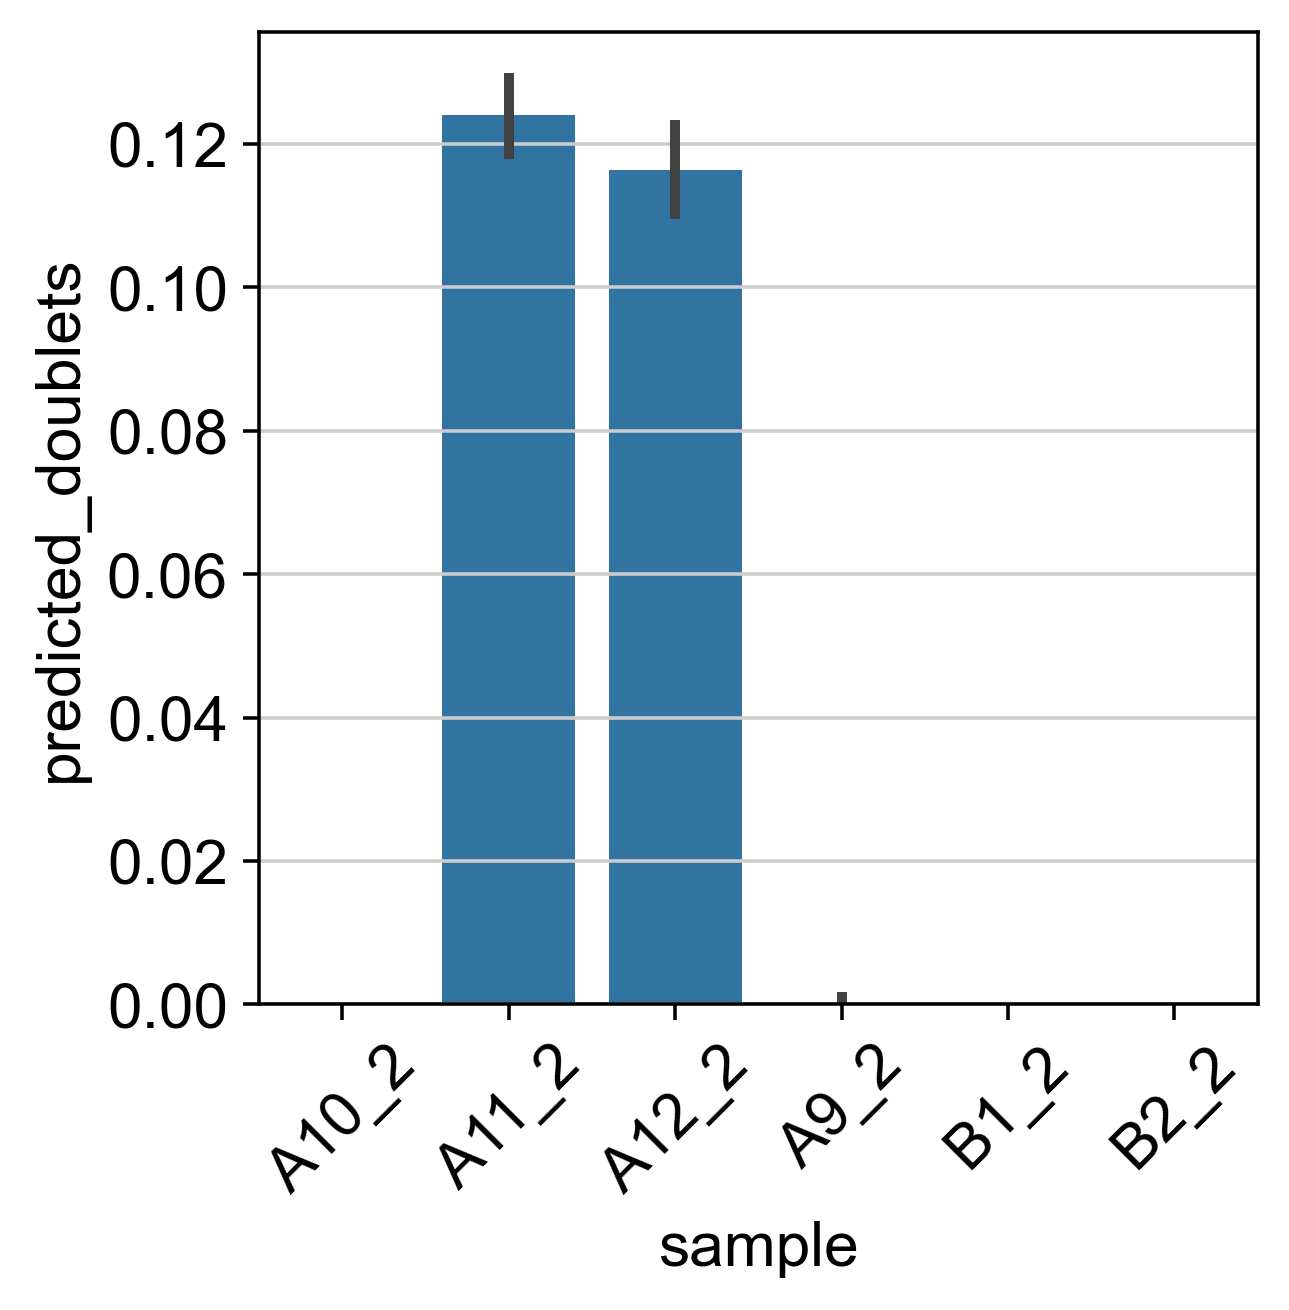

In [13]:
sb.barplot(x=adata.obs['sample'], y=adata.obs['predicted_doublets'])
plt.xticks(rotation = 45)

### Saving raw data

In [14]:
sample_object = adata.copy()
sample_object

AnnData object with n_obs × n_vars = 147520 × 32285
    obs: 'sample', 'genotype', 'batch', 'n_genes', 'doublet_scores', 'predicted_doublets'
    var: 'gene_ids', 'feature_types', 'genome'

## Compute QC stats

In [15]:
sample_object.shape

(147520, 32285)

### Labelling Mt and Ribo genes

In [16]:
sample_object.var['mt'] = sample_object.var_names.str.startswith('mt-') 
sample_object.var['ribo'] = sample_object.var_names.str.startswith(("Rps","Rpl"))
sample_object.var

gene_ids    feature_types genome     mt   ribo
Xkr4        ENSMUSG00000051951  Gene Expression     NA  False  False
Gm1992      ENSMUSG00000089699  Gene Expression     NA  False  False
Gm19938     ENSMUSG00000102331  Gene Expression     NA  False  False
Gm37381     ENSMUSG00000102343  Gene Expression     NA  False  False
Rp1         ENSMUSG00000025900  Gene Expression     NA  False  False
...                        ...              ...    ...    ...    ...
AC124606.1  ENSMUSG00000095523  Gene Expression     NA  False  False
AC133095.2  ENSMUSG00000095475  Gene Expression     NA  False  False
AC133095.1  ENSMUSG00000094855  Gene Expression     NA  False  False
AC234645.1  ENSMUSG00000095019  Gene Expression     NA  False  False
AC149090.1  ENSMUSG00000095041  Gene Expression     NA  False  False

[32285 rows x 5 columns]

In [17]:
ribo_counts = sample_object.var['ribo'].value_counts()

mt_counts = sample_object.var['mt'].value_counts()

print("Counts of Ribosomal (ribo) Genes:")
print("False:", ribo_counts.get(False, 0))
print("True:", ribo_counts.get(True, 0))
print("\nCounts of Mitochondrial (mt) Genes:")
print("False:", mt_counts.get(False, 0))
print("True:", mt_counts.get(True, 0))

Counts of Ribosomal (ribo) Genes:
False: 32184
True: 101

Counts of Mitochondrial (mt) Genes:
False: 32272
True: 13


### Calculating QC metrics per cell

In [18]:
sc.pp.calculate_qc_metrics(sample_object, qc_vars = ['mt','ribo'], percent_top = None, log1p = False, inplace = True)

In [19]:
sample_object

AnnData object with n_obs × n_vars = 147520 × 32285
    obs: 'sample', 'genotype', 'batch', 'n_genes', 'doublet_scores', 'predicted_doublets', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

#### Steps followed

1. Seperating Mt genes
2. Calculating Mt gene percentage
3. Realculating n_counts

In [20]:
mito_genes = sample_object.var_names.str.startswith('mt-')

sample_object.obs['percent_mt2'] = np.sum(
    sample_object[:, mito_genes].X, axis = 1) / np.sum(sample_object.X, axis = 1)

sample_object.obs['n_counts_per_cell'] = sample_object.X.sum(axis = 1)

In [21]:
sample_object

AnnData object with n_obs × n_vars = 147520 × 32285
    obs: 'sample', 'genotype', 'batch', 'n_genes', 'doublet_scores', 'predicted_doublets', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts_per_cell'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

### Visualization of qc metrics

([0, 1], [Text(0, 0, 'pct_counts_mt'), Text(1, 0, 'pct_counts_ribo')])

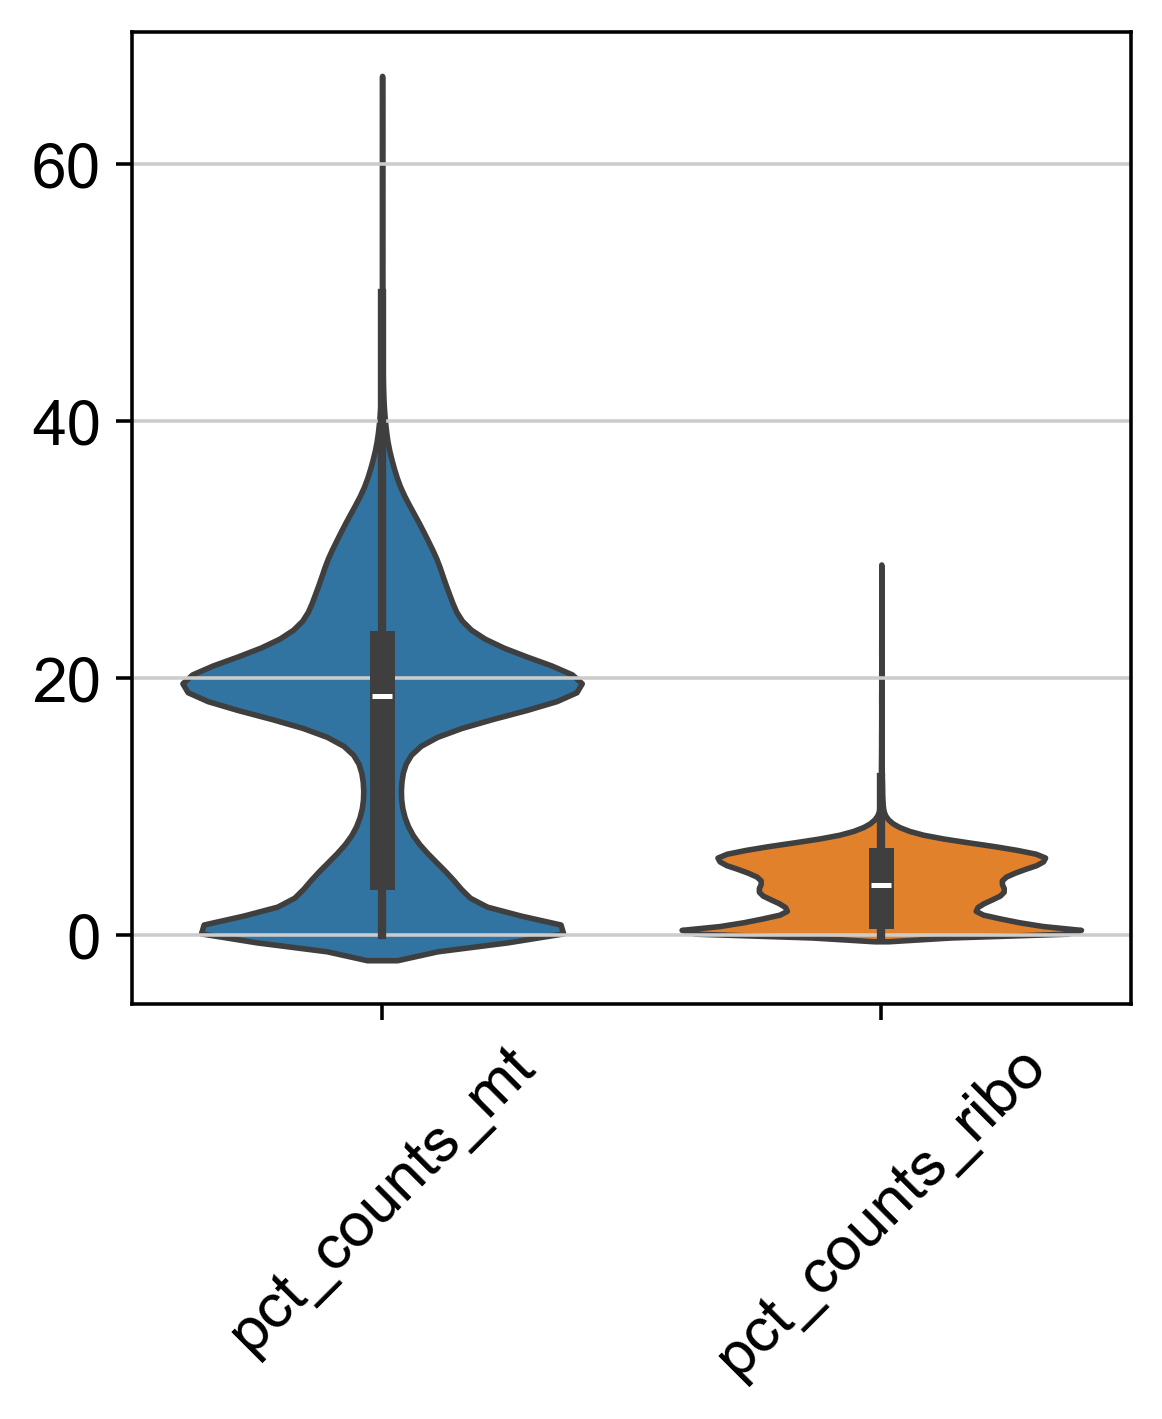

In [22]:
variables = ['pct_counts_mt', 'pct_counts_ribo']

sb.violinplot(data=sample_object.obs[variables])

plt.xticks(rotation=45)

##### *Description of violin plots*

**Violin Body**: The central part of the violin plot represents the probability density of the data.

**Box Plot**:
        Median (White line inside the box) Q2 ;
        Quartiles (the edges of the box) Q1,Q3 - Height of box represent Interquartile region (Q1-Q2-Q3) ;
        Outliers (points beyond the whiskers)

**Whiskers**: The whiskers extend from the box to the minimum and maximum values within 1.5 times the IQR from the first and third quartiles

**Outliers**: Individual data points beyond the whiskers

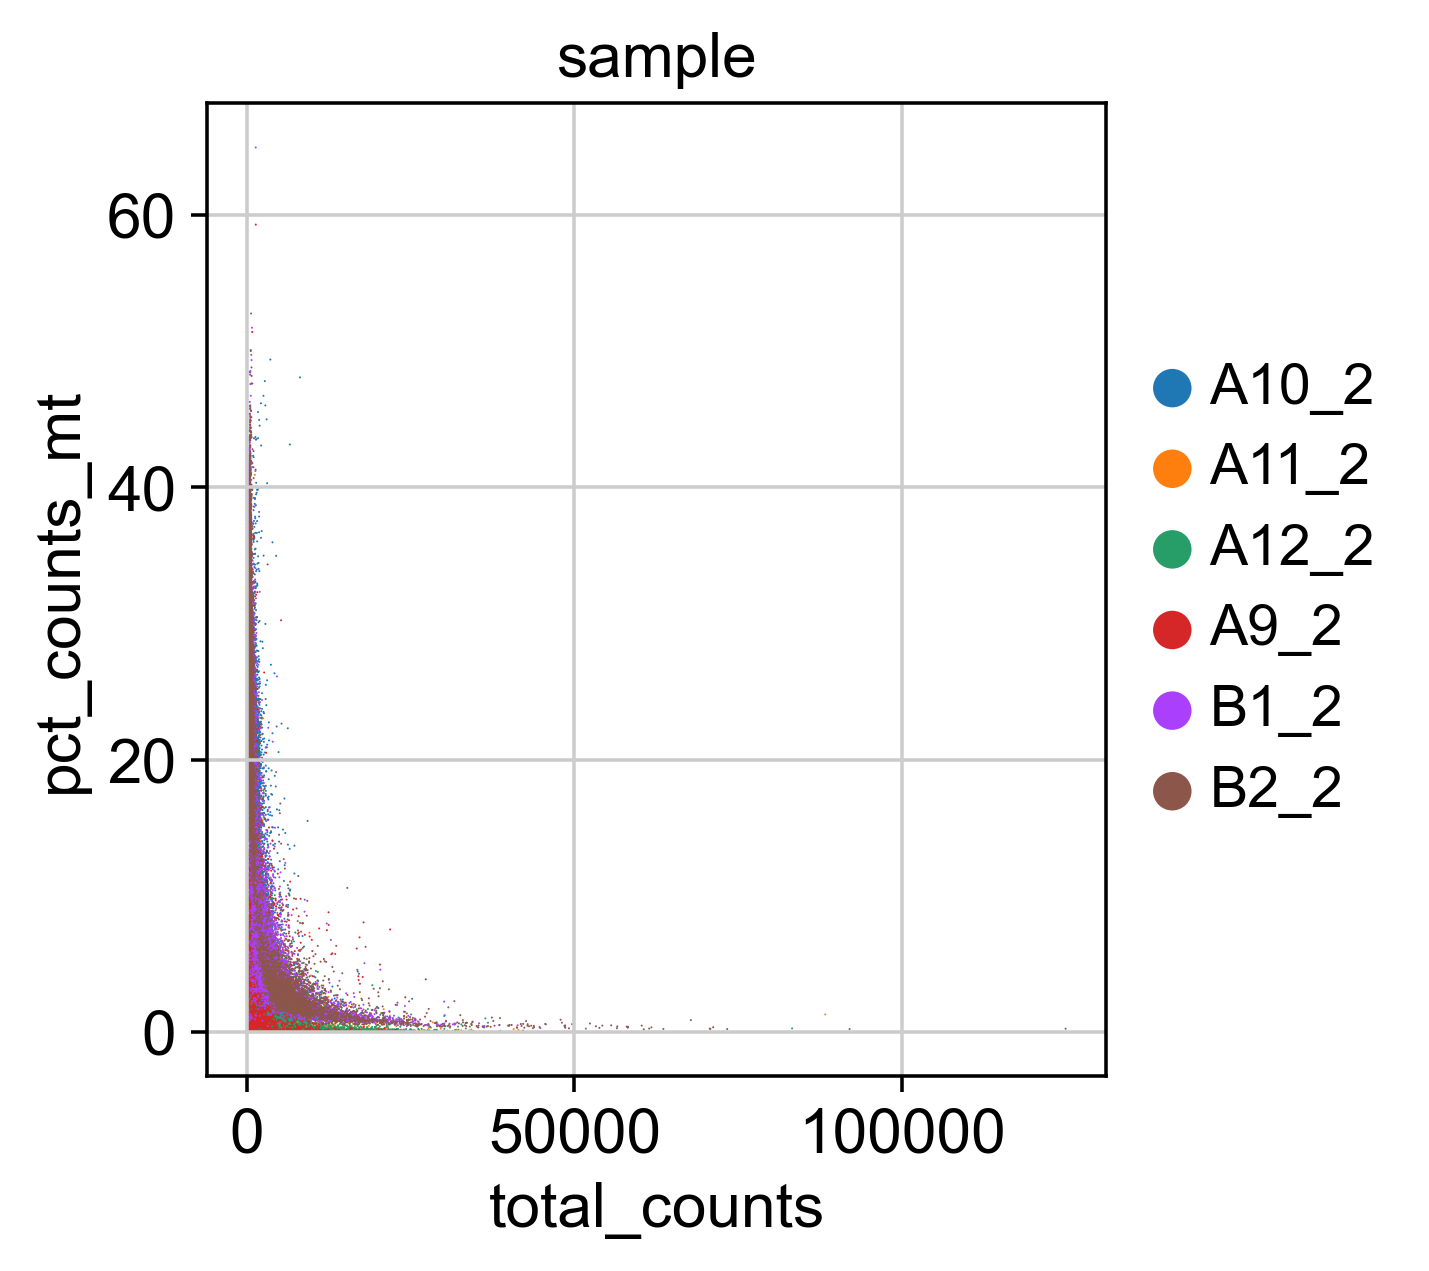

In [23]:
sc.pl.scatter(sample_object, x = 'total_counts', y = 'pct_counts_mt', color = "sample")

In [24]:
sample_object.obs

sample genotype batch  n_genes  doublet_scores  \
CTTCAATCAATAGTCC-1-A9_2-A9_2   A9_2       WT  A9_2     6363        0.048159   
GATGCTAAGCAGTAAT-1-A9_2-A9_2   A9_2       WT  A9_2     6638        0.407407   
GCTACCTAGGTTGGTG-1-A9_2-A9_2   A9_2       WT  A9_2     5794        0.115207   
GATTCTTCACACCTTC-1-A9_2-A9_2   A9_2       WT  A9_2     5740        0.240106   
TAAGCCACATGAGAAT-1-A9_2-A9_2   A9_2       WT  A9_2     5005        0.048159   
...                             ...      ...   ...      ...             ...   
TCAGTTTAGGGAACAA-1-B2_2-B2_2   B2_2  MdxSCID  B2_2      254        0.146637   
GCAACCGTCTAACGCA-1-B2_2-B2_2   B2_2  MdxSCID  B2_2      209        0.200000   
AGAGAGCGTCGCAGTC-1-B2_2-B2_2   B2_2  MdxSCID  B2_2      286        0.269841   
GTCAAACCATTGACAC-1-B2_2-B2_2   B2_2  MdxSCID  B2_2      219        0.122807   
GATTTCTTCGCAGTGC-1-B2_2-B2_2   B2_2  MdxSCID  B2_2      216        0.090617   

                             predicted_doublets  n_genes_by_counts  \
CTTCAATCAATAGTCC-1-A9_2-A9_2              False               6363   
GATGCTAAGCAGTAAT-1-A9_2-A9_2              False               6638   
GCTACCTAGGTTGGTG-1-A9_2-A9_2              False               5794   
GATTCTTCACACCTTC-1-A9_2-A9_2              False               5740   
TAAGCCACATGAGAAT-1-A9_2-A9_2              False               5005   
...                                         ...                ...   
TCAGTTTAGGGAACAA-1-B2_2-B2_2              False                254   
GCAACCGTCTAACGCA-1-B2_2-B2_2              False                209   
AGAGAGCGTCGCAGTC-1-B2_2-B2_2              False                286   
GTCAAACCATTGACAC-1-B2_2-B2_2              False                219   
GATTTCTTCGCAGTGC-1-B2_2-B2_2              False                216   

                              total_counts  total_counts_mt  pct_counts_mt  \
CTTCAATCAATAGTCC-1-A9_2-A9_2       42171.0             41.0       0.097223   
GATGCTAAGCAGTAAT-1-A9_2-A9_2       27328.0           1056.0       3.864169   
GCTACCTAGGTTGGTG-1-A9_2-A9_2       26030.0            103.0       0.395697   
GATTCTTCACACCTTC-1-A9_2-A9_2       24212.0            615.0       2.540063   
TAAGCCACATGAGAAT-1-A9_2-A9_2       22787.0             37.0       0.162373   
...                                    ...              ...            ...   
TCAGTTTAGGGAACAA-1-B2_2-B2_2         293.0             29.0       9.897611   
GCAACCGTCTAACGCA-1-B2_2-B2_2         242.0             27.0      11.157025   
AGAGAGCGTCGCAGTC-1-B2_2-B2_2         326.0              0.0       0.000000   
GTCAAACCATTGACAC-1-B2_2-B2_2         274.0             22.0       8.029197   
GATTTCTTCGCAGTGC-1-B2_2-B2_2         285.0             11.0       3.859649   

                              total_counts_ribo  pct_counts_ribo  percent_mt2  \
CTTCAATCAATAGTCC-1-A9_2-A9_2               47.0         0.111451     0.000972   
GATGCTAAGCAGTAAT-1-A9_2-A9_2              397.0         1.452722     0.038642   
GCTACCTAGGTTGGTG-1-A9_2-A9_2               90.0         0.345755     0.003957   
GATTCTTCACACCTTC-1-A9_2-A9_2              223.0         0.921031     0.025401   
TAAGCCACATGAGAAT-1-A9_2-A9_2               22.0         0.096546     0.001624   
...                                         ...              ...          ...   
TCAGTTTAGGGAACAA-1-B2_2-B2_2                0.0         0.000000     0.098976   
GCAACCGTCTAACGCA-1-B2_2-B2_2                2.0         0.826446     0.111570   
AGAGAGCGTCGCAGTC-1-B2_2-B2_2                0.0         0.000000     0.000000   
GTCAAACCATTGACAC-1-B2_2-B2_2                0.0         0.000000     0.080292   
GATTTCTTCGCAGTGC-1-B2_2-B2_2                2.0         0.701754     0.038596   

                              n_counts_per_cell  
CTTCAATCAATAGTCC-1-A9_2-A9_2            42171.0  
GATGCTAAGCAGTAAT-1-A9_2-A9_2            27328.0  
GCTACCTAGGTTGGTG-1-A9_2-A9_2            26030.0  
GATTCTTCACACCTTC-1-A9_2-A9_2            24212.0  
TAAGCCACATGAGAAT-1-A9_2-A9_2            22787.0  
...                          

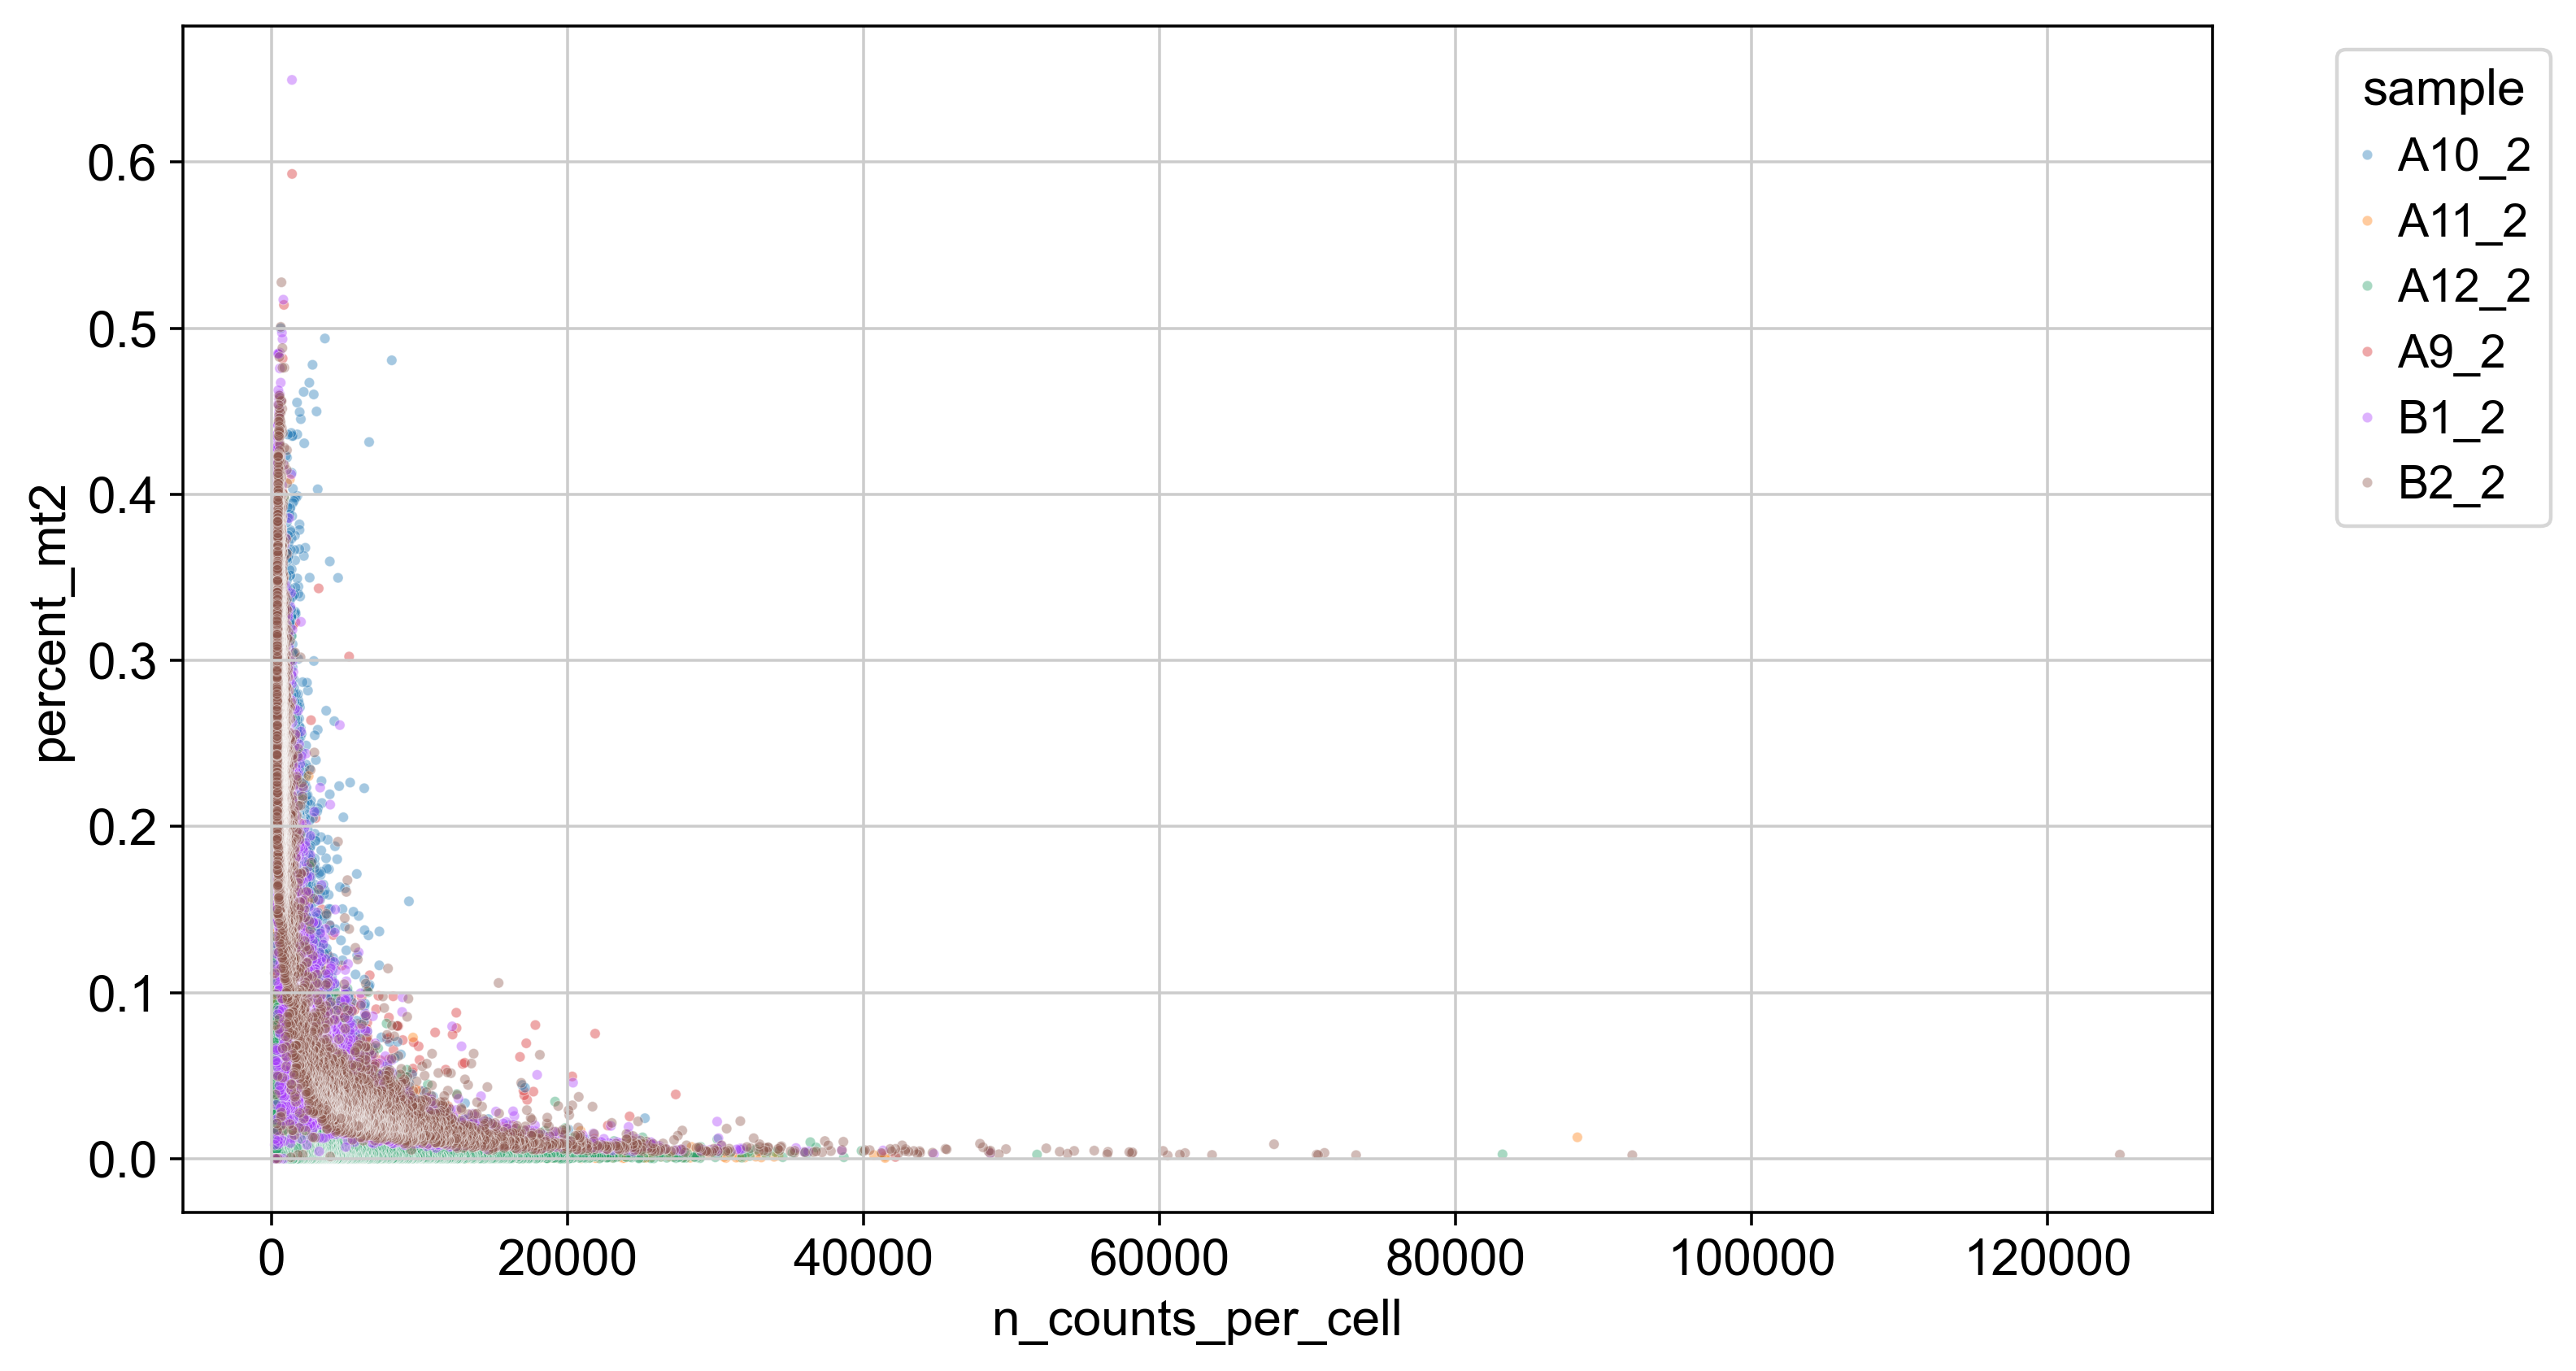

In [25]:
plt.figure(figsize=(10, 6))
sb.scatterplot(data=sample_object.obs, x='n_counts_per_cell', y='percent_mt2' , hue ='sample', alpha = 0.4, s=8)
plt.legend(title='sample', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

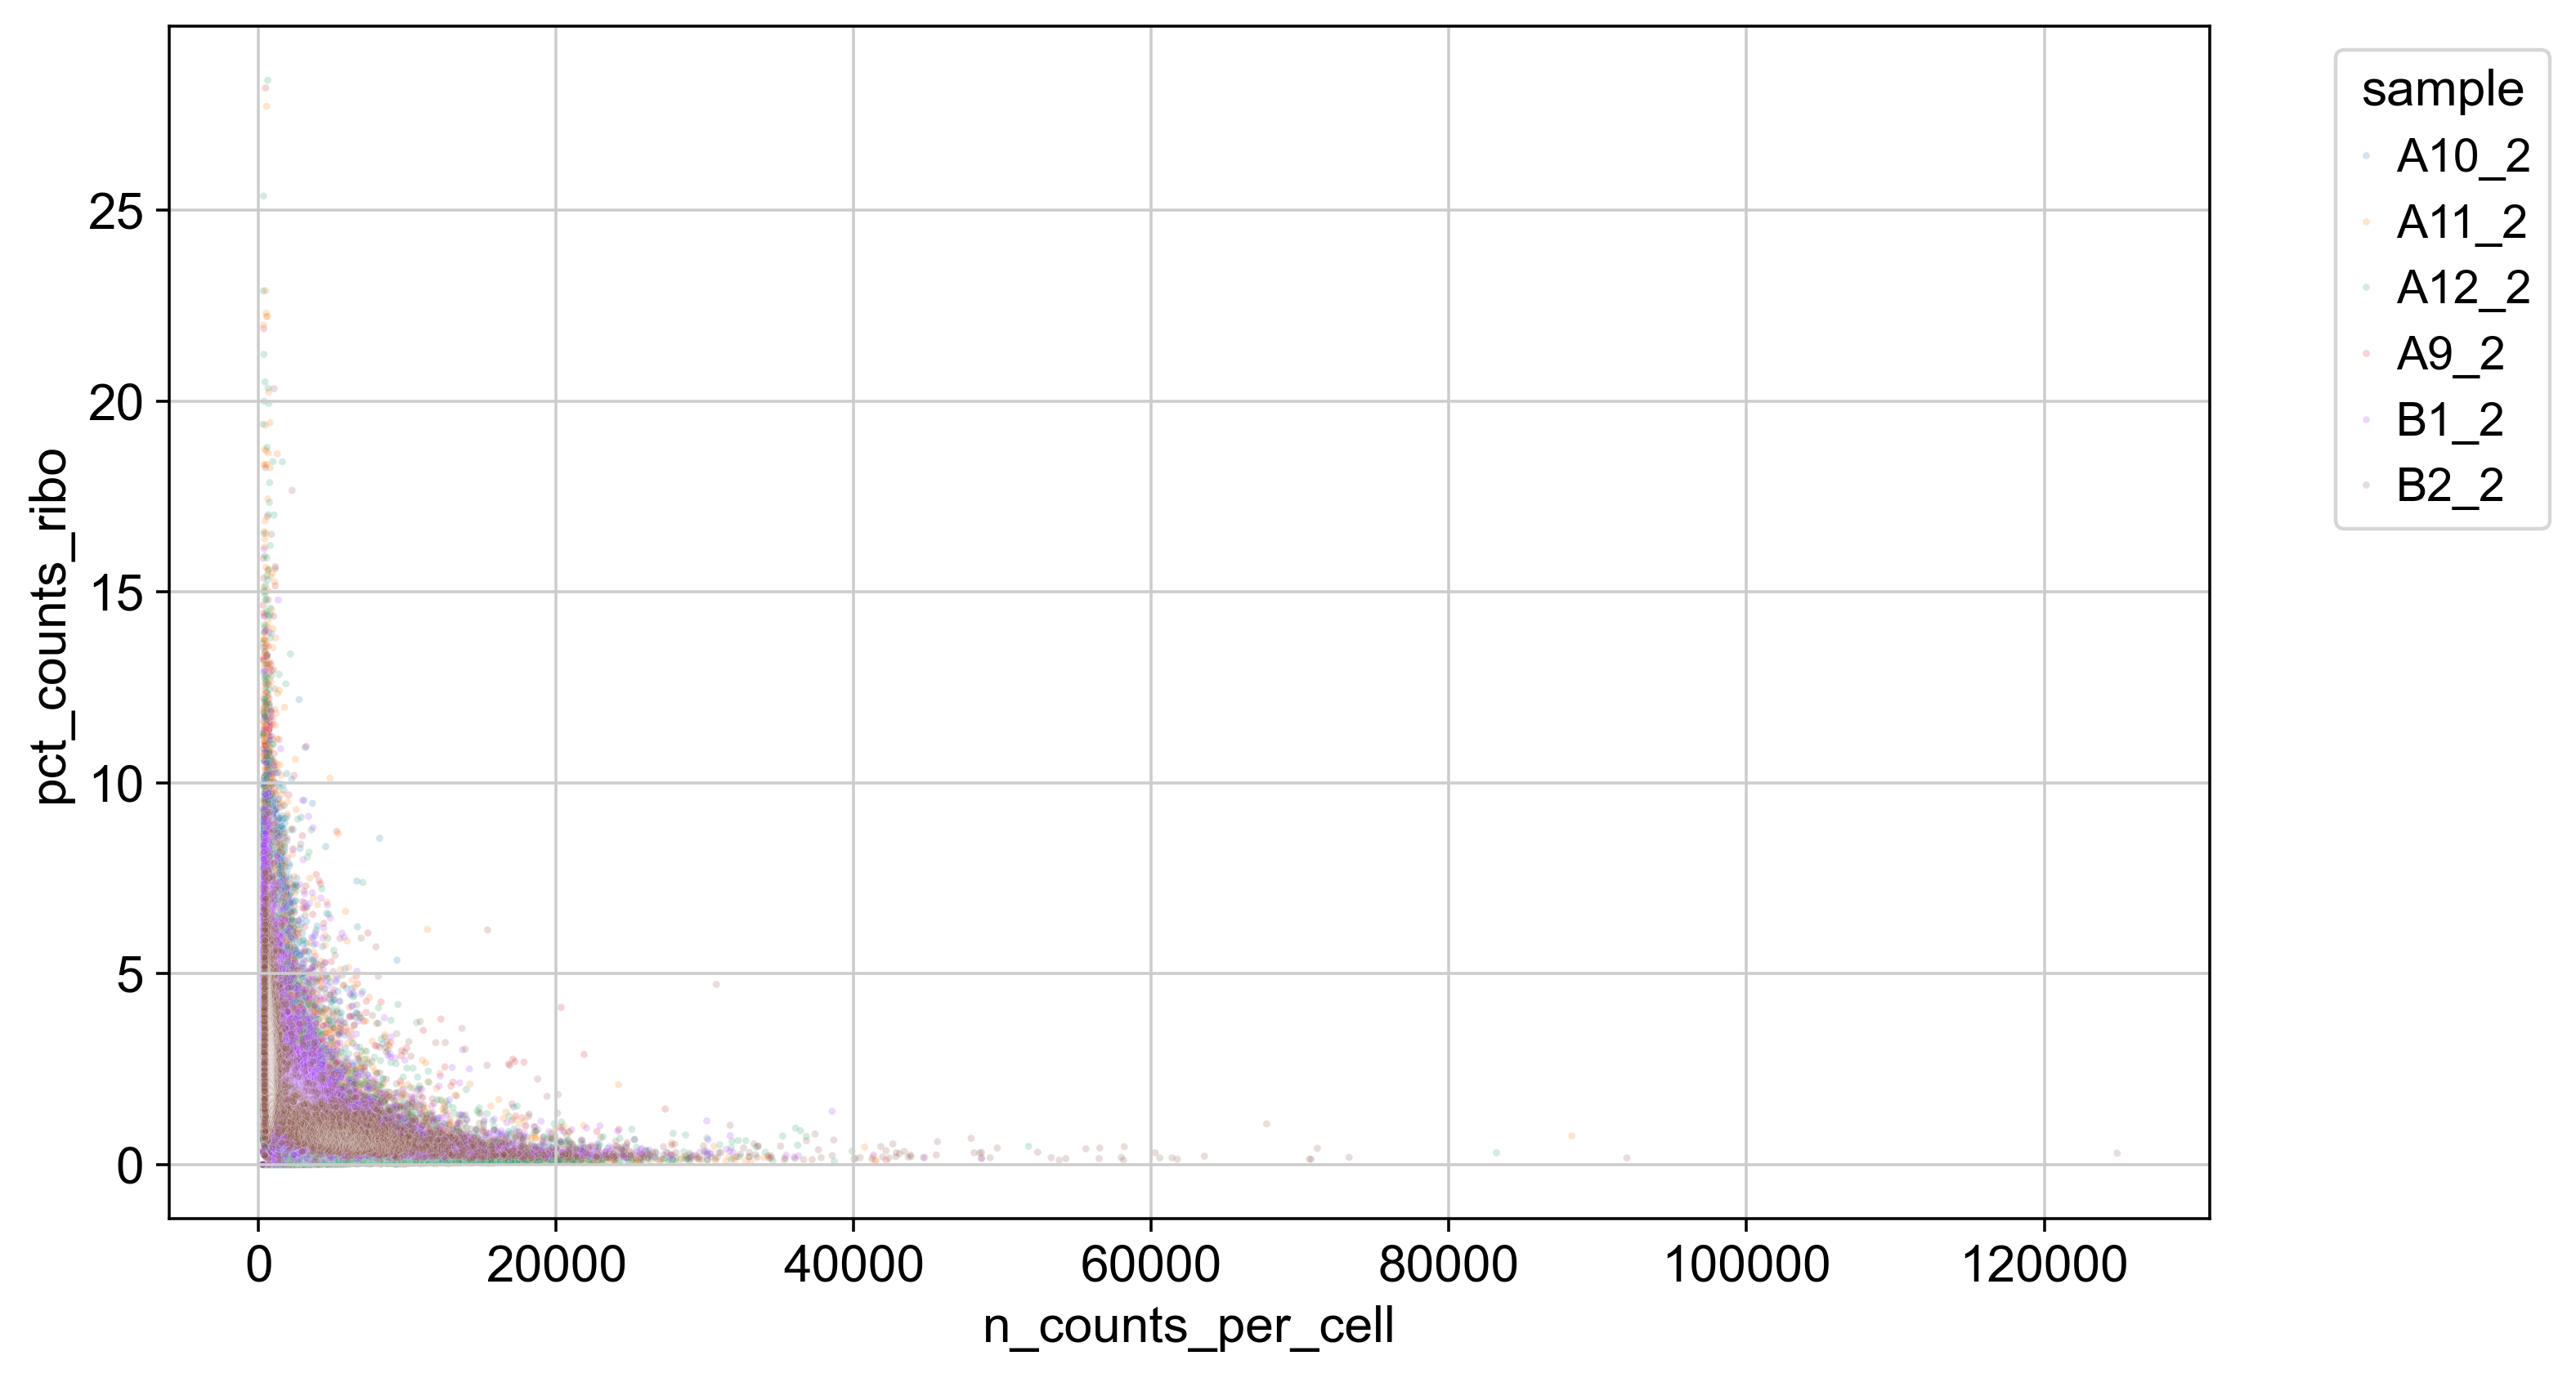

In [26]:
plt.figure(figsize=(10, 6))
sb.scatterplot(data=sample_object.obs, x='n_counts_per_cell', y='pct_counts_ribo' , hue ='sample', alpha = 0.2, s=4)
plt.legend(title='sample', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

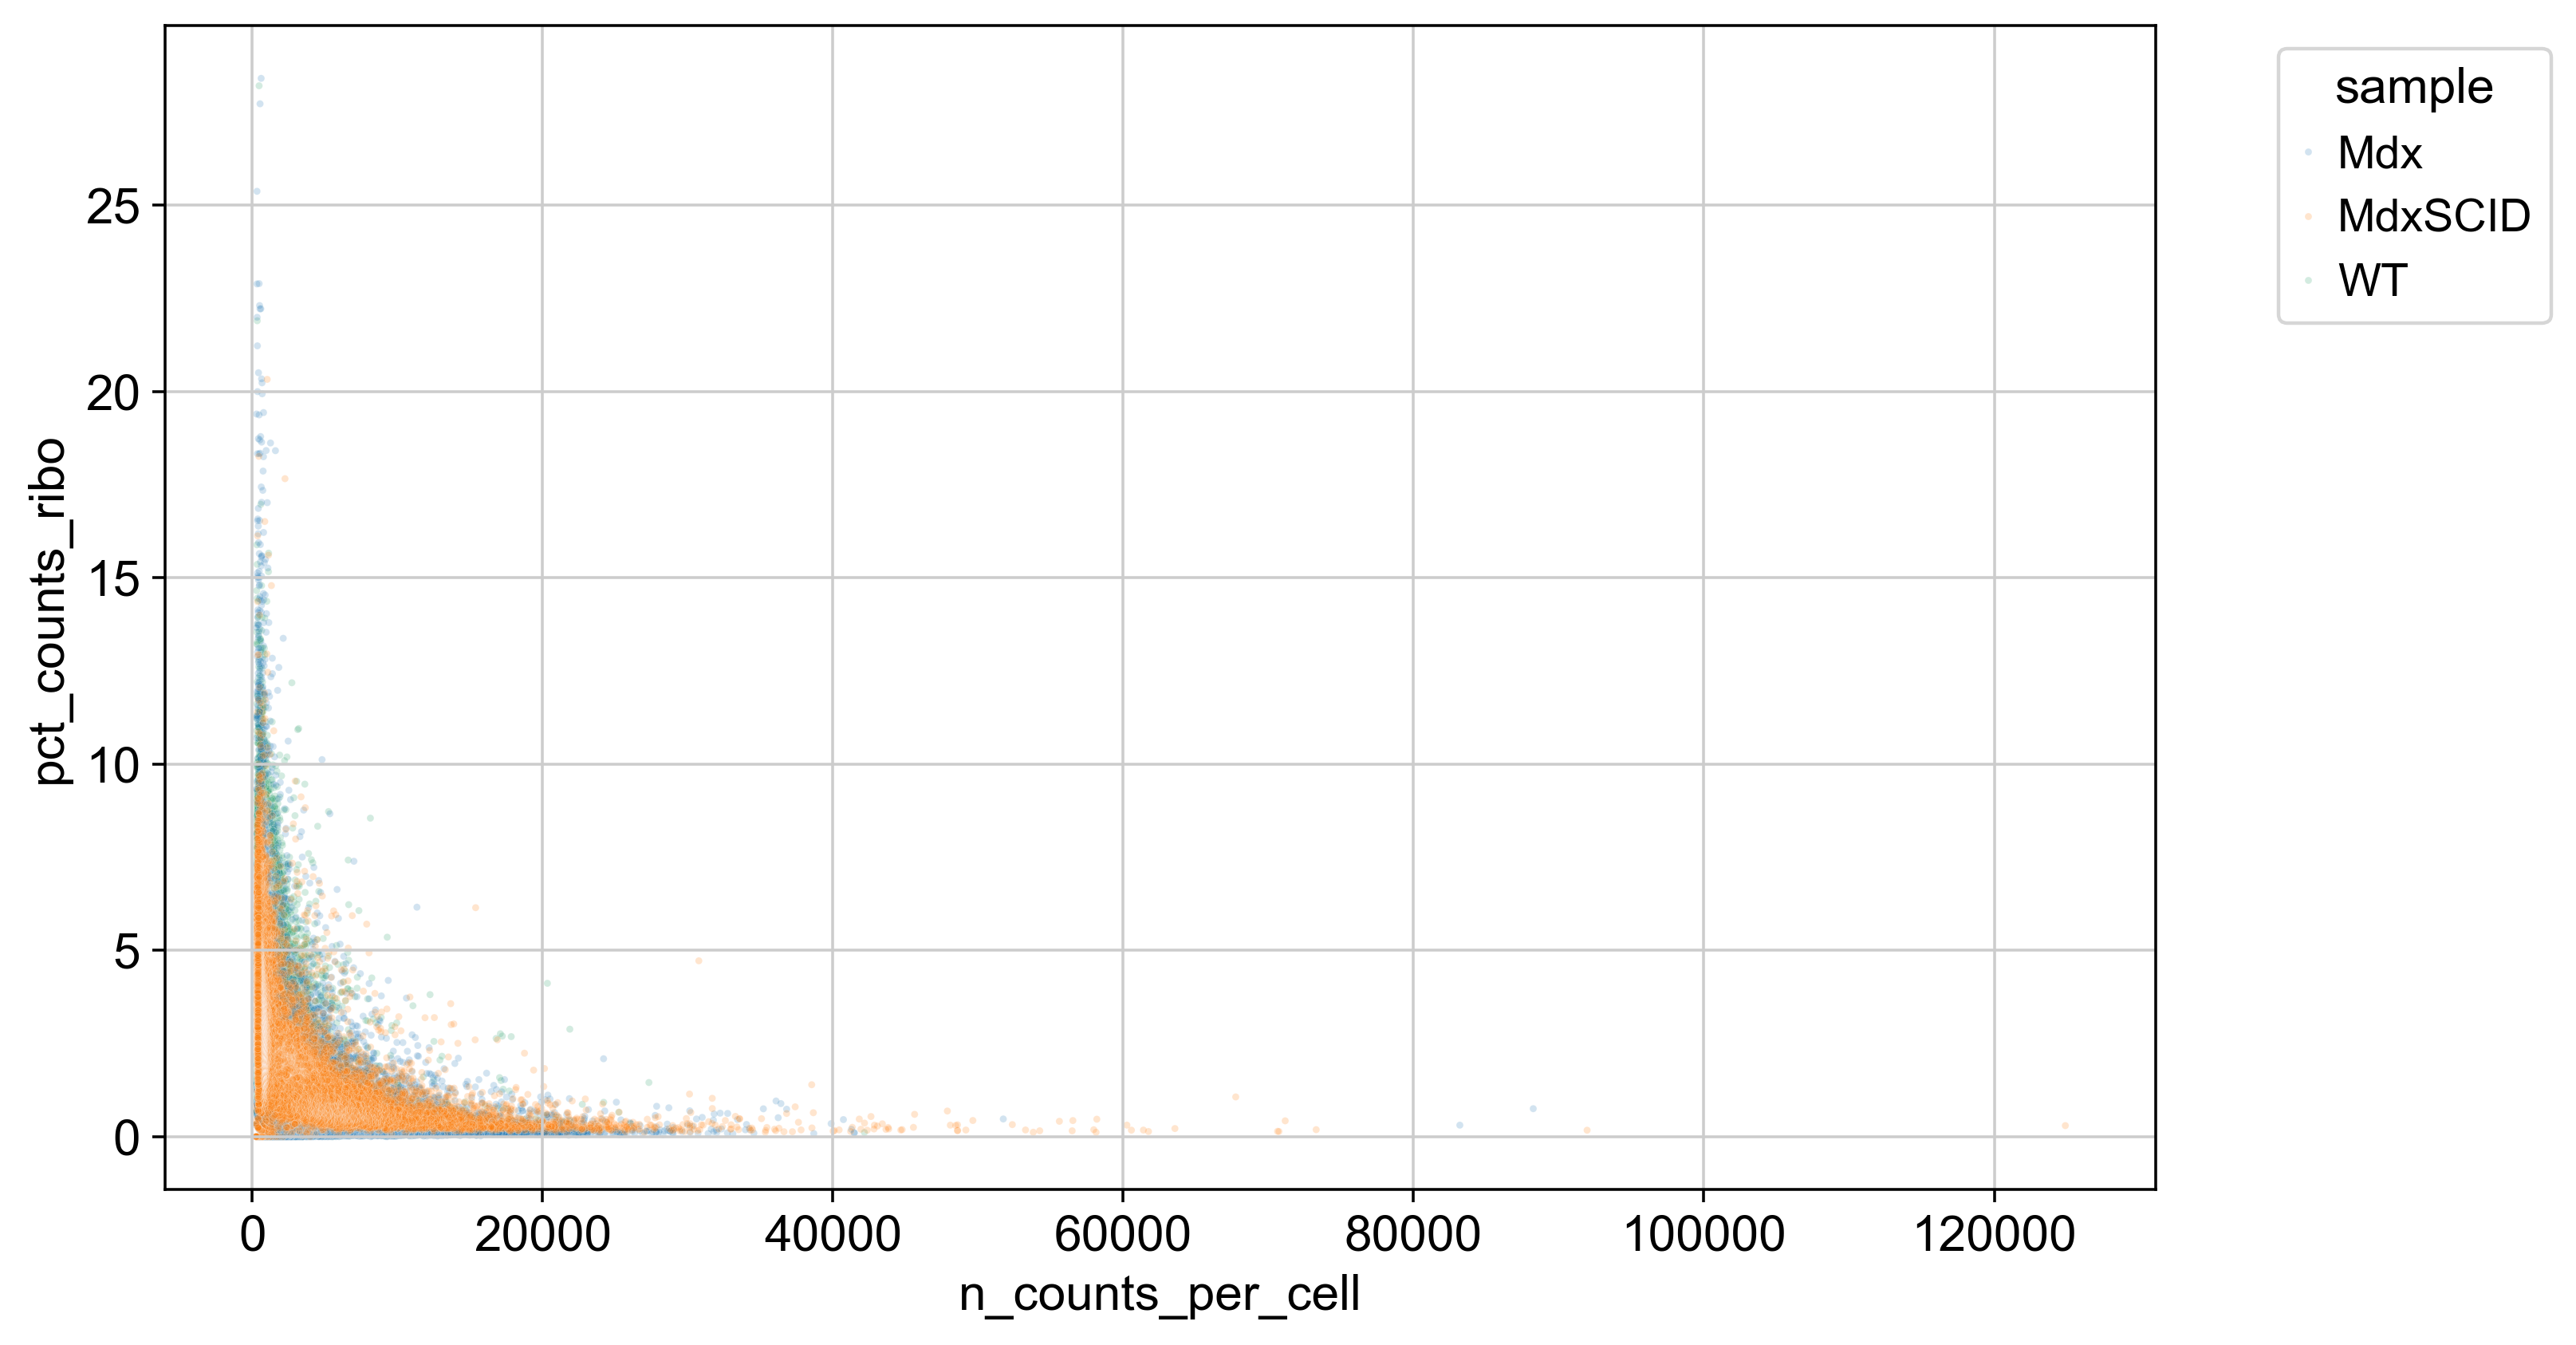

In [27]:
plt.figure(figsize=(10, 6))
sb.scatterplot(data=sample_object.obs, x='n_counts_per_cell', y='pct_counts_ribo' , hue ='genotype', alpha = 0.2, s=4)
plt.legend(title='sample', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Sex covariate analysis

### Ensembl annotations

In [28]:
annot = sc.queries.biomart_annotations(
        "mmusculus",
        ["ensembl_gene_id", "external_gene_name", "start_position", "end_position", "chromosome_name"],
    ).set_index("external_gene_name")

In [29]:
annot.head()

ensembl_gene_id  start_position  end_position  \
external_gene_name                                                     
mt-Tf               ENSMUSG00000064336               1            68   
mt-Rnr1             ENSMUSG00000064337              70          1024   
mt-Tv               ENSMUSG00000064338            1025          1093   
mt-Rnr2             ENSMUSG00000064339            1094          2675   
mt-Tl1              ENSMUSG00000064340            2676          2750   

                   chromosome_name  
external_gene_name                  
mt-Tf                           MT  
mt-Rnr1                         MT  
mt-Tv                           MT  
mt-Rnr2                         MT  
mt-Tl1                          MT

### Chr Y genes calculation

In [30]:
chrY_genes = sample_object.var_names.intersection(annot.index[annot.chromosome_name == "Y"])
chrY_genes

Index(['Gm29089', 'Zfy1', 'Uba1y', 'Gm28588', 'Gm28587', 'Kdm5d', 'Eif2s3y',
       'Gm29650', 'Uty', 'Ddx3y',
       ...
       'Gm28672', 'Gm28670', 'Gm28673', 'Gm28674', 'Gm21996', 'Gm28930',
       'Gm29504', 'Gm20837', 'Gm28300', 'Gm28301'],
      dtype='object', length=719)

In [31]:
sample_object.obs['percent_chrY'] = np.sum(
    sample_object[:, chrY_genes].X, axis = 1) / np.sum(sample_object.X, axis = 1) * 100

### XIST counts

#### Steps followed

1. Select variables having 'xist' in var_names
2. Counts and percentage of XIST 
3. Creating a series to store data
4. Assigning the series back to our data into obs

In [32]:
xist_counts = sample_object.X[:, sample_object.var_names.str.match('Xist')].toarray()
xist_percentage = (np.sum(xist_counts, axis=1) / sample_object.obs['total_counts']) * 100

xist_counts_series = pd.Series(xist_counts.squeeze(), index = sample_object.obs_names, name = "XIST-counts")
xist_percentage_series = pd.Series(xist_percentage, index=sample_object.obs_names, name="percent_XIST")

sample_object.obs["XIST-counts"] = xist_counts_series
sample_object.obs["XIST-percentage"] = xist_percentage_series

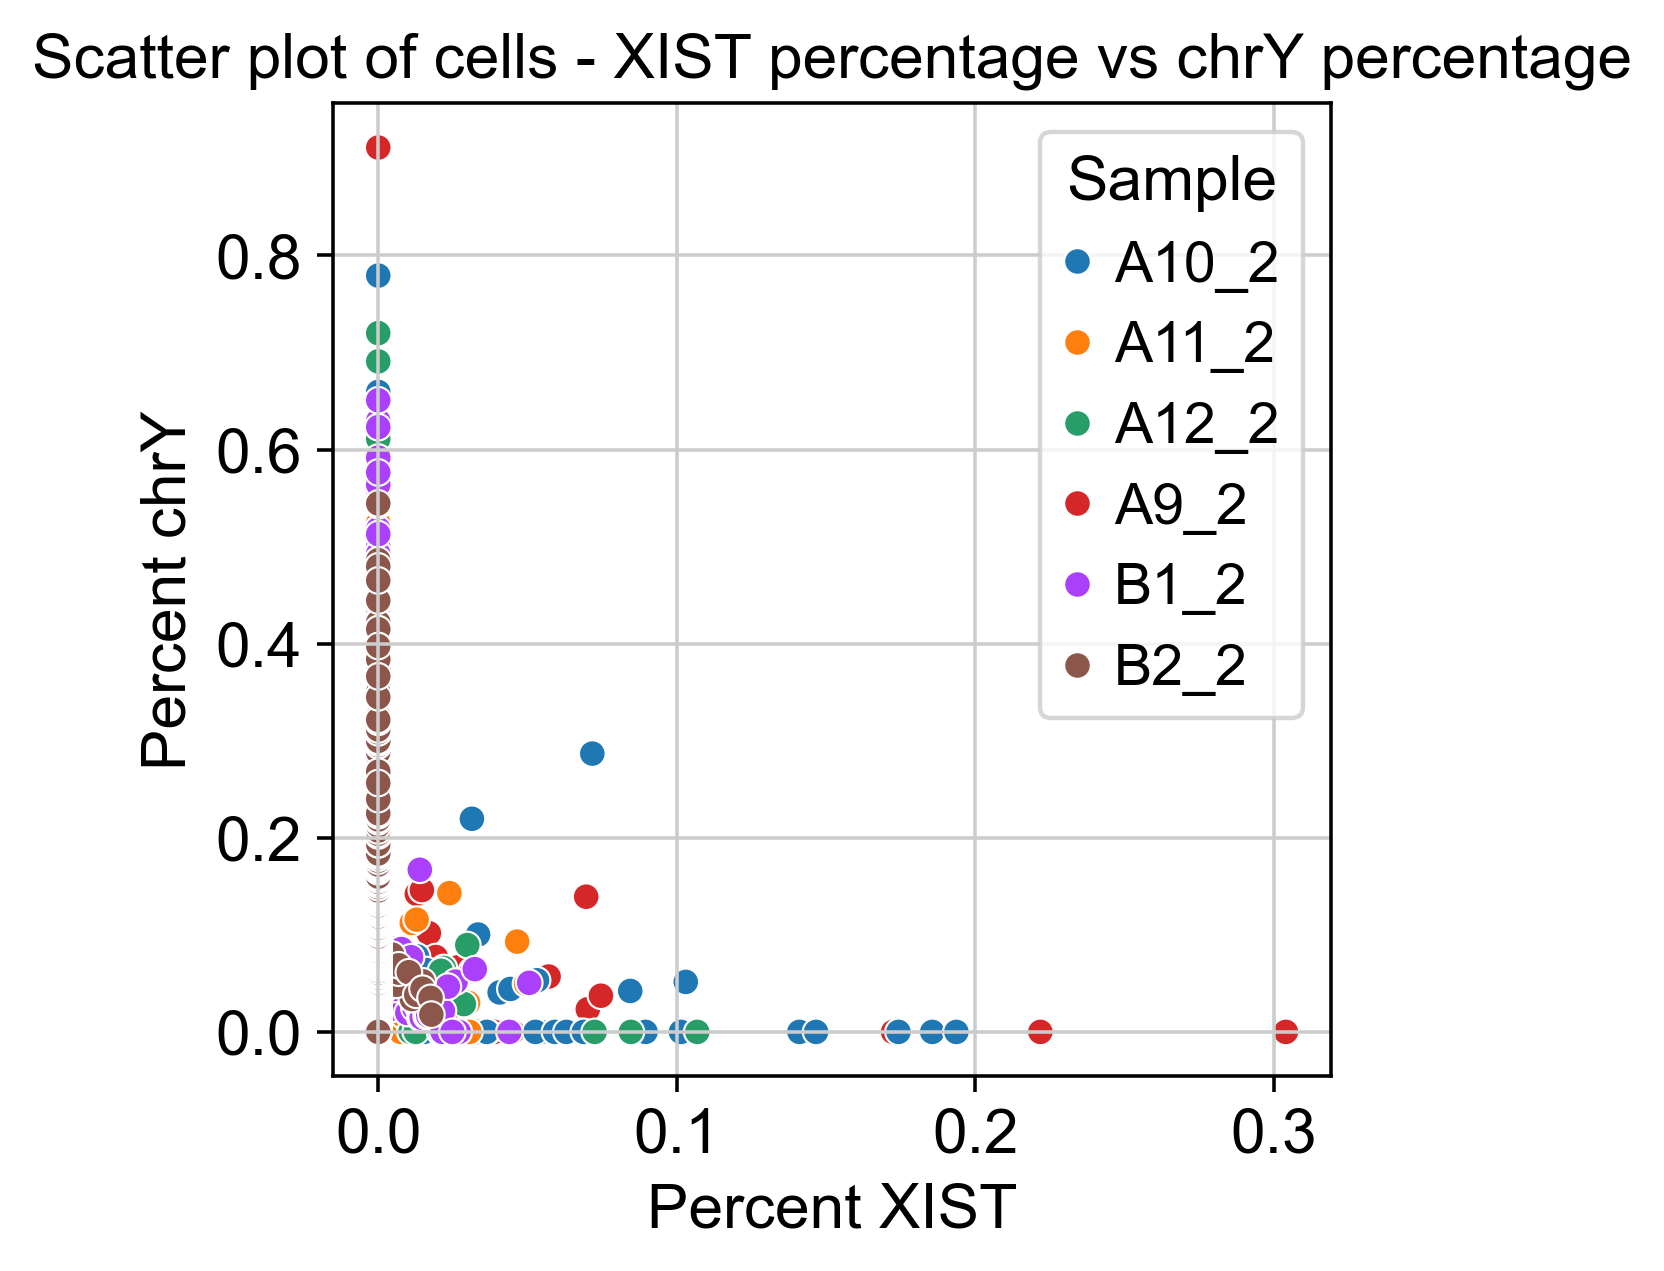

In [33]:
sb.scatterplot(data=sample_object.obs, x="XIST-percentage", y='percent_chrY', hue='sample')
plt.xlabel('Percent XIST')
plt.ylabel('Percent chrY')
plt.title('Scatter plot of cells - XIST percentage vs chrY percentage')
plt.legend(title='Sample')
plt.show()

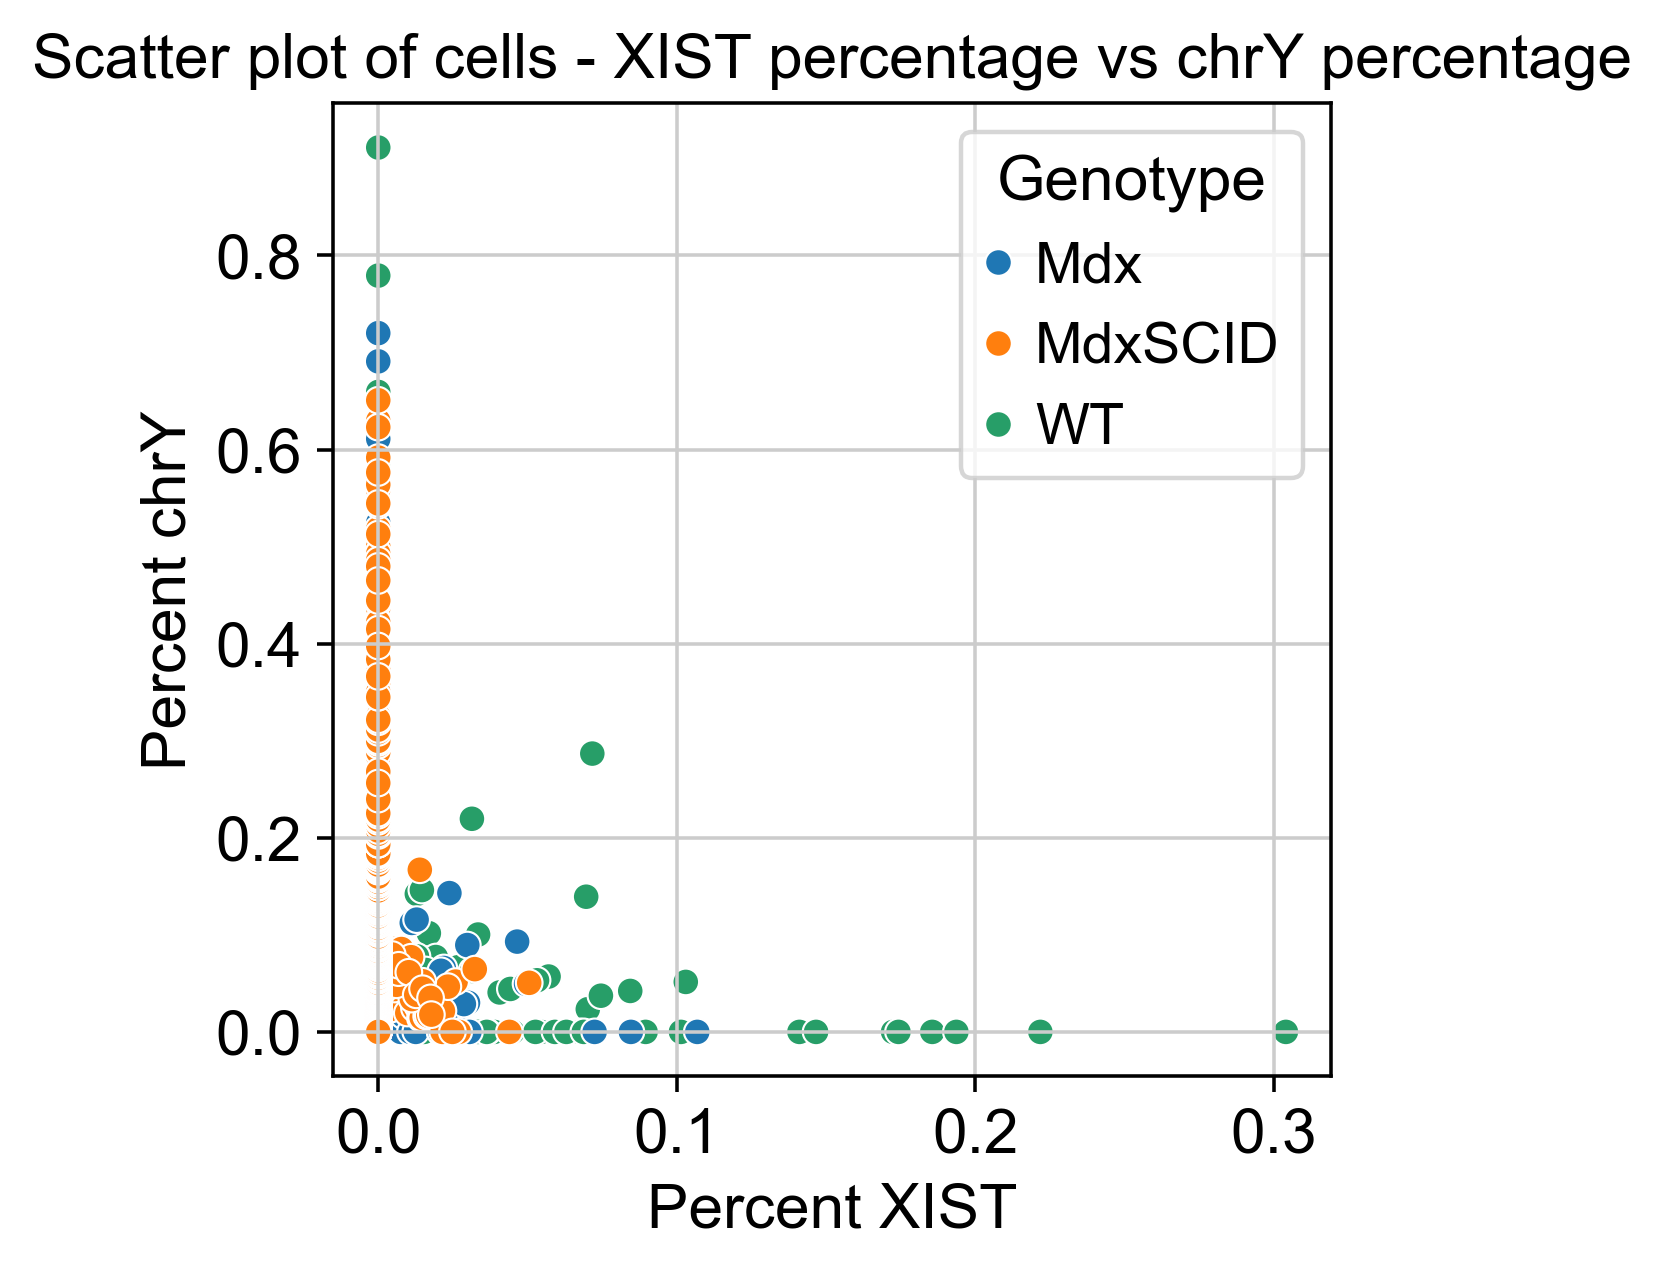

In [34]:
sb.scatterplot(data=sample_object.obs, x="XIST-percentage", y='percent_chrY', hue='genotype')
plt.xlabel('Percent XIST')
plt.ylabel('Percent chrY')
plt.title('Scatter plot of cells - XIST percentage vs chrY percentage')
plt.legend(title='Genotype')
plt.show()

/Users/srivalli/conda/envs/scanpy/lib/python3.12/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/Users/srivalli/conda/envs/scanpy/lib/python3.12/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(
/Users/srivalli/conda/envs/scanpy/lib/python3.12/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/Users/srivalli/conda/envs/scanpy/lib/python3.12/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has b

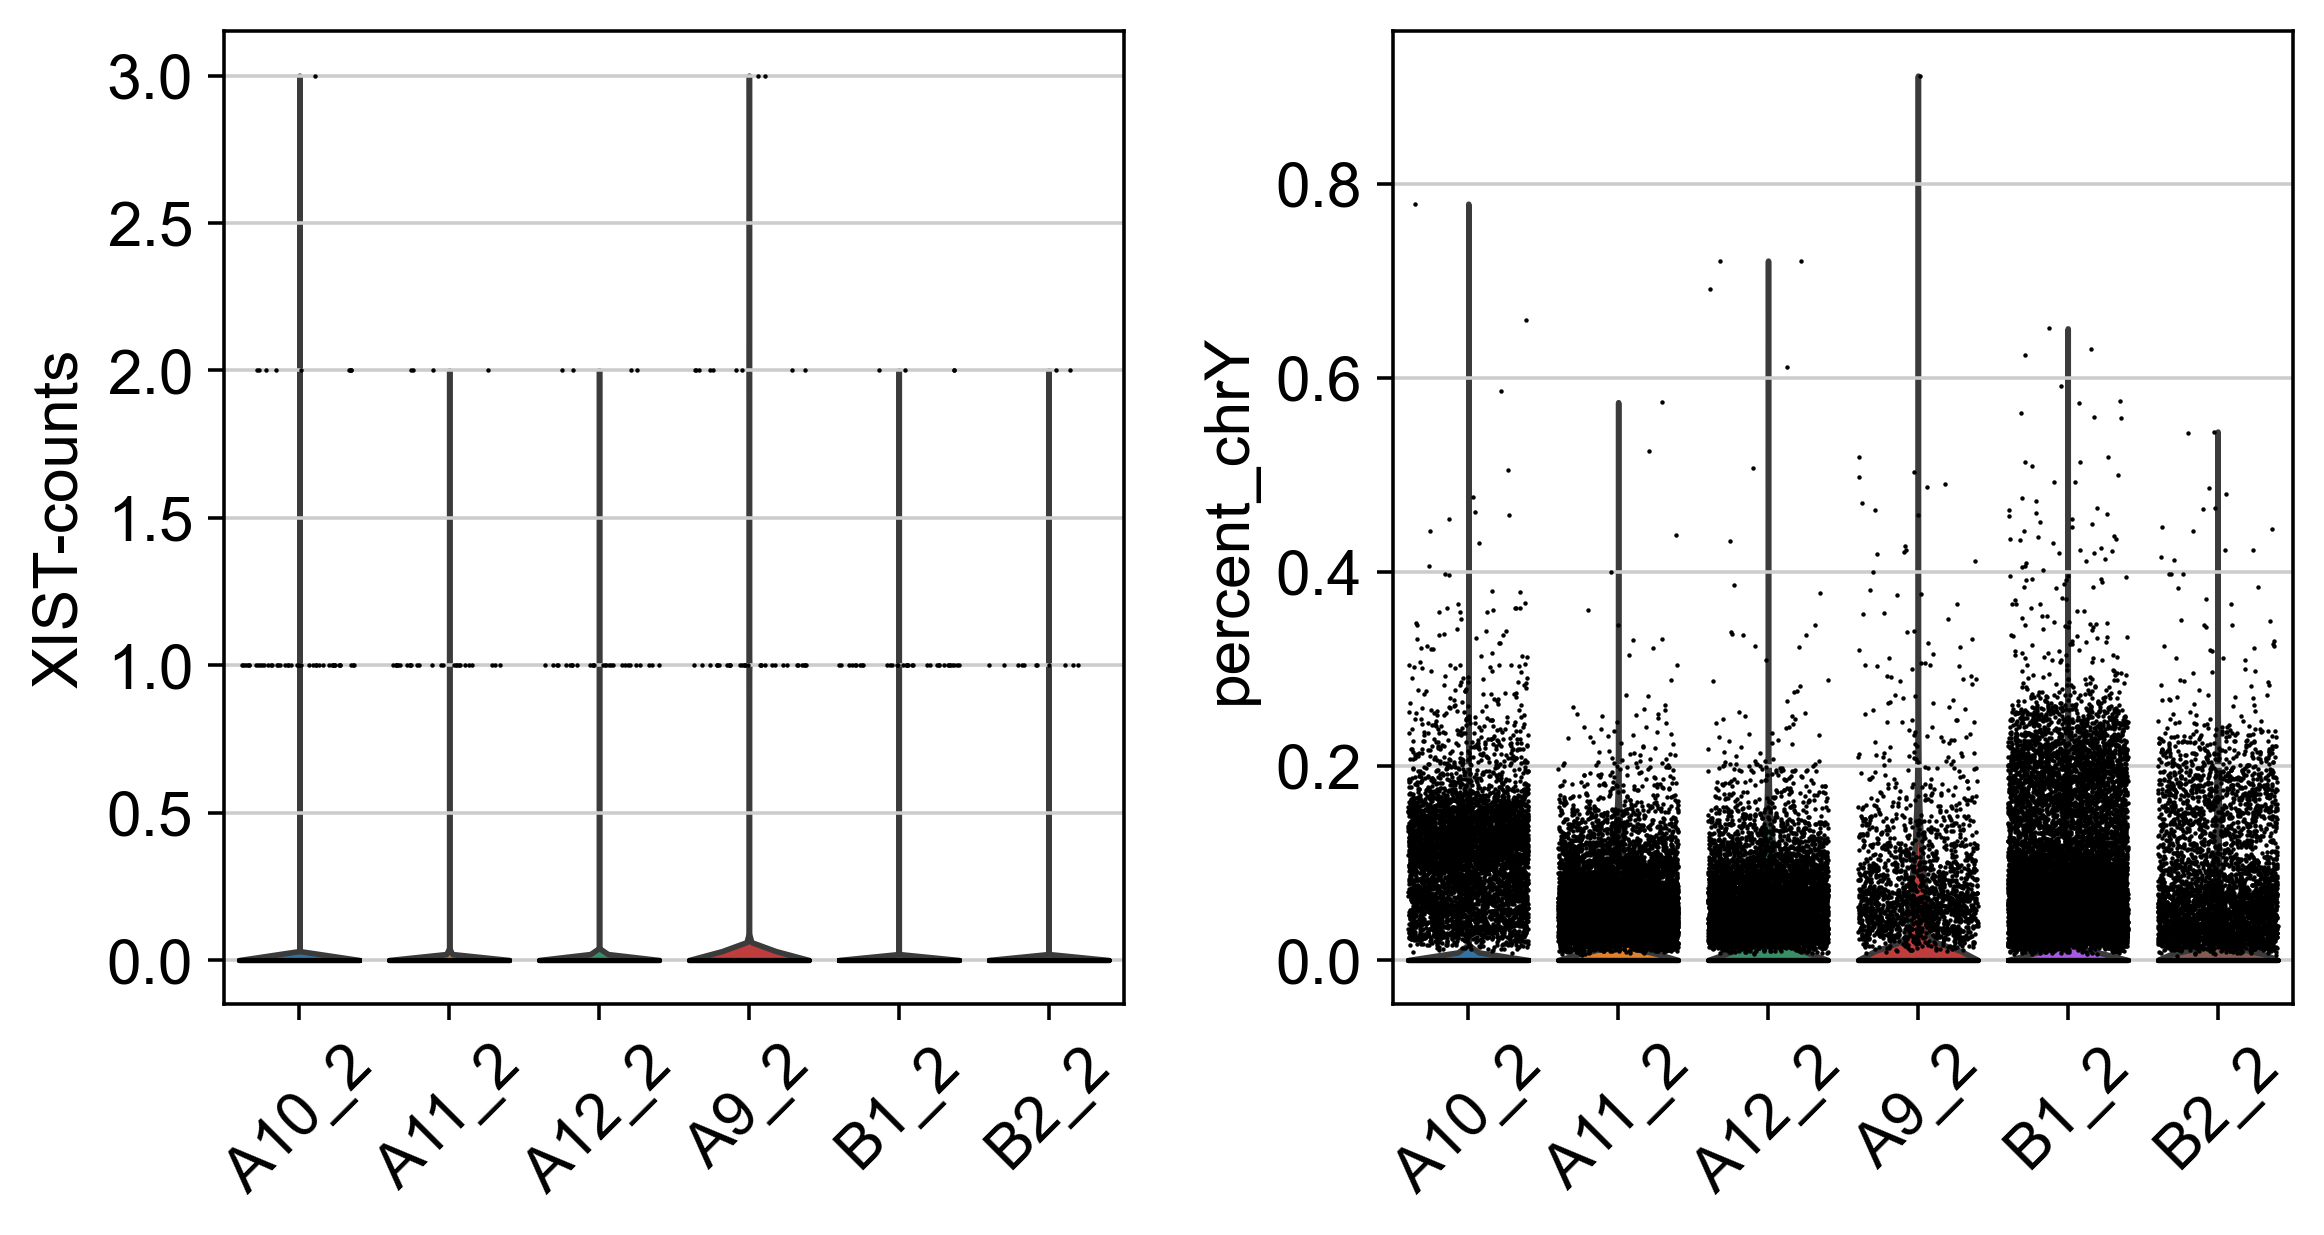

In [35]:
sc.pl.violin(sample_object, ["XIST-counts", "percent_chrY"], jitter = 0.4, groupby = 'sample', rotation = 45)

### Validation of sex covariates

In [36]:
zero_y_counts = len(sample_object.obs[sample_object.obs['percent_chrY'] == 0])
zero_xist_counts = len(sample_object.obs[sample_object.obs['XIST-percentage'] == 0])
both_zero_counts = len(sample_object.obs[(sample_object.obs['percent_chrY'] == 0) & (sample_object.obs['XIST-percentage'] == 0)])

print("Number of observations with 0 Y chromosome counts:", zero_y_counts)
print("Number of observations with 0 XIST counts:", zero_xist_counts)
print("Number of observations with both 0 Y chromosome counts and 0 XIST counts:", both_zero_counts)

Number of observations with 0 Y chromosome counts: 107943
Number of observations with 0 XIST counts: 147313
Number of observations with both 0 Y chromosome counts and 0 XIST counts: 107902


#### Steps followed - Cellular level

1. Create a 'gender_check_cov' variable and classify as male and female based on chrY percentage and XIST percentage
2. Create a 'gender_comparison' variable and classify as true or false in comparision with gender col we have
3. Calculate the counts of True and false
4. Calculate the percentage of True and false counts

In [37]:
sample_object.obs['gender_check_cov'] = np.where(
    (sample_object.obs['percent_chrY'] == 0) & (sample_object.obs['XIST-percentage'] == 0),
    'None',
    np.where(
        sample_object.obs['percent_chrY'] > sample_object.obs['XIST-percentage'],
        'Male',
        'Female'
    )
)

sample_object.obs

sample genotype batch  n_genes  doublet_scores  \
CTTCAATCAATAGTCC-1-A9_2-A9_2   A9_2       WT  A9_2     6363        0.048159   
GATGCTAAGCAGTAAT-1-A9_2-A9_2   A9_2       WT  A9_2     6638        0.407407   
GCTACCTAGGTTGGTG-1-A9_2-A9_2   A9_2       WT  A9_2     5794        0.115207   
GATTCTTCACACCTTC-1-A9_2-A9_2   A9_2       WT  A9_2     5740        0.240106   
TAAGCCACATGAGAAT-1-A9_2-A9_2   A9_2       WT  A9_2     5005        0.048159   
...                             ...      ...   ...      ...             ...   
TCAGTTTAGGGAACAA-1-B2_2-B2_2   B2_2  MdxSCID  B2_2      254        0.146637   
GCAACCGTCTAACGCA-1-B2_2-B2_2   B2_2  MdxSCID  B2_2      209        0.200000   
AGAGAGCGTCGCAGTC-1-B2_2-B2_2   B2_2  MdxSCID  B2_2      286        0.269841   
GTCAAACCATTGACAC-1-B2_2-B2_2   B2_2  MdxSCID  B2_2      219        0.122807   
GATTTCTTCGCAGTGC-1-B2_2-B2_2   B2_2  MdxSCID  B2_2      216        0.090617   

                             predicted_doublets  n_genes_by_counts  \
CTTCAATCAATAGTCC-1-A9_2-A9_2              False               6363   
GATGCTAAGCAGTAAT-1-A9_2-A9_2              False               6638   
GCTACCTAGGTTGGTG-1-A9_2-A9_2              False               5794   
GATTCTTCACACCTTC-1-A9_2-A9_2              False               5740   
TAAGCCACATGAGAAT-1-A9_2-A9_2              False               5005   
...                                         ...                ...   
TCAGTTTAGGGAACAA-1-B2_2-B2_2              False                254   
GCAACCGTCTAACGCA-1-B2_2-B2_2              False                209   
AGAGAGCGTCGCAGTC-1-B2_2-B2_2              False                286   
GTCAAACCATTGACAC-1-B2_2-B2_2              False                219   
GATTTCTTCGCAGTGC-1-B2_2-B2_2              False                216   

                              total_counts  total_counts_mt  pct_counts_mt  \
CTTCAATCAATAGTCC-1-A9_2-A9_2       42171.0             41.0       0.097223   
GATGCTAAGCAGTAAT-1-A9_2-A9_2       27328.0           1056.0       3.864169   
GCTACCTAGGTTGGTG-1-A9_2-A9_2       26030.0            103.0       0.395697   
GATTCTTCACACCTTC-1-A9_2-A9_2       24212.0            615.0       2.540063   
TAAGCCACATGAGAAT-1-A9_2-A9_2       22787.0             37.0       0.162373   
...                                    ...              ...            ...   
TCAGTTTAGGGAACAA-1-B2_2-B2_2         293.0             29.0       9.897611   
GCAACCGTCTAACGCA-1-B2_2-B2_2         242.0             27.0      11.157025   
AGAGAGCGTCGCAGTC-1-B2_2-B2_2         326.0              0.0       0.000000   
GTCAAACCATTGACAC-1-B2_2-B2_2         274.0             22.0       8.029197   
GATTTCTTCGCAGTGC-1-B2_2-B2_2         285.0             11.0       3.859649   

                              total_counts_ribo  pct_counts_ribo  percent_mt2  \
CTTCAATCAATAGTCC-1-A9_2-A9_2               47.0         0.111451     0.000972   
GATGCTAAGCAGTAAT-1-A9_2-A9_2              397.0         1.452722     0.038642   
GCTACCTAGGTTGGTG-1-A9_2-A9_2               90.0         0.345755     0.003957   
GATTCTTCACACCTTC-1-A9_2-A9_2              223.0         0.921031     0.025401   
TAAGCCACATGAGAAT-1-A9_2-A9_2               22.0         0.096546     0.001624   
...                                         ...              ...          ...   
TCAGTTTAGGGAACAA-1-B2_2-B2_2                0.0         0.000000     0.098976   
GCAACCGTCTAACGCA-1-B2_2-B2_2                2.0         0.826446     0.111570   
AGAGAGCGTCGCAGTC-1-B2_2-B2_2                0.0         0.000000     0.000000   
GTCAAACCATTGACAC-1-B2_2-B2_2                0.0         0.000000     0.080292   
GATTTCTTCGCAGTGC-1-B2_2-B2_2                2.0         0.701754     0.038596   

                              n_counts_per_cell  percent_chrY  XIST-counts  \
CTTCAATCAATAGTCC-1-A9_2-A9_2            42171.0      0.068768          1.0   
GATGCTAAGCAGTAAT-1-A9_2-A9_2            27328.0      0.025615          0.0   
GCTACCTAGGTTGGTG-1-A9_2-A9_2            26030.0      0.030734          0.0   
GATTCTTCACACCTTC-

#### Steps followed - sample level

1. Group by sample and calculate the gender for each sample
2. Classify samples based on the counts of gender_check_cov
3. Calculate gender comparison at the sample level by considering the highest number of male, female and none classification of cells in the sample
4. Create DataFrame for classification
5. Display the results

In [38]:
sample_gender_list = []

for sample in sample_object.obs['sample'].unique():
    sample_data = sample_object.obs[sample_object.obs['sample'] == sample]
    gender_counts = sample_data['gender_check_cov'].value_counts()
    
    if 'Male' in gender_counts.index and 'Female' in gender_counts.index and 'None' in gender_counts.index:
        if gender_counts['None'] > gender_counts['Male'] and gender_counts['None'] > gender_counts['Female']:
            sample_gender = 'None'
        elif gender_counts['Male'] > gender_counts['Female']:
            sample_gender = 'Male'
        else:
            sample_gender = 'Female'
    elif 'Male' in gender_counts.index and 'Female' in gender_counts.index:
        if gender_counts['Male'] > gender_counts['Female']:
            sample_gender = 'Male'
        else:
            sample_gender = 'Female'
    elif 'Male' in gender_counts.index:
        sample_gender = 'Male'
    elif 'Female' in gender_counts.index:
        sample_gender = 'Female'
    else:
        sample_gender = 'None'
    
    sample_gender_list.append((sample, sample_gender))

sample_gender_df = pd.DataFrame(sample_gender_list, columns=['sample', 'gender'])

print(sample_gender_df)

  sample gender
0   A9_2   None
1  A10_2   None
2  A11_2   Male
3  A12_2   Male
4   B1_2   None
5   B2_2   None


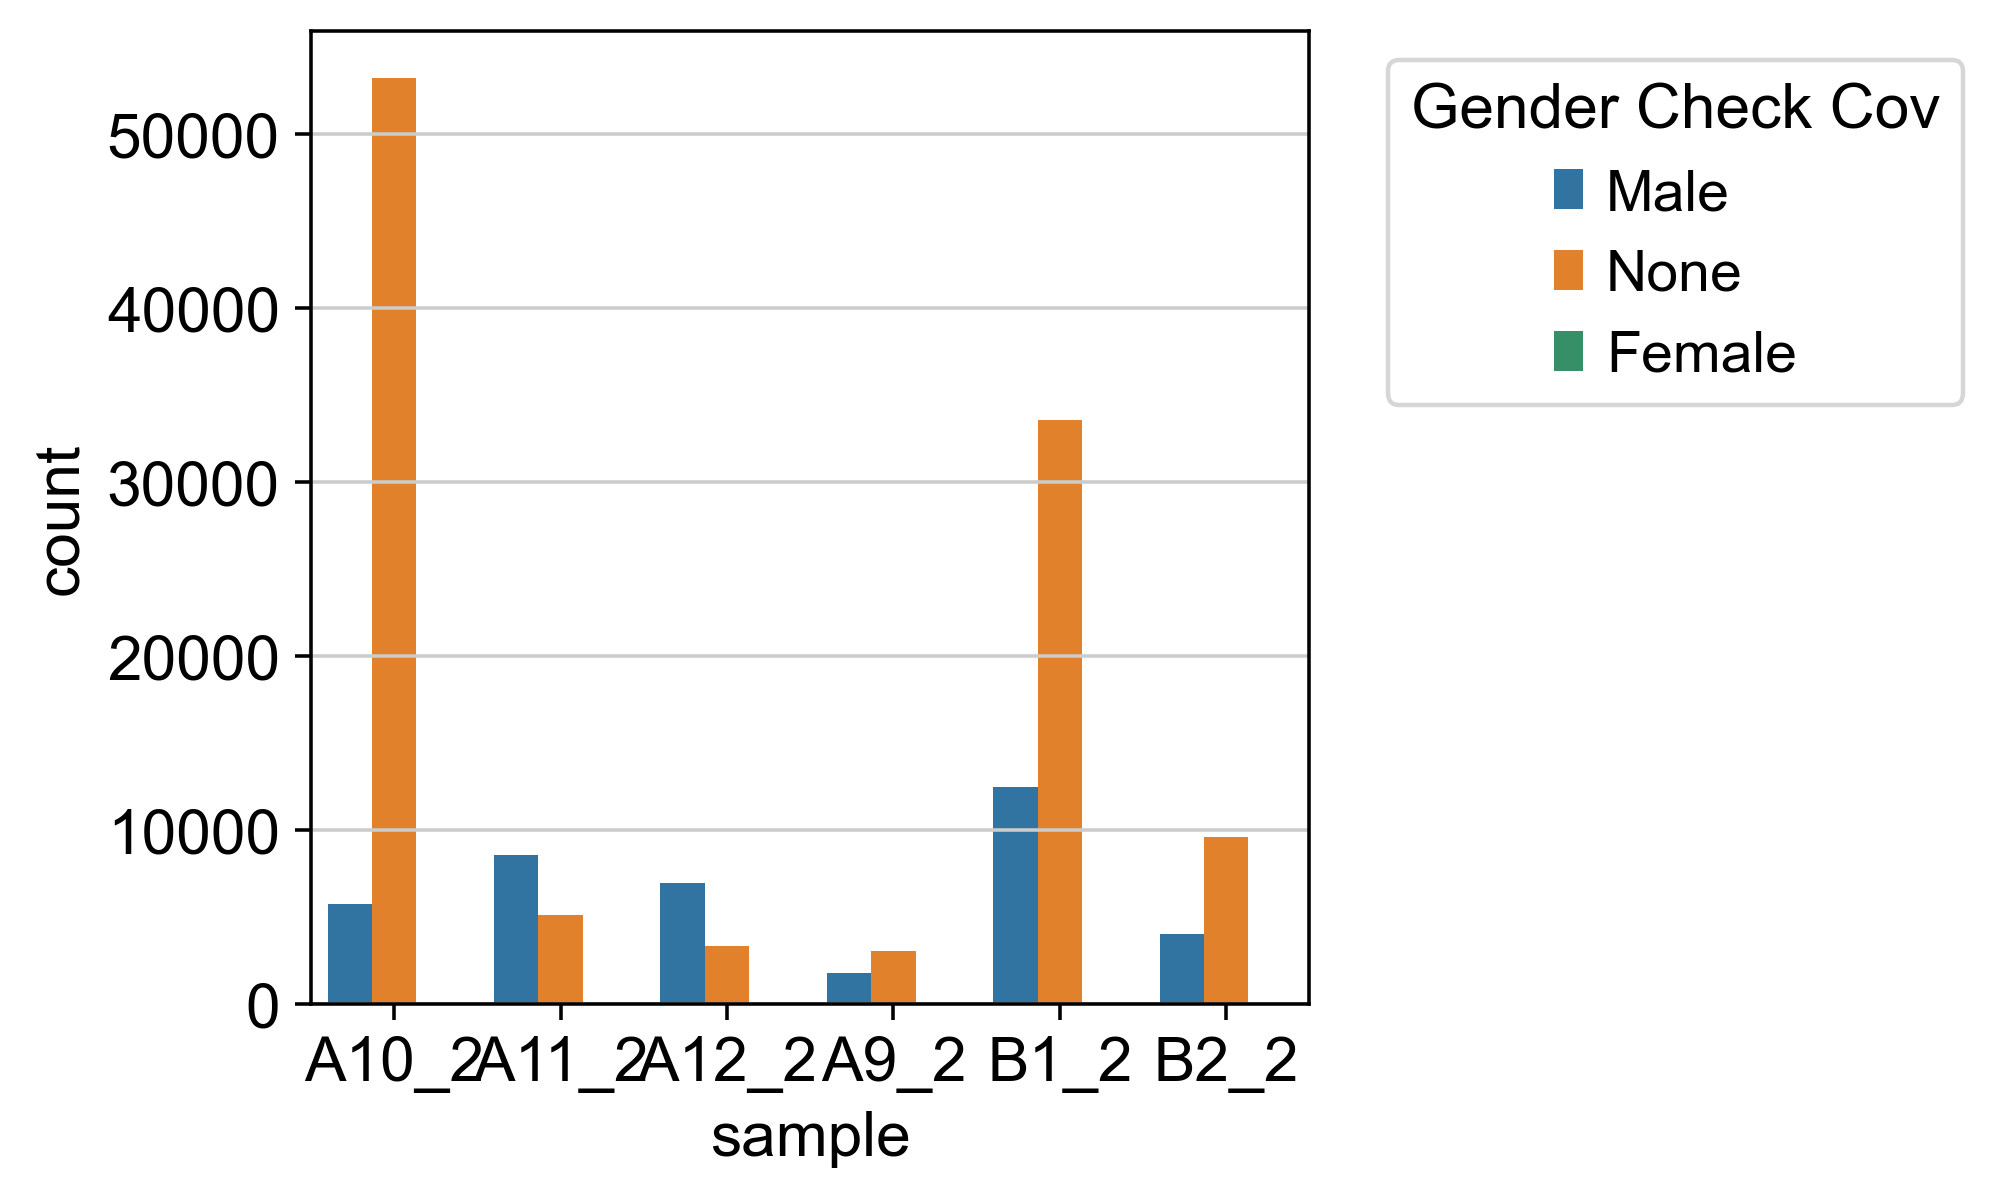

In [39]:
sb.countplot(data=sample_object.obs, x ='sample',hue='gender_check_cov')
plt.legend(title='Gender Check Cov', bbox_to_anchor=(1.05, 1), loc='upper left')

In [40]:
genotype_counts = sample_object.obs.groupby(['sample', 'genotype','gender_check_cov']).size().unstack(fill_value=0)
print(genotype_counts)

gender_check_cov  Female   Male   None
sample genotype                       
A10_2  Mdx             0      0      0
       MdxSCID         0      0      0
       WT             29   5723  53228
A11_2  Mdx             9   8570   5143
       MdxSCID         0      0      0
       WT              0      0      0
A12_2  Mdx             9   6932   3332
       MdxSCID         0      0      0
       WT              0      0      0
A9_2   Mdx             0      0      0
       MdxSCID         0      0      0
       WT             19   1803   3069
B1_2   Mdx             0      0      0
       MdxSCID        10  12500  33554
       WT              0      0      0
B2_2   Mdx             0      0      0
       MdxSCID         1   4013   9576
       WT              0      0      0


/var/folders/m6/j4jl72rj0pl7_bbwngtxl9ym0000gn/T/ipykernel_55926/1743670494.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  genotype_counts = sample_object.obs.groupby(['sample', 'genotype','gender_check_cov']).size().unstack(fill_value=0)


/var/folders/m6/j4jl72rj0pl7_bbwngtxl9ym0000gn/T/ipykernel_55926/1939940317.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  genotype_gender_counts = sample_object.obs.groupby(['genotype', 'gender_check_cov']).size().unstack(fill_value=0)


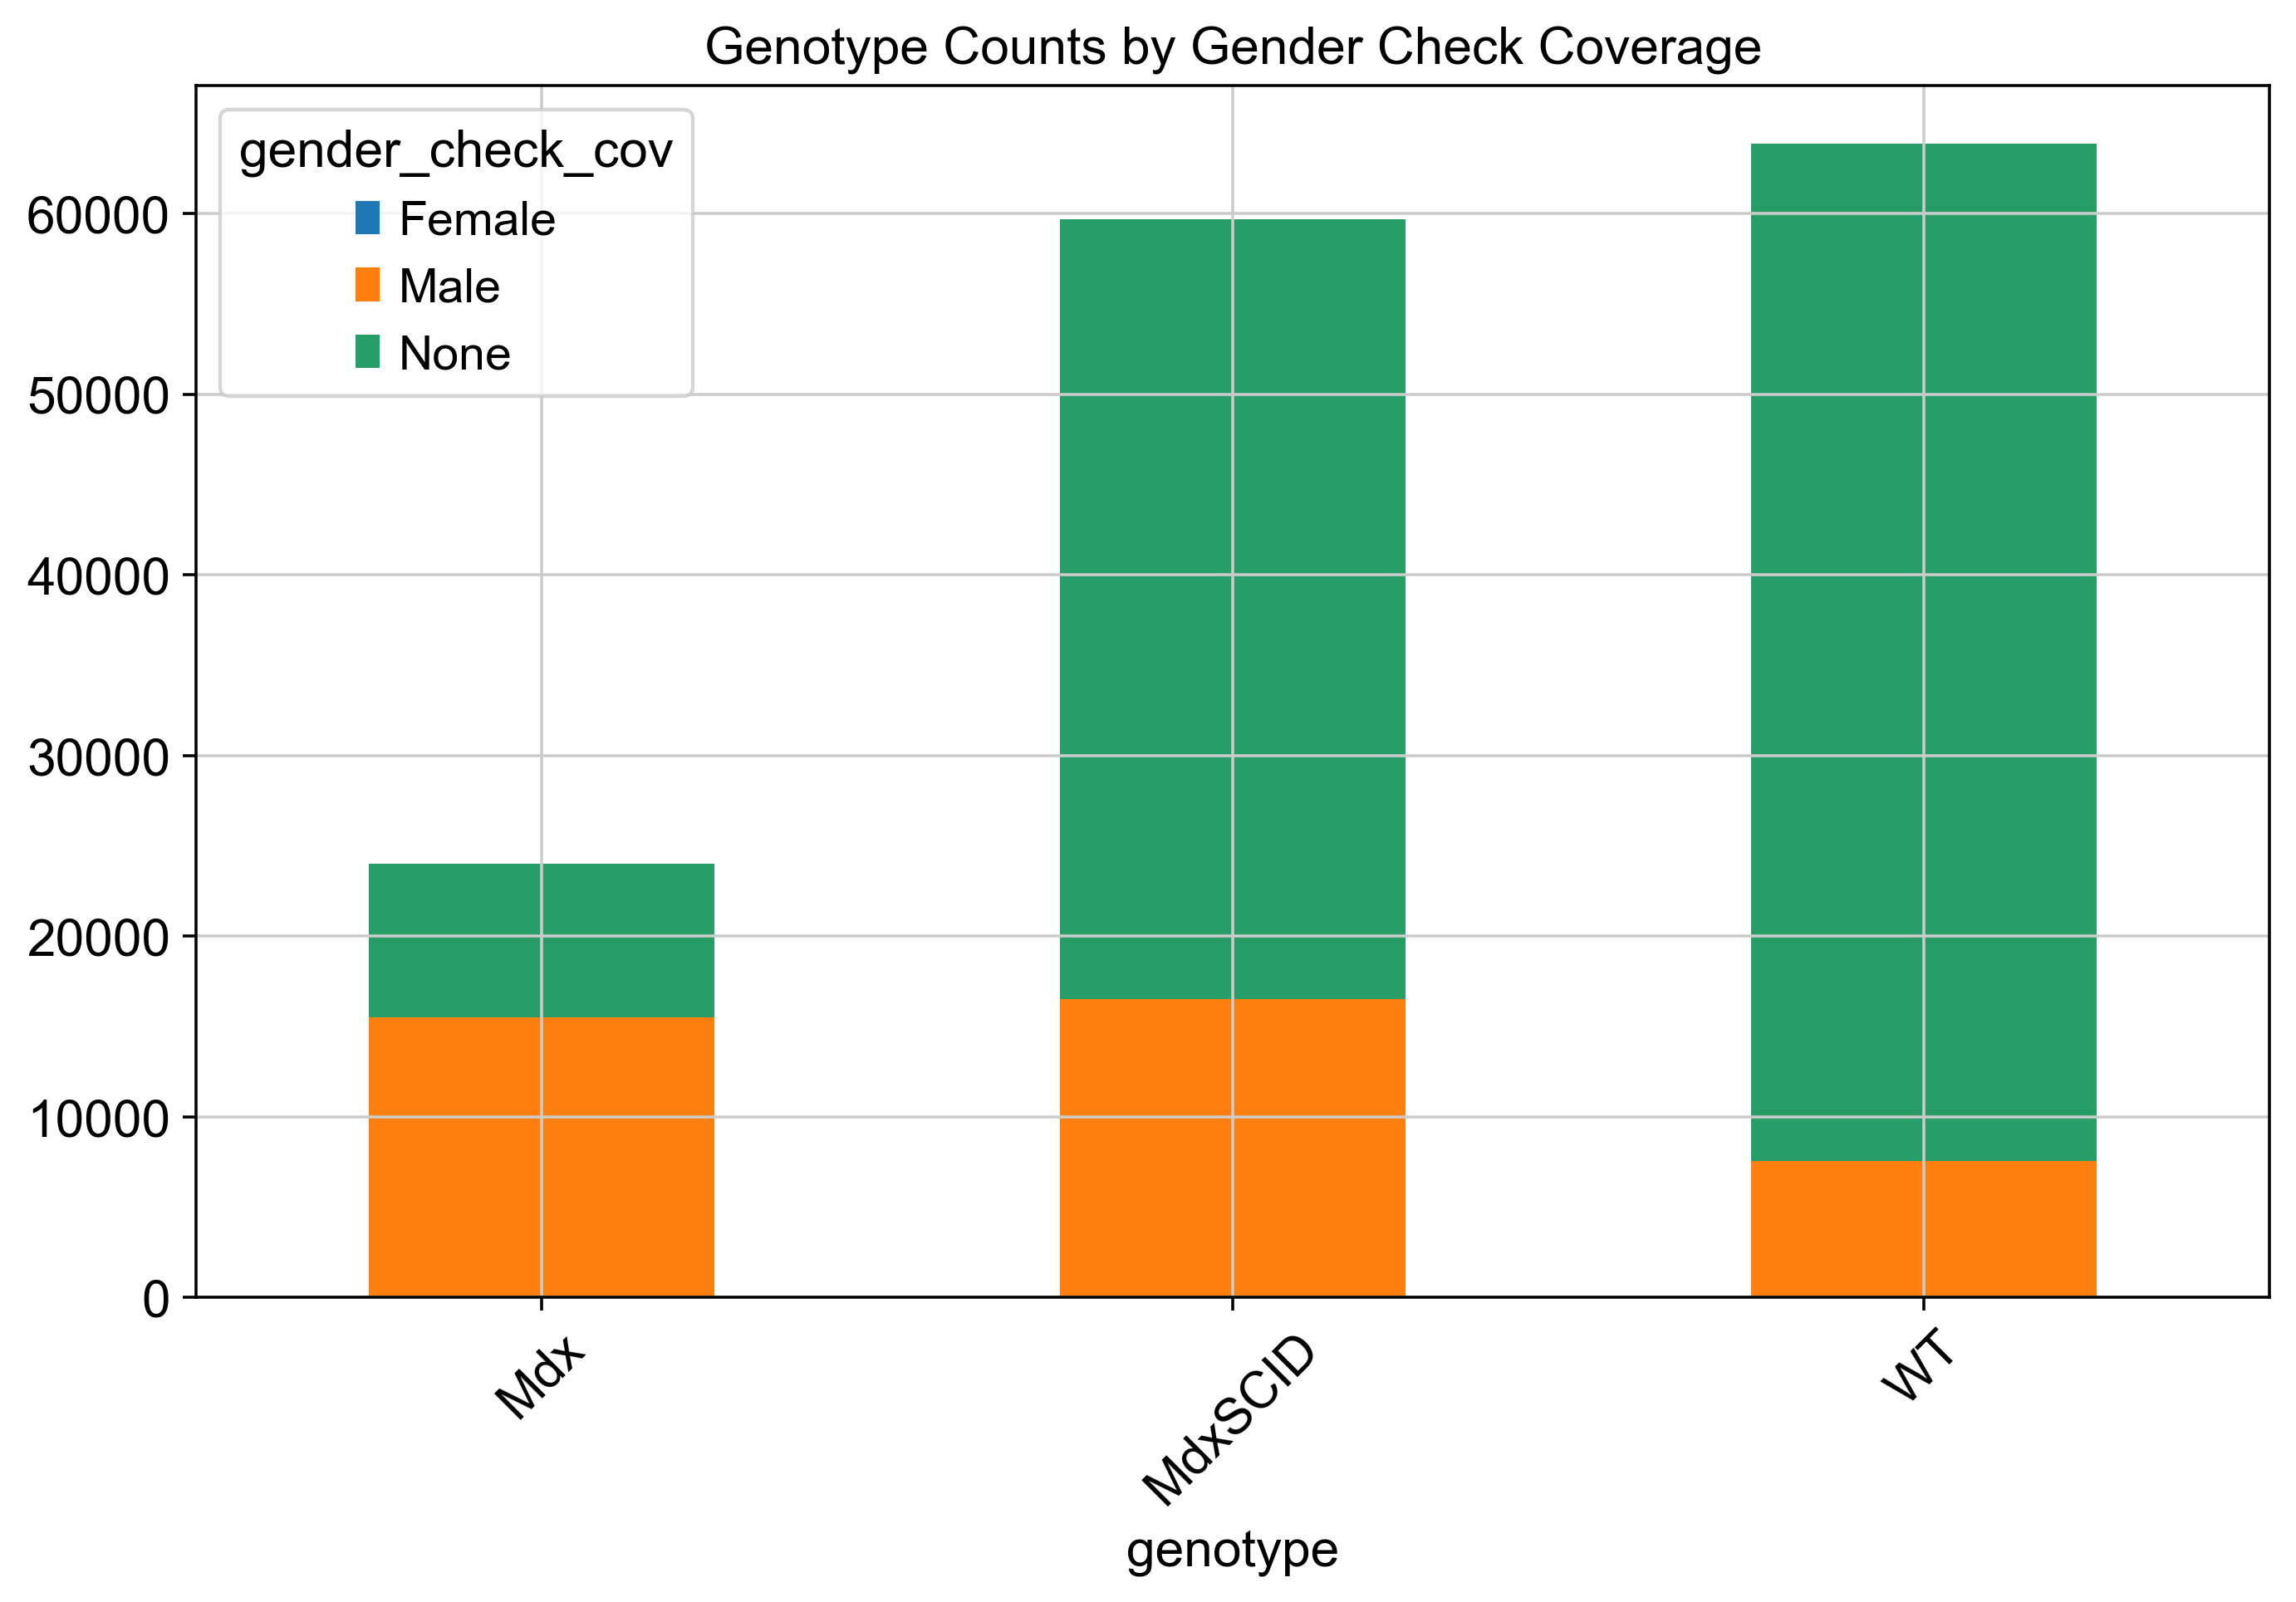

In [41]:
genotype_gender_counts = sample_object.obs.groupby(['genotype', 'gender_check_cov']).size().unstack(fill_value=0)

genotype_gender_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title("Genotype Counts by Gender Check Coverage")
plt.xticks(rotation=45)
plt.show()

## Calculate cell cycle scores

### Downloading the list of cell cycle genes

In [42]:
!if [ ! -f ../data/regev_lab_cell_cycle_genes.txt ]; then curl -o ../data/regev_lab_cell_cycle_genes.txt https://raw.githubusercontent.com/theislab/scanpy_usage/master/180209_cell_cycle/data/regev_lab_cell_cycle_genes.txt; fi

### Marking cell cycle genes

#### Steps followed

1. Loading genes and captilizing 
2. Printing the length of cell cycle genes list
3. Split genes into 2 lists (#First 43 genes,#Gene 43 to end)
4. Filtering cell cycle genes only if present in processed_gene_names
5. Print the list of cell cycle genes observed in our data

In [43]:
cell_cycle_genes = [x.strip() for x in open('../data/regev_lab_cell_cycle_genes.txt')]
cell_cycle_genes = [gene.capitalize() for gene in cell_cycle_genes]
print(len(cell_cycle_genes))

# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

cell_cycle_genes = [x for x in cell_cycle_genes if x in sample_object.var_names]
print(len(cell_cycle_genes))

97
94


In [44]:
cell_cycle_genes

['Mcm5',
 'Pcna',
 'Tyms',
 'Fen1',
 'Mcm2',
 'Mcm4',
 'Rrm1',
 'Ung',
 'Gins2',
 'Mcm6',
 'Cdca7',
 'Dtl',
 'Prim1',
 'Uhrf1',
 'Hells',
 'Rfc2',
 'Rpa2',
 'Nasp',
 'Rad51ap1',
 'Gmnn',
 'Wdr76',
 'Slbp',
 'Ccne2',
 'Ubr7',
 'Pold3',
 'Msh2',
 'Atad2',
 'Rad51',
 'Rrm2',
 'Cdc45',
 'Cdc6',
 'Exo1',
 'Tipin',
 'Dscc1',
 'Blm',
 'Casp8ap2',
 'Usp1',
 'Clspn',
 'Pola1',
 'Chaf1b',
 'Brip1',
 'E2f8',
 'Hmgb2',
 'Cdk1',
 'Nusap1',
 'Ube2c',
 'Birc5',
 'Tpx2',
 'Top2a',
 'Ndc80',
 'Cks2',
 'Nuf2',
 'Cks1b',
 'Mki67',
 'Tmpo',
 'Cenpf',
 'Tacc3',
 'Smc4',
 'Ccnb2',
 'Ckap2l',
 'Ckap2',
 'Aurkb',
 'Bub1',
 'Kif11',
 'Anp32e',
 'Tubb4b',
 'Gtse1',
 'Kif20b',
 'Hjurp',
 'Cdca3',
 'Cdc20',
 'Ttk',
 'Cdc25c',
 'Kif2c',
 'Rangap1',
 'Ncapd2',
 'Dlgap5',
 'Cdca2',
 'Cdca8',
 'Ect2',
 'Kif23',
 'Hmmr',
 'Aurka',
 'Psrc1',
 'Anln',
 'Lbr',
 'Ckap5',
 'Cenpe',
 'Ctcf',
 'Nek2',
 'G2e3',
 'Gas2l3',
 'Cbx5',
 'Cenpa']

### Creating basic anndata and normalization for cell cycle score calculation

In [45]:
adata_log = anndata.AnnData(X = sample_object.X,  var = sample_object.var, obs = sample_object.obs)
sc.pp.normalize_total(adata_log, target_sum = 1e6, exclude_highly_expressed = True)
sc.pp.log1p(adata_log)

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['Fhl2', 'Col3a1', 'Plcl1', 'Igfbp5', 'Pid1', 'Tnnt2', 'Camk1d', 'Celf2', 'Gsn', 'Zeb2', 'Xirp2', 'Ttn', 'Fbn1', 'Plcb1', 'Plcb4', 'Tshz2', 'Fabp4', 'Lhfp', 'S100a9', 'Ank2', 'Ptprd', 'Nppa', 'Rbpj', 'Pcdh7', 'Myl2', 'Eln', 'Col1a2', 'Thsd7a', 'Chrm2', 'Cacna1c', 'Mgp', 'Nav2', 'Dlg2', 'Hbb-bt', 'Hbb-bs', 'Tacc2', 'Csmd1', 'Nrg1', 'Dlc1', 'Sorbs2', 'Palld', 'Cdh13', 'Tpm1', 'Rora', 'Slc9a9', 'Tmem108', 'Pde7b', 'Ctnna3', 'Dcn', 'Sptbn1', 'Hba-a1', 'Hba-a2', 'Ebf1', 'Col1a1', 'Meg3', 'Rian', 'Ighm', 'Ryr2', 'Cmah', 'F13a1', 'Mctp1', 'Pde8b', 'Mast4', 'Pde4d', 'Arl15', 'Ptprg', 'Myh6', 'Gpc6', 'Zbtb20', 'Cmss1', 'Col8a1', 'Airn', 'Gm26917', 'Gm42418', 'Rcan2', 'Slc8a1', 'Malat1', 'Prkg1', 'Sorbs1', 'Rbm20', 'Ablim1', 'Fgf13', 'Dmd', 'Tmsb4x', 'mt-Nd1', 'mt-Nd2', 'mt-Co1', 'mt-Co2', 'mt-Atp6', 'mt-Co3', 'mt-Nd4', 'mt-Cytb']
    finished (0:00:00)


### Cell cycle score calculation

In [46]:
sc.tl.score_genes_cell_cycle(adata_log, s_genes = s_genes, g2m_genes = g2m_genes)

sample_object.obs['S_score'] = adata_log.obs['S_score']
sample_object.obs['G2M_score'] = adata_log.obs['G2M_score']
sample_object.obs['phase'] = adata_log.obs['phase']

sample_object

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    430 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    602 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


AnnData object with n_obs × n_vars = 147520 × 32285
    obs: 'sample', 'genotype', 'batch', 'n_genes', 'doublet_scores', 'predicted_doublets', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts_per_cell', 'percent_chrY', 'XIST-counts', 'XIST-percentage', 'gender_check_cov', 'S_score', 'G2M_score', 'phase'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'sample_colors'

In [47]:
cell_cycle_counts = sample_object.obs['phase'].value_counts()

cell_cycle_counts

phase
G1     73194
S      38032
G2M    36294
Name: count, dtype: int64

<Axes: xlabel='phase', ylabel='count'>

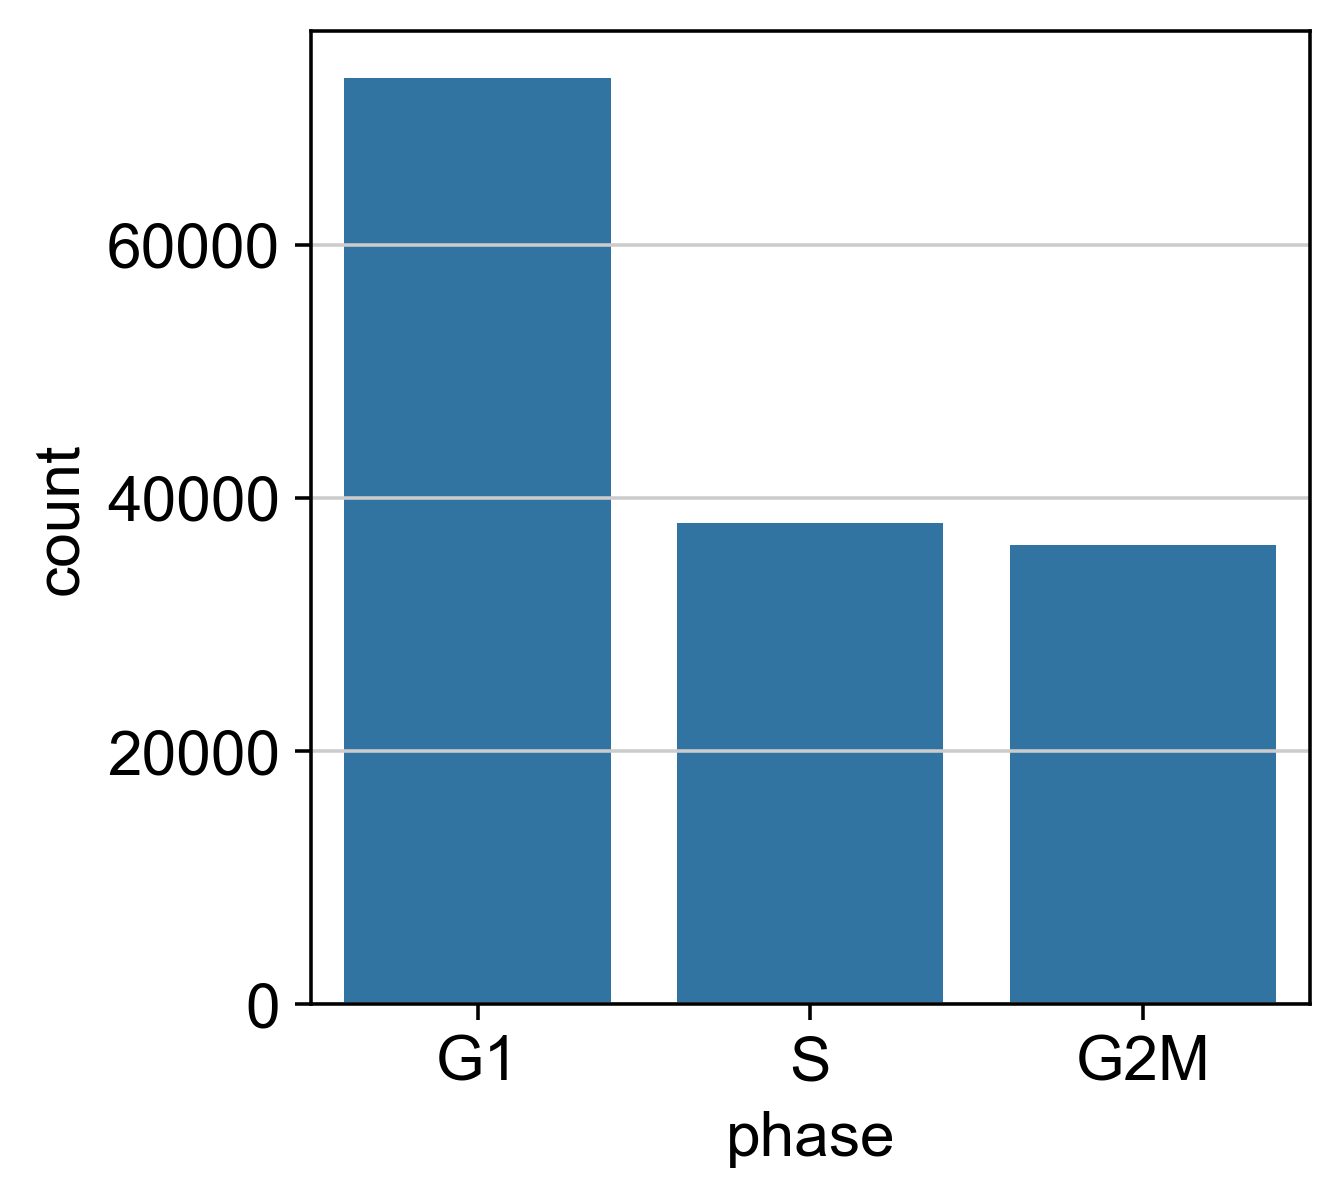

In [48]:
sb.countplot(data=sample_object.obs, x='phase')

<Axes: xlabel='sample', ylabel='count'>

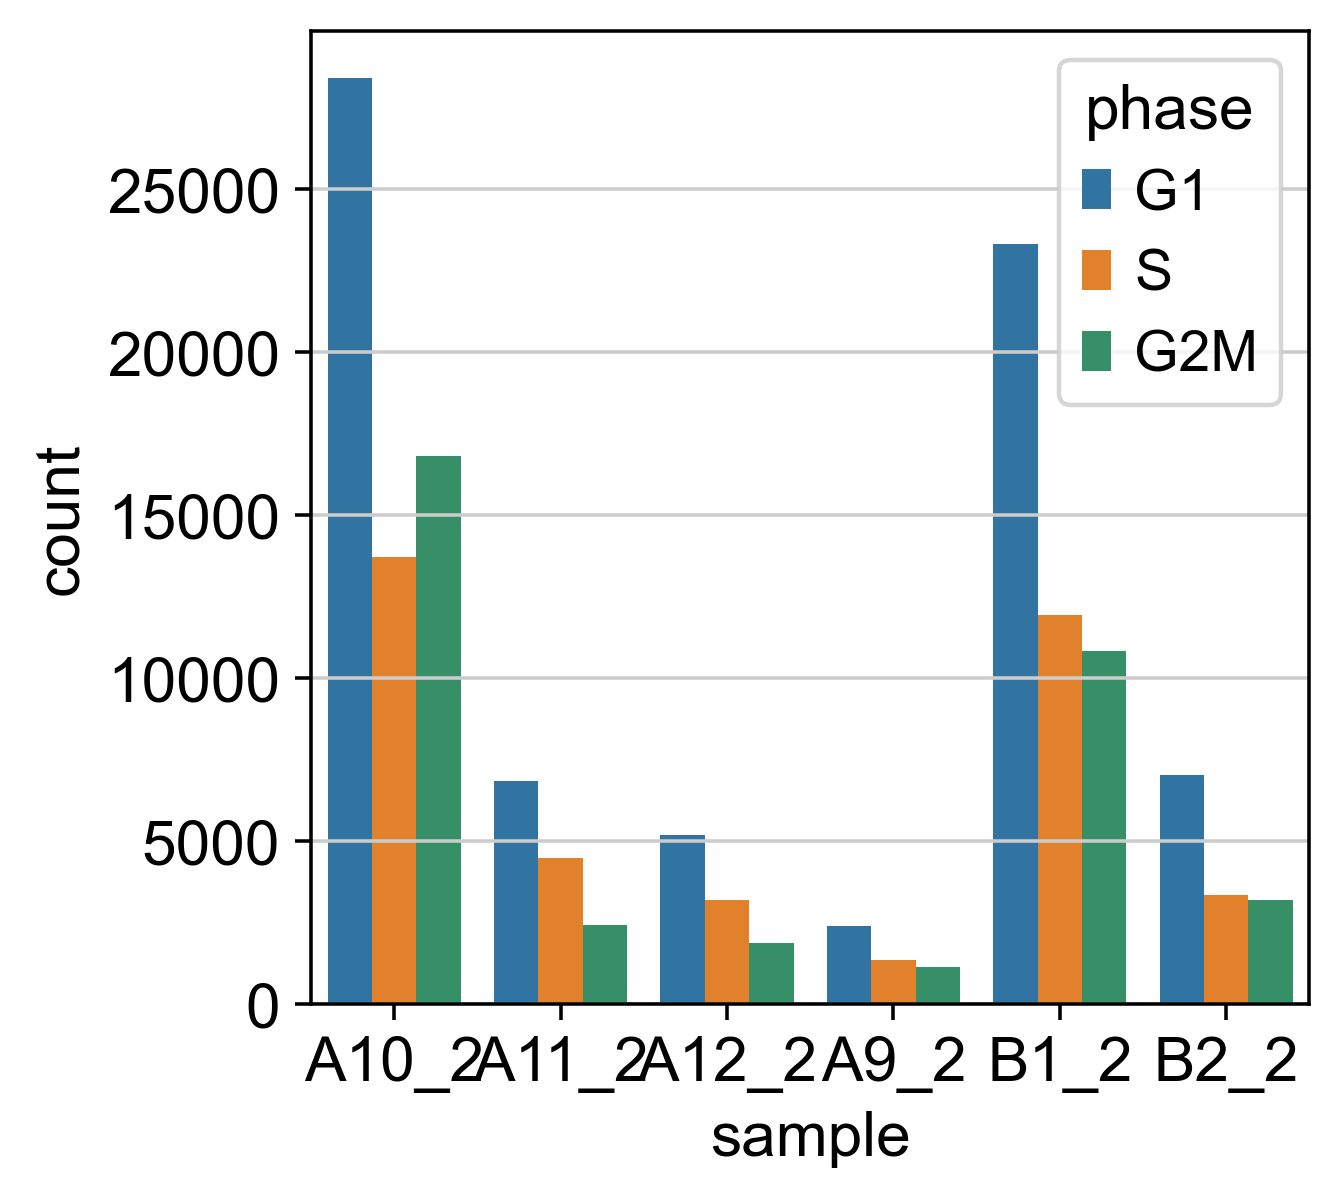

In [49]:
sb.countplot(data=sample_object.obs, x='sample', hue= 'phase')

## Data visualization

/var/folders/m6/j4jl72rj0pl7_bbwngtxl9ym0000gn/T/ipykernel_55926/2687336048.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  medians = sample_object.obs.groupby('sample')[var].median()


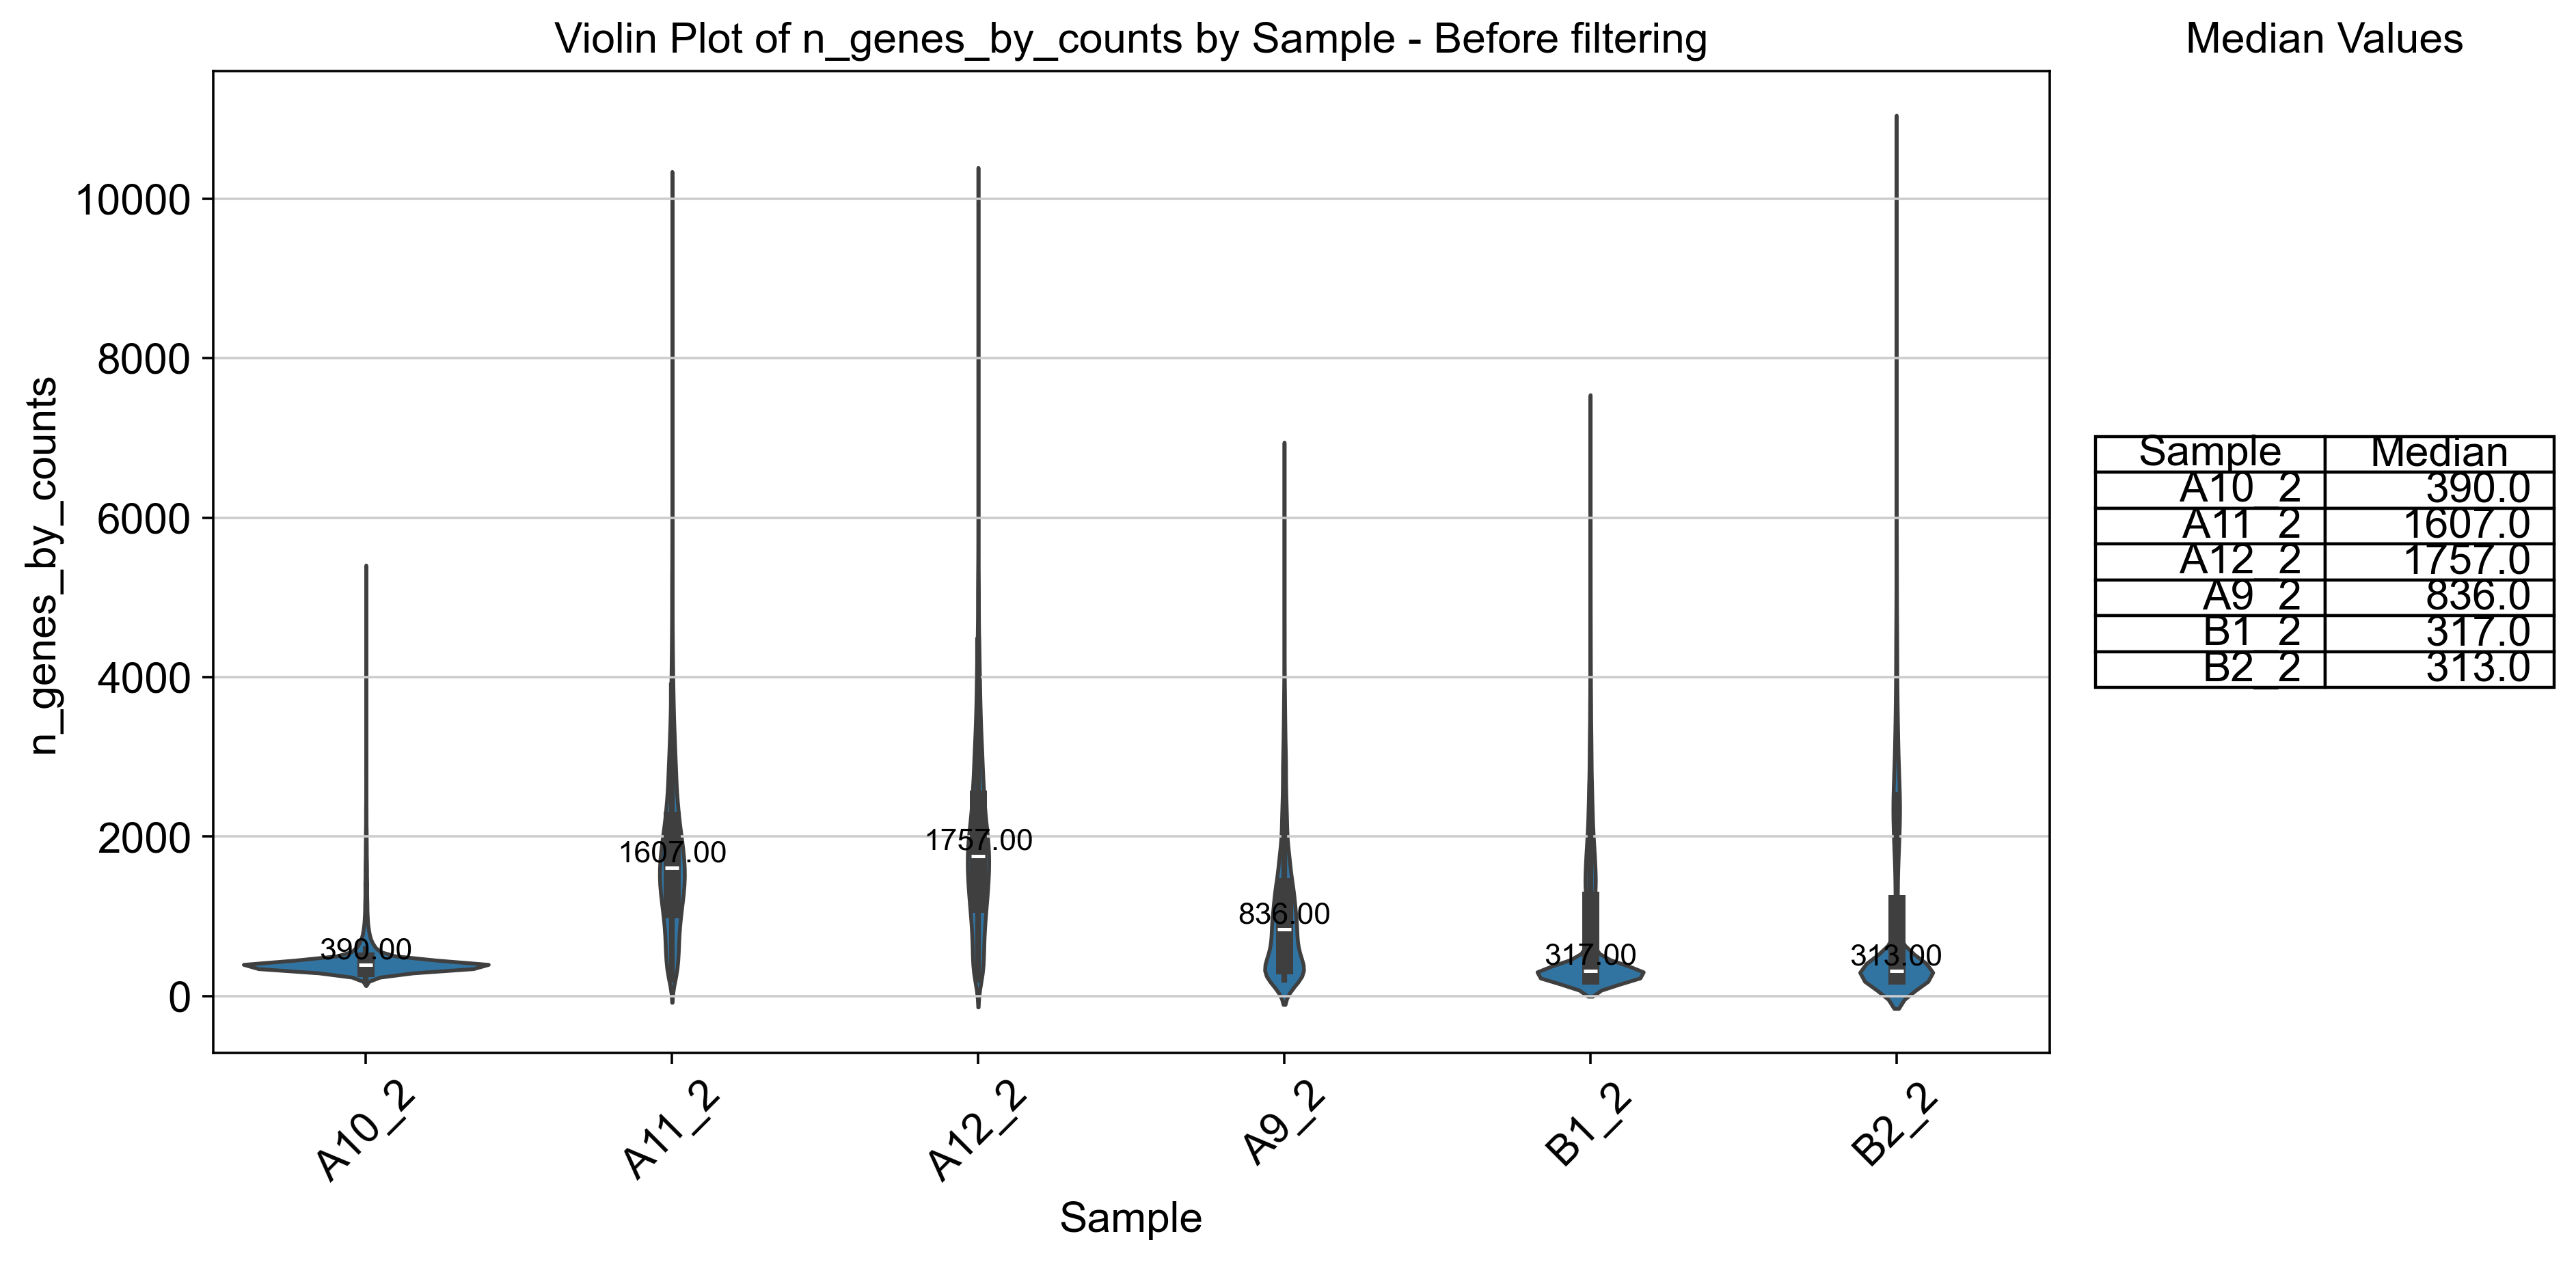

/var/folders/m6/j4jl72rj0pl7_bbwngtxl9ym0000gn/T/ipykernel_55926/2687336048.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  medians = sample_object.obs.groupby('sample')[var].median()


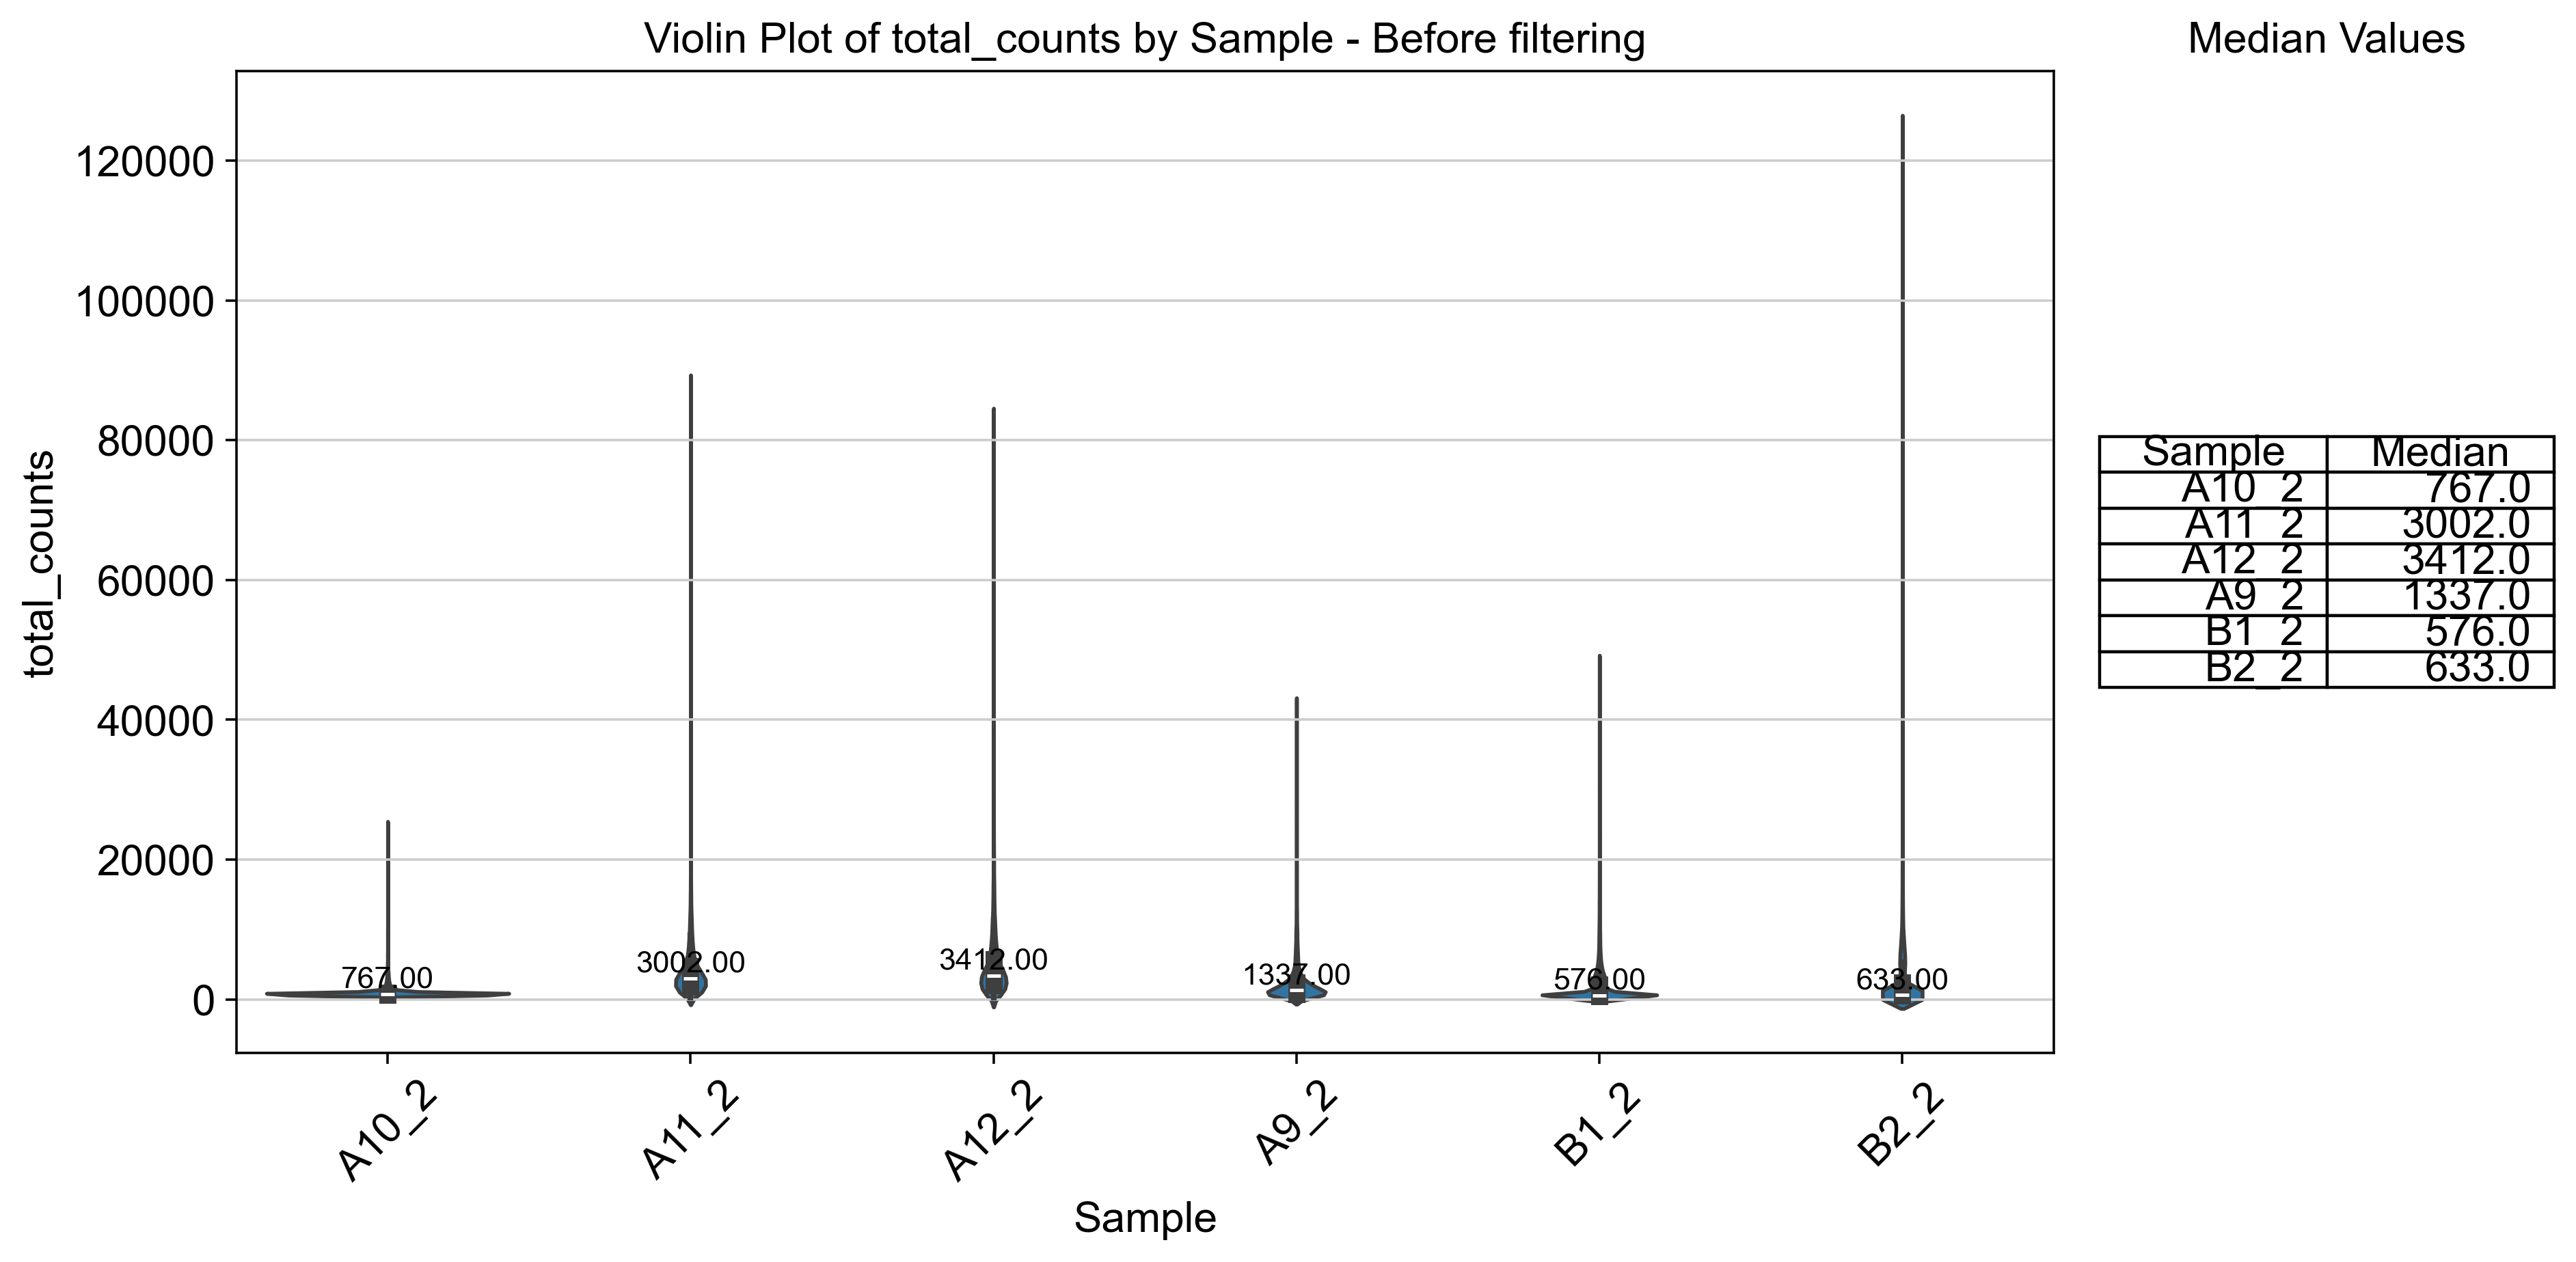

/var/folders/m6/j4jl72rj0pl7_bbwngtxl9ym0000gn/T/ipykernel_55926/2687336048.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  medians = sample_object.obs.groupby('sample')[var].median()


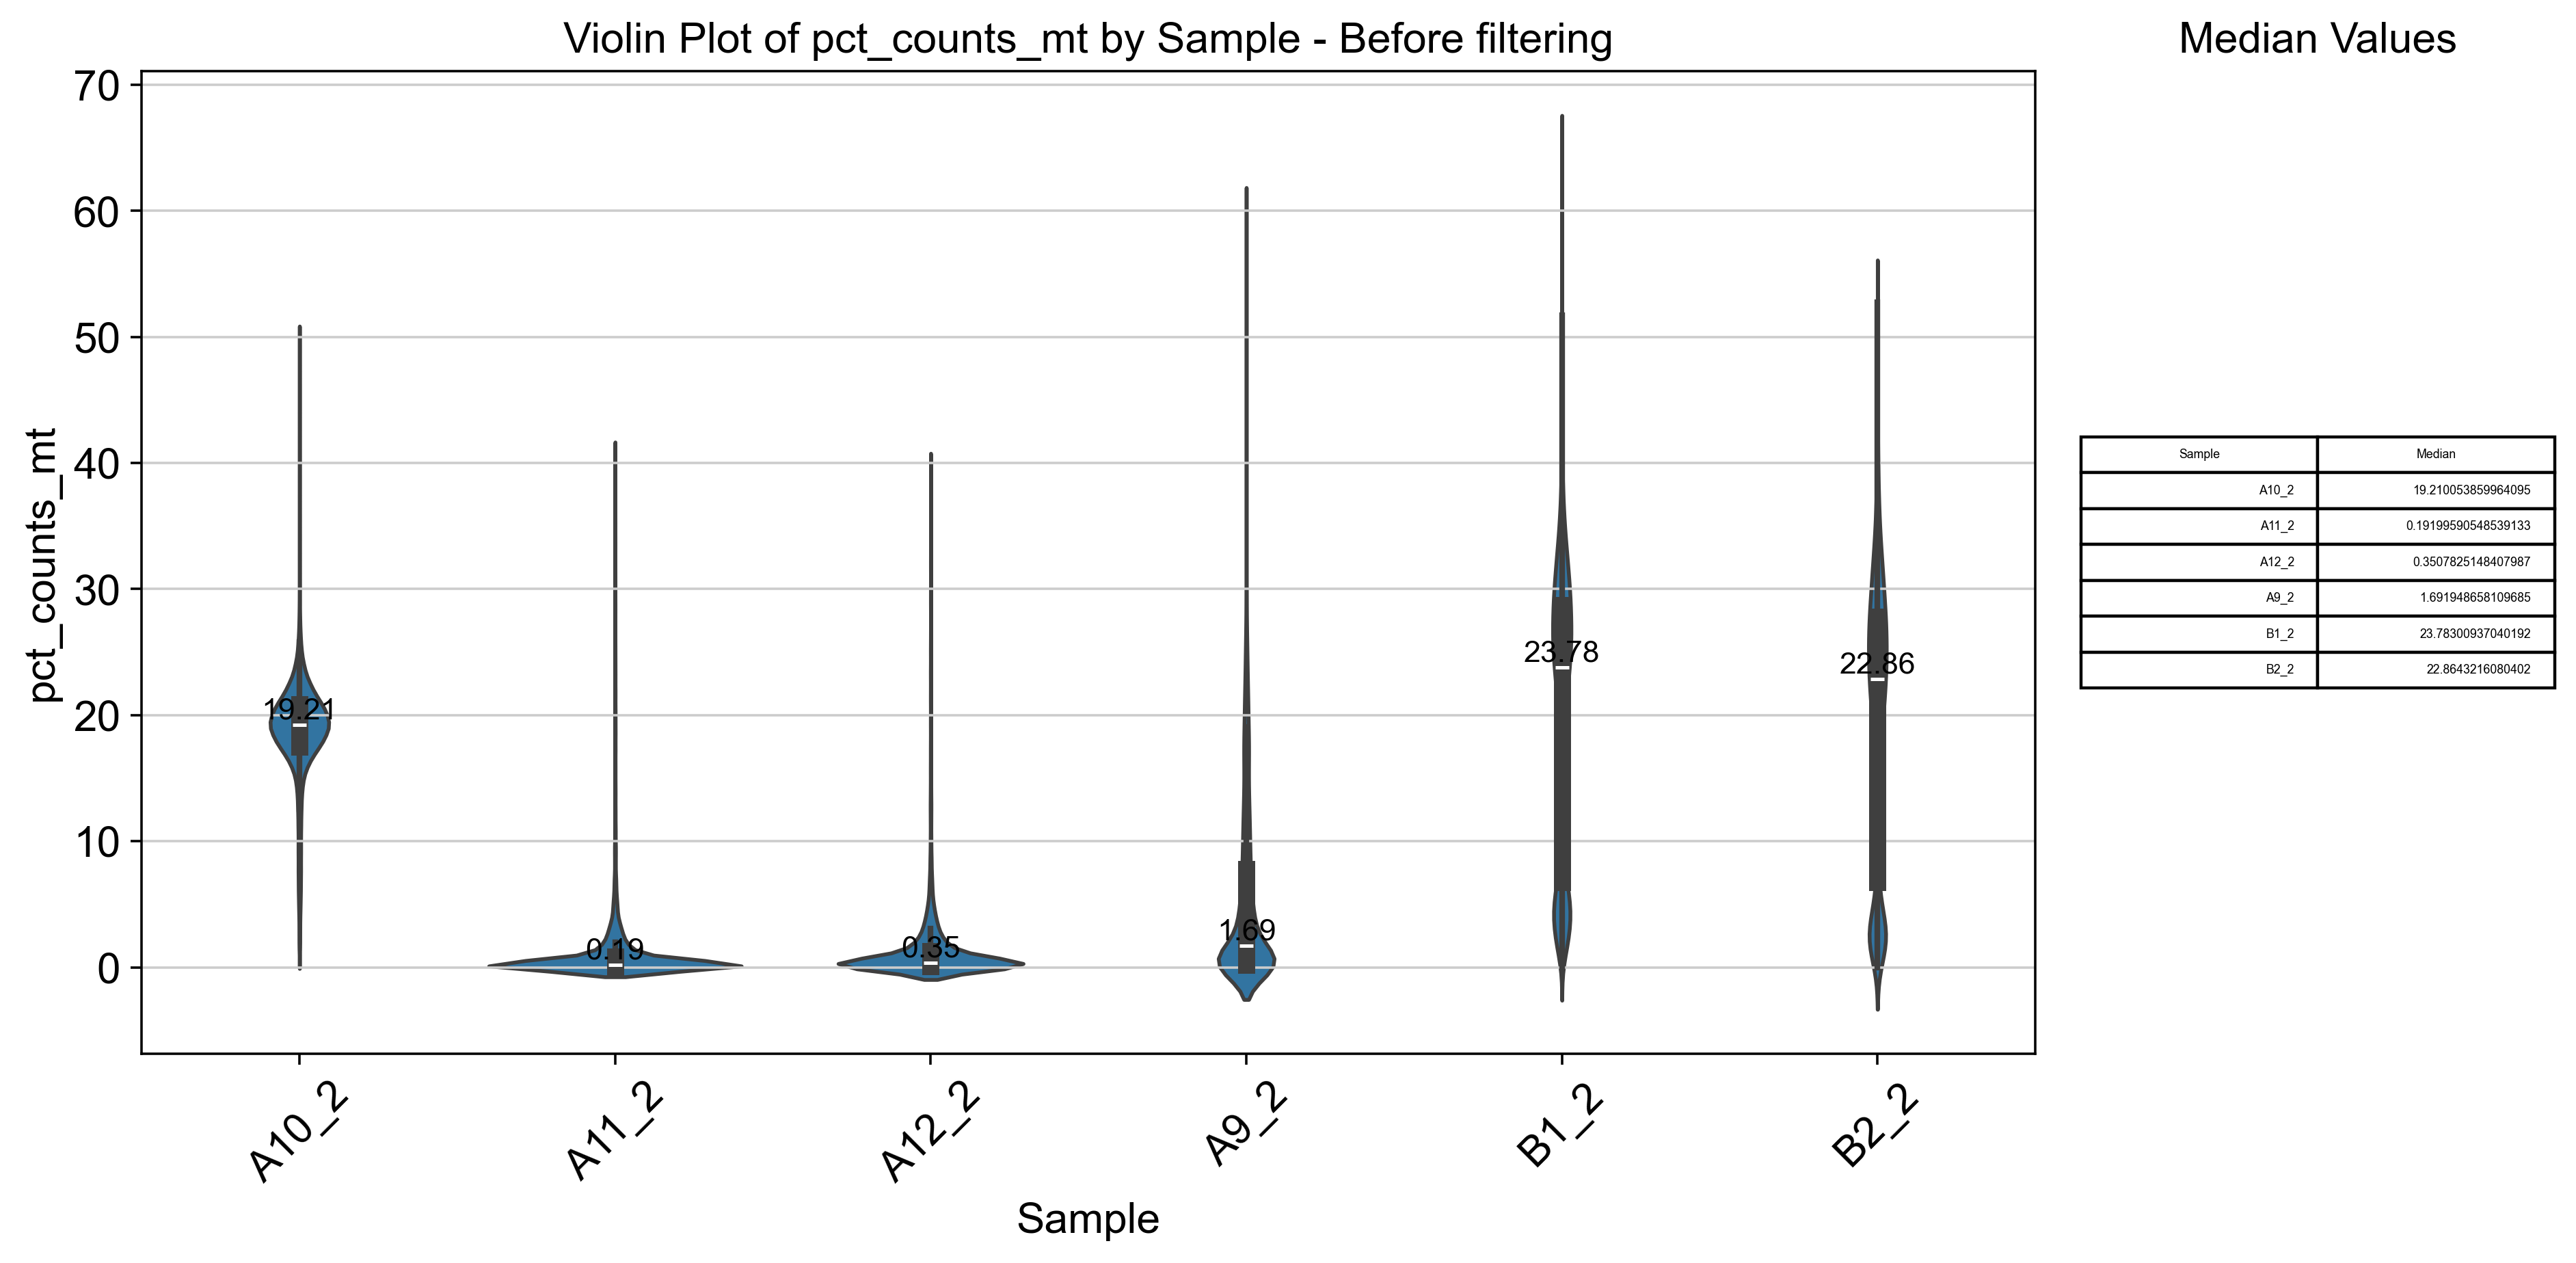

/var/folders/m6/j4jl72rj0pl7_bbwngtxl9ym0000gn/T/ipykernel_55926/2687336048.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  medians = sample_object.obs.groupby('sample')[var].median()


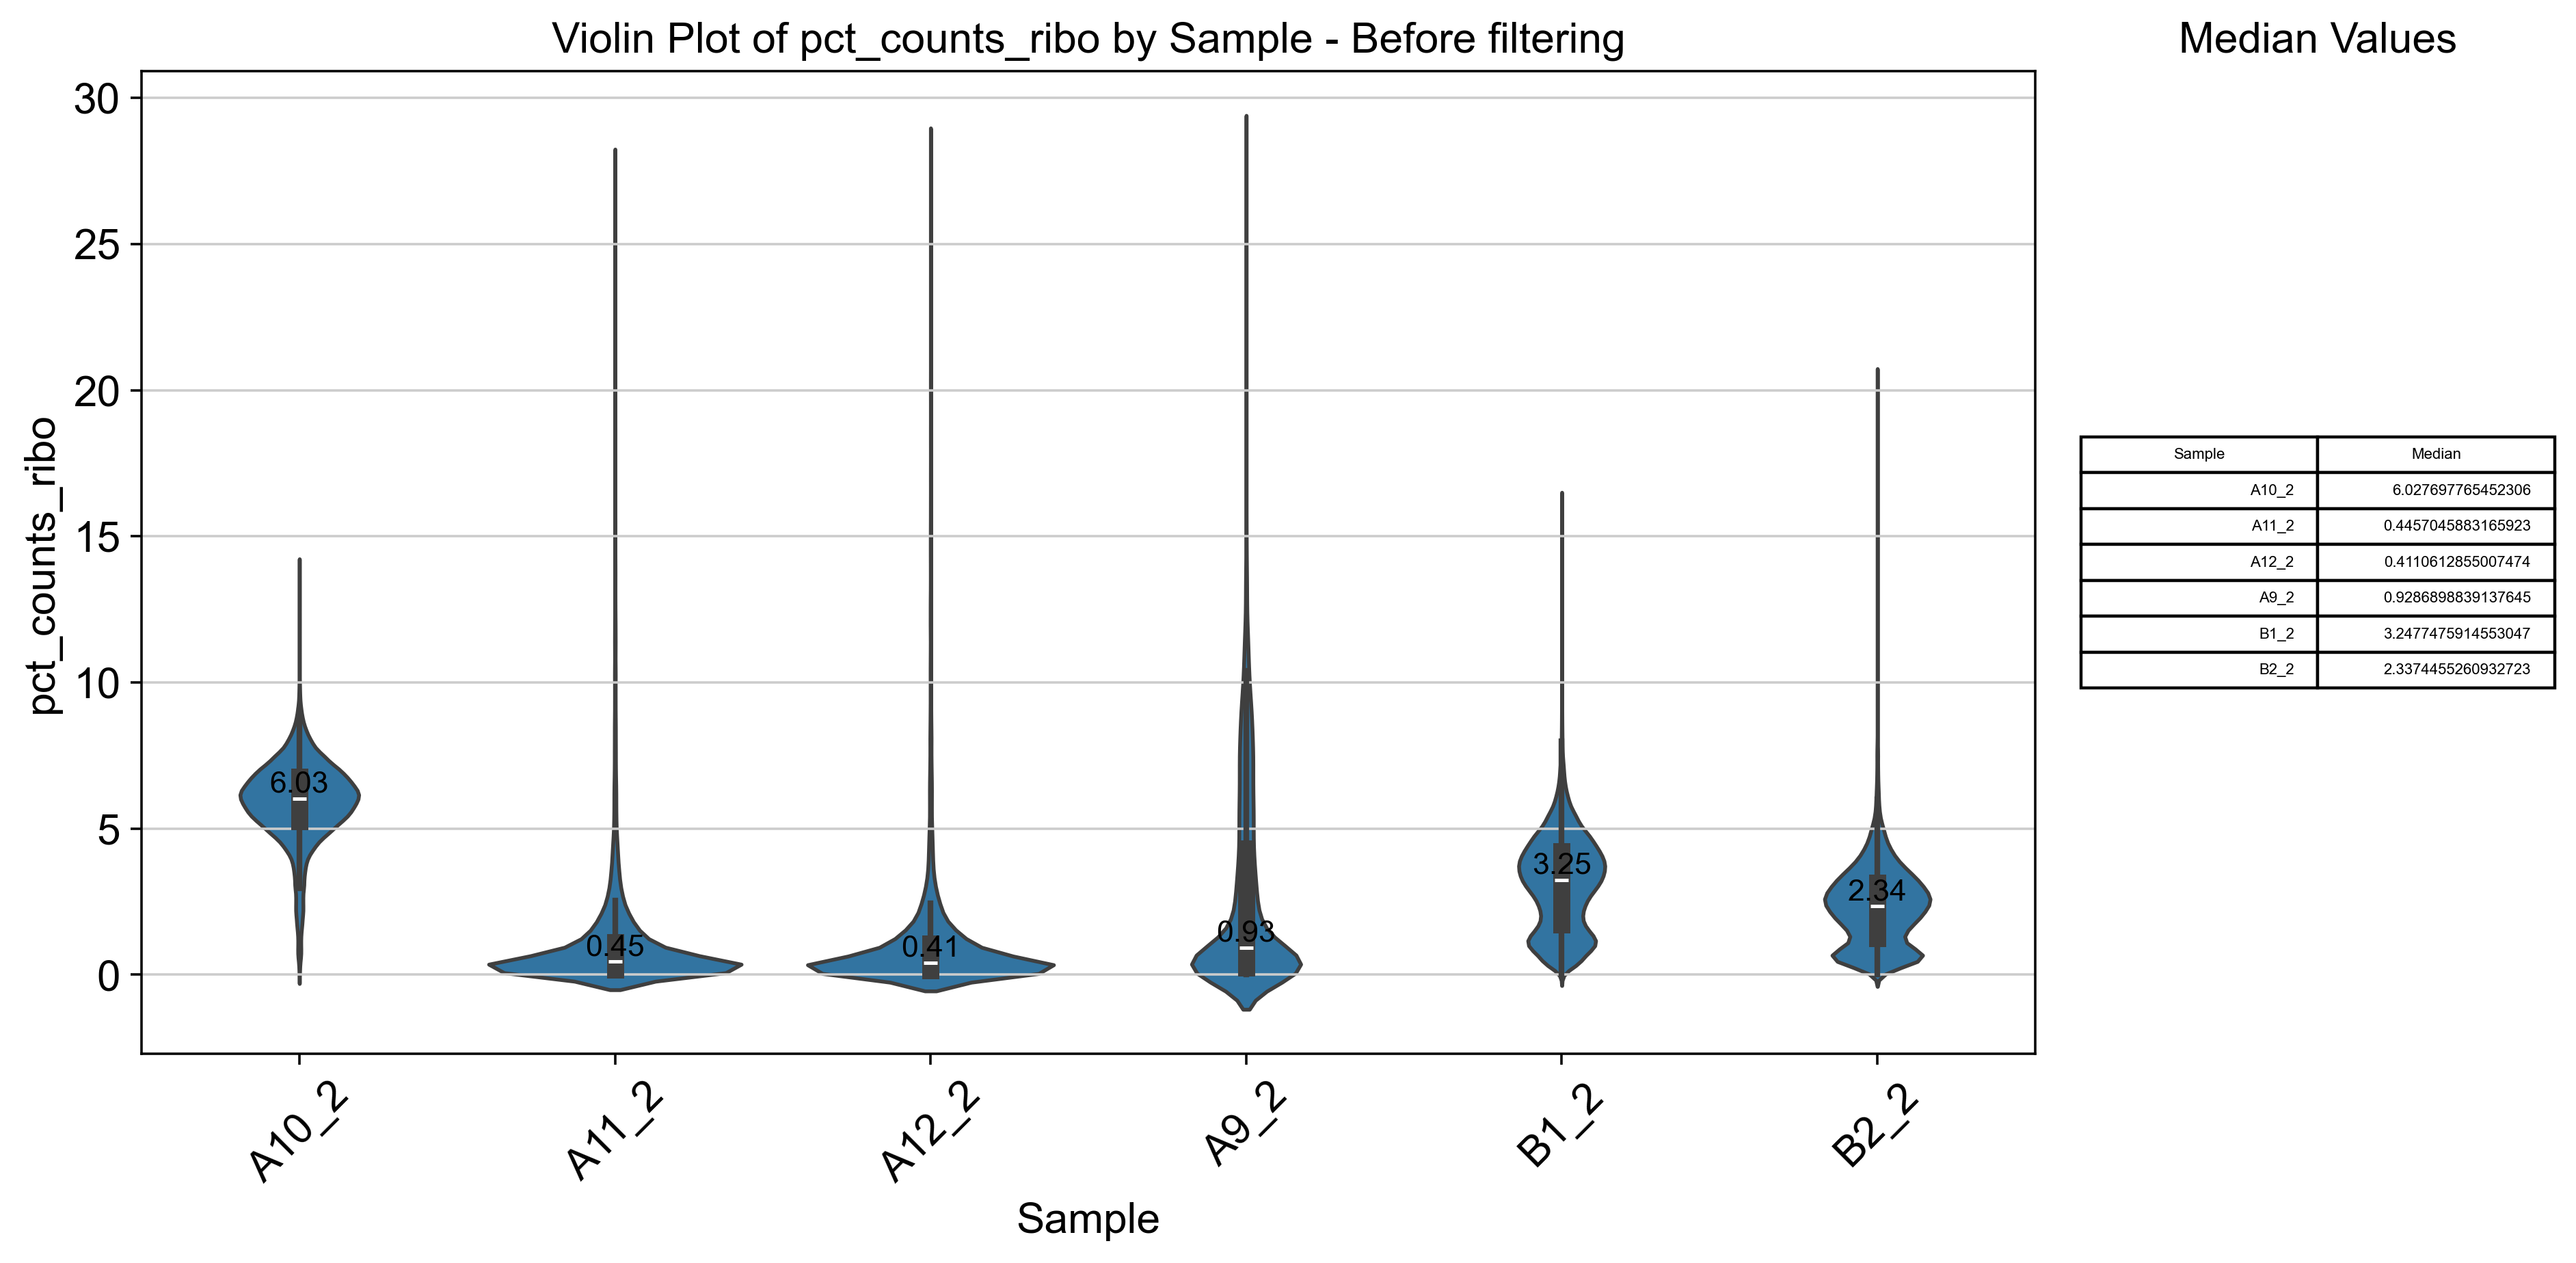

/var/folders/m6/j4jl72rj0pl7_bbwngtxl9ym0000gn/T/ipykernel_55926/2687336048.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  medians = sample_object.obs.groupby('sample')[var].median()


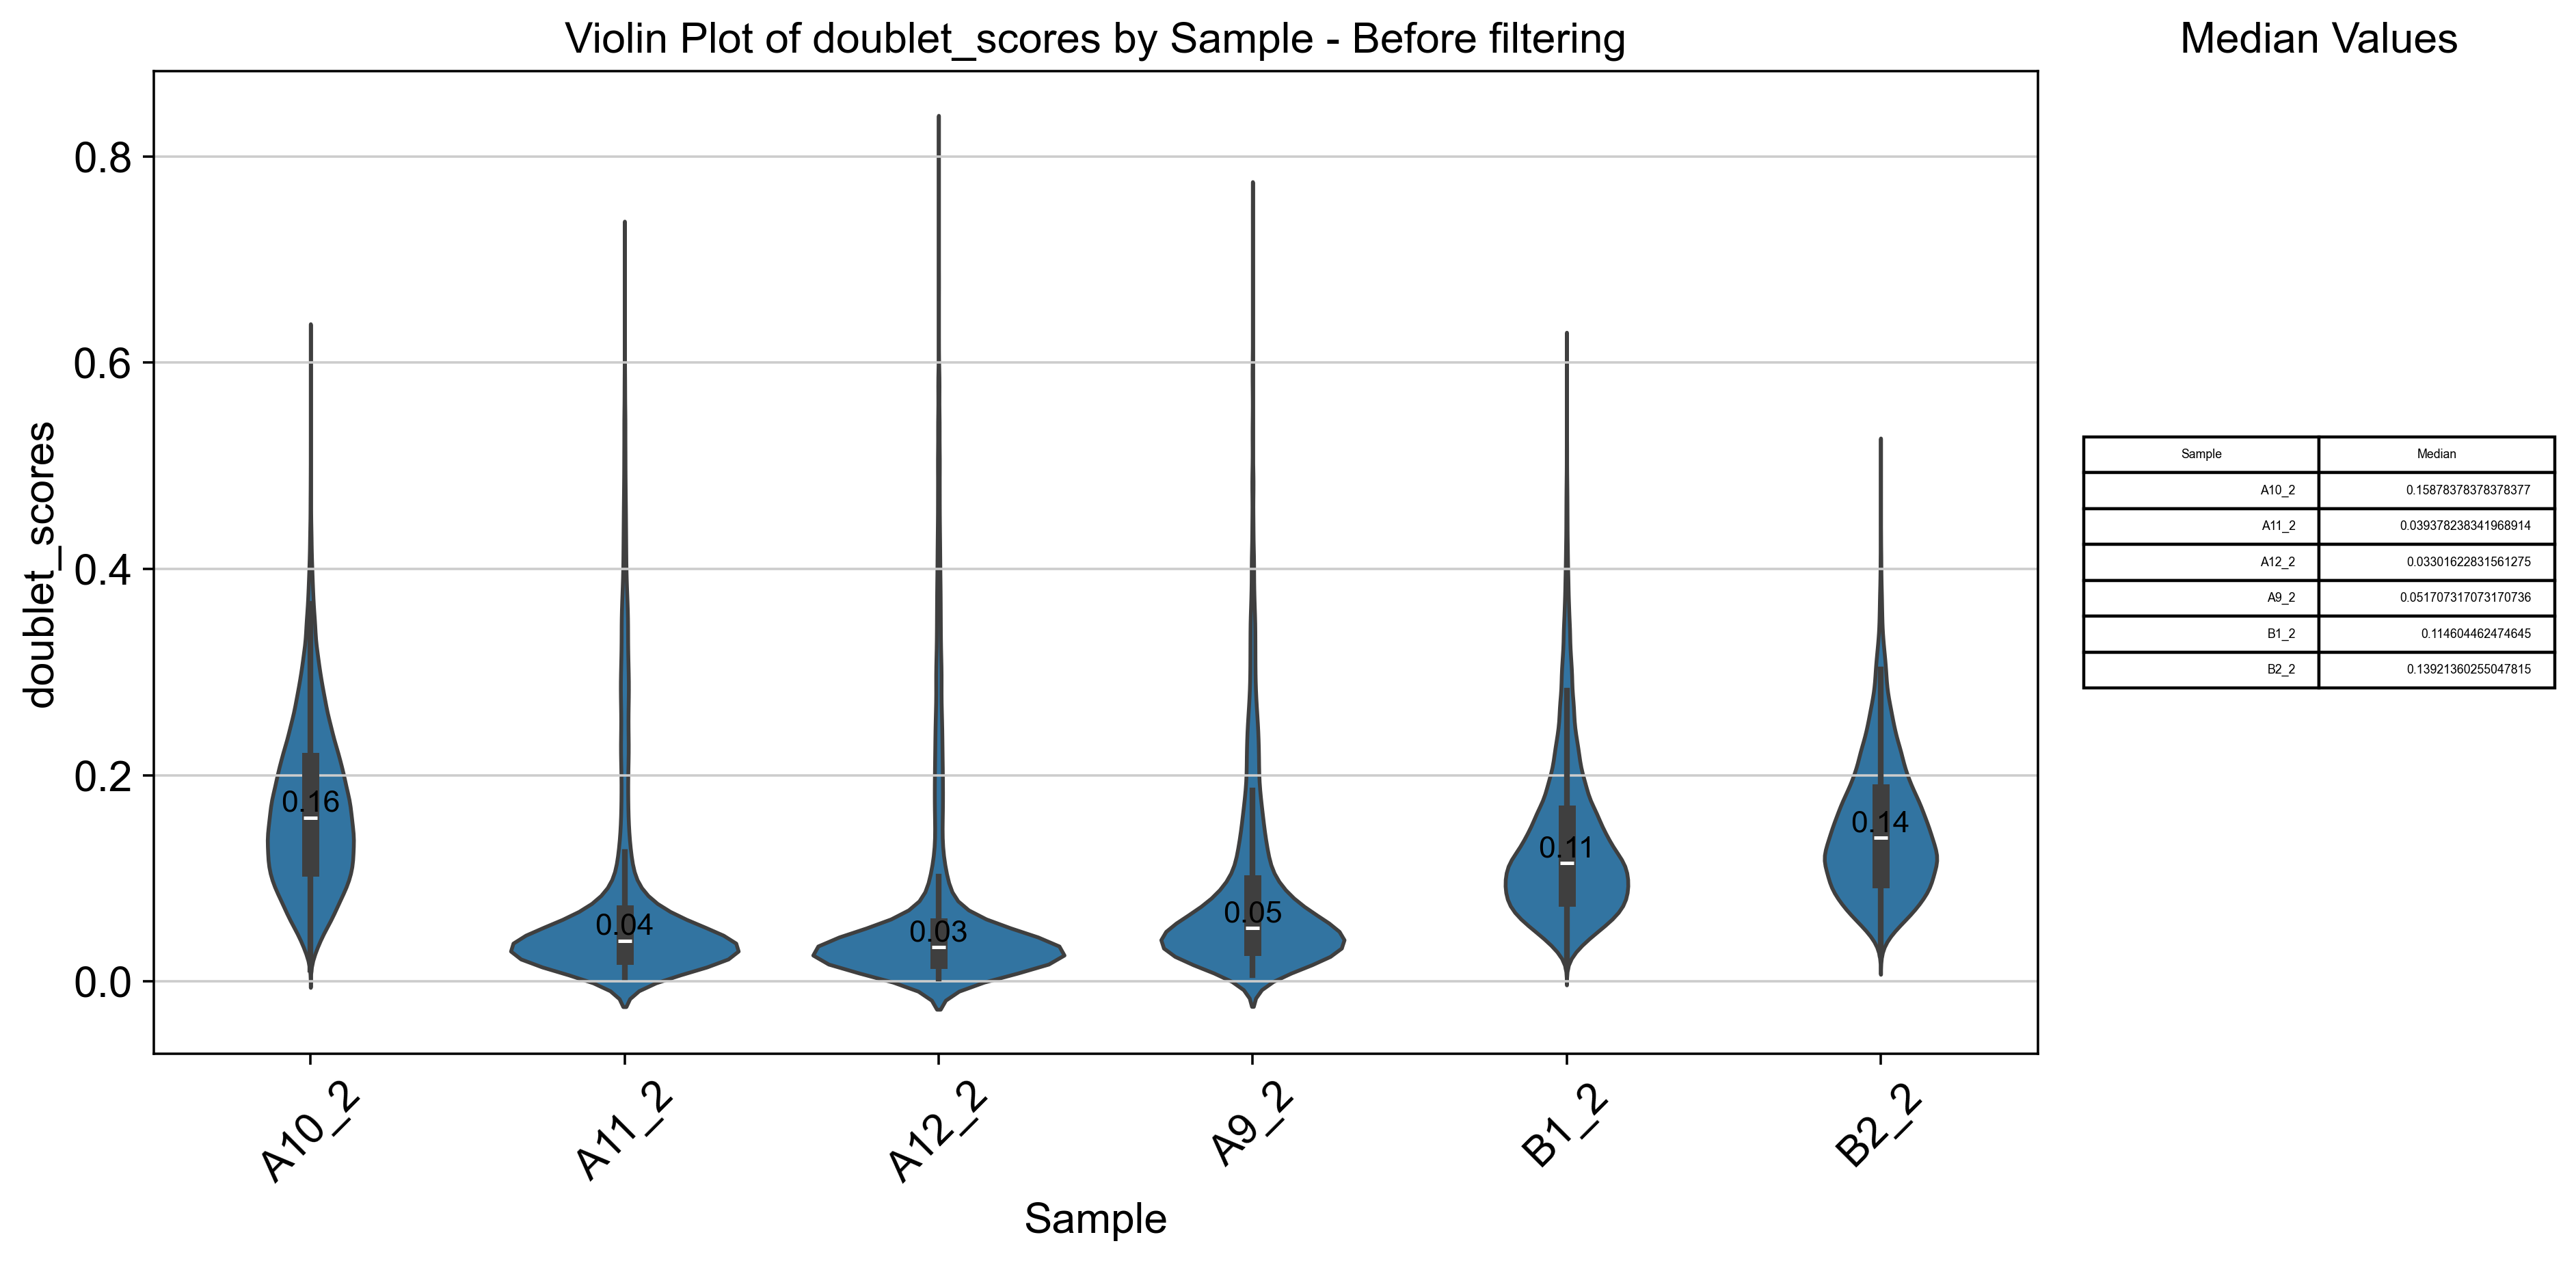

/var/folders/m6/j4jl72rj0pl7_bbwngtxl9ym0000gn/T/ipykernel_55926/2687336048.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  medians = sample_object.obs.groupby('sample')[var].median()


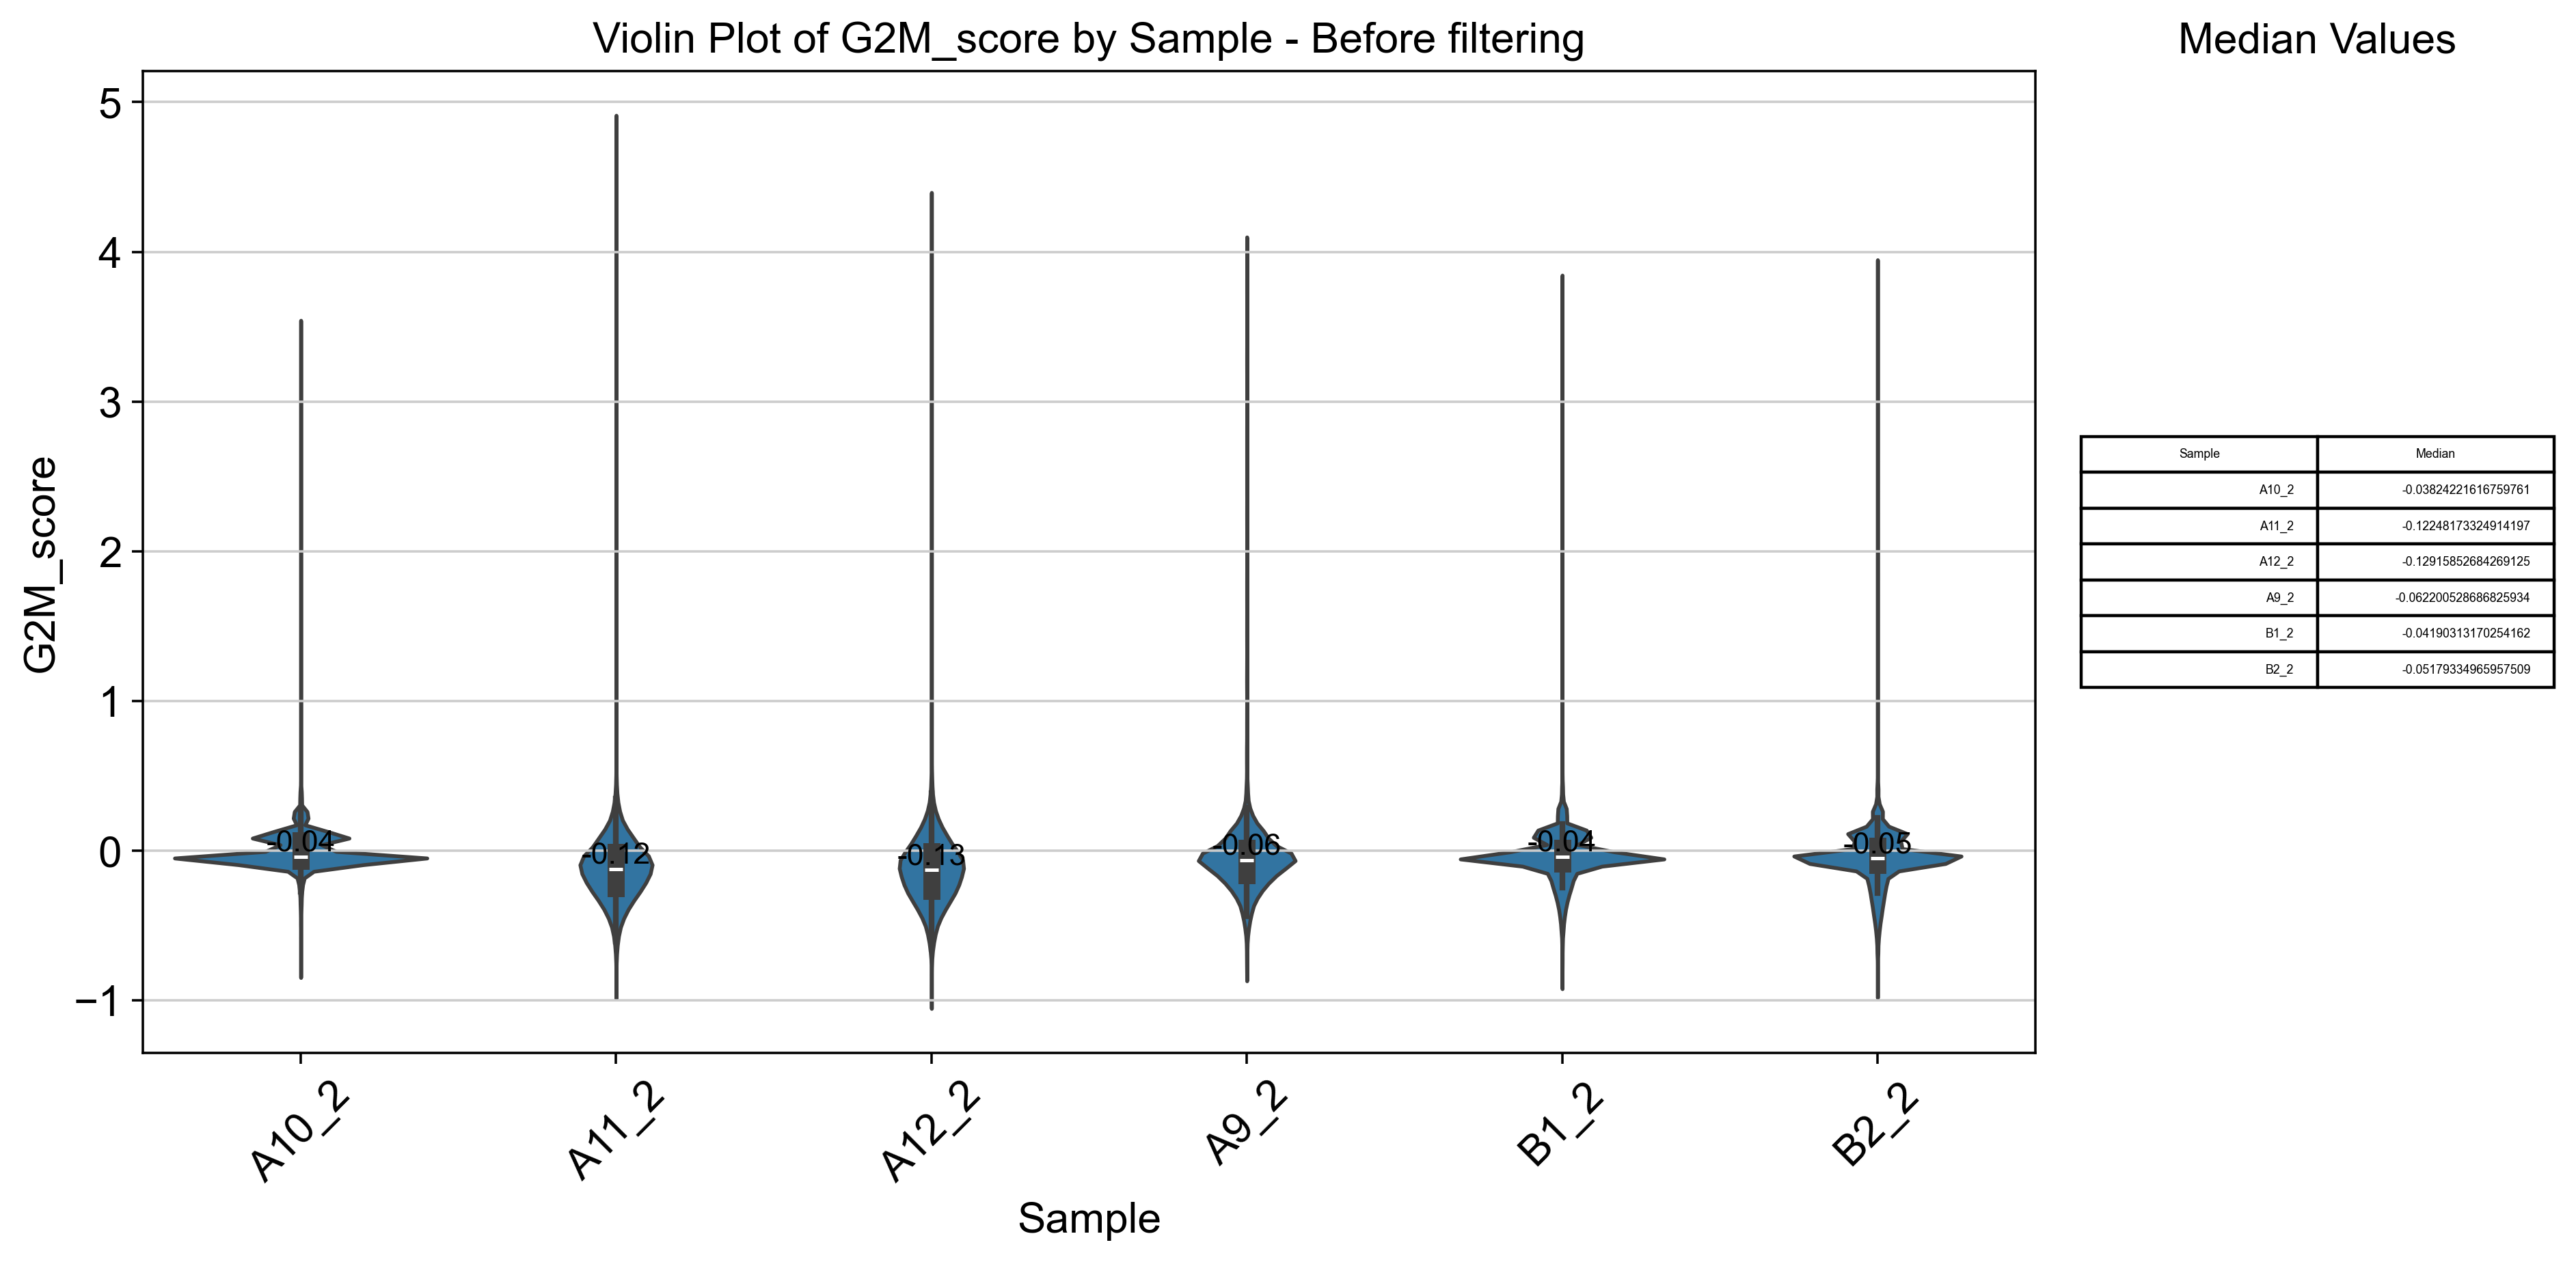

/var/folders/m6/j4jl72rj0pl7_bbwngtxl9ym0000gn/T/ipykernel_55926/2687336048.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  medians = sample_object.obs.groupby('sample')[var].median()


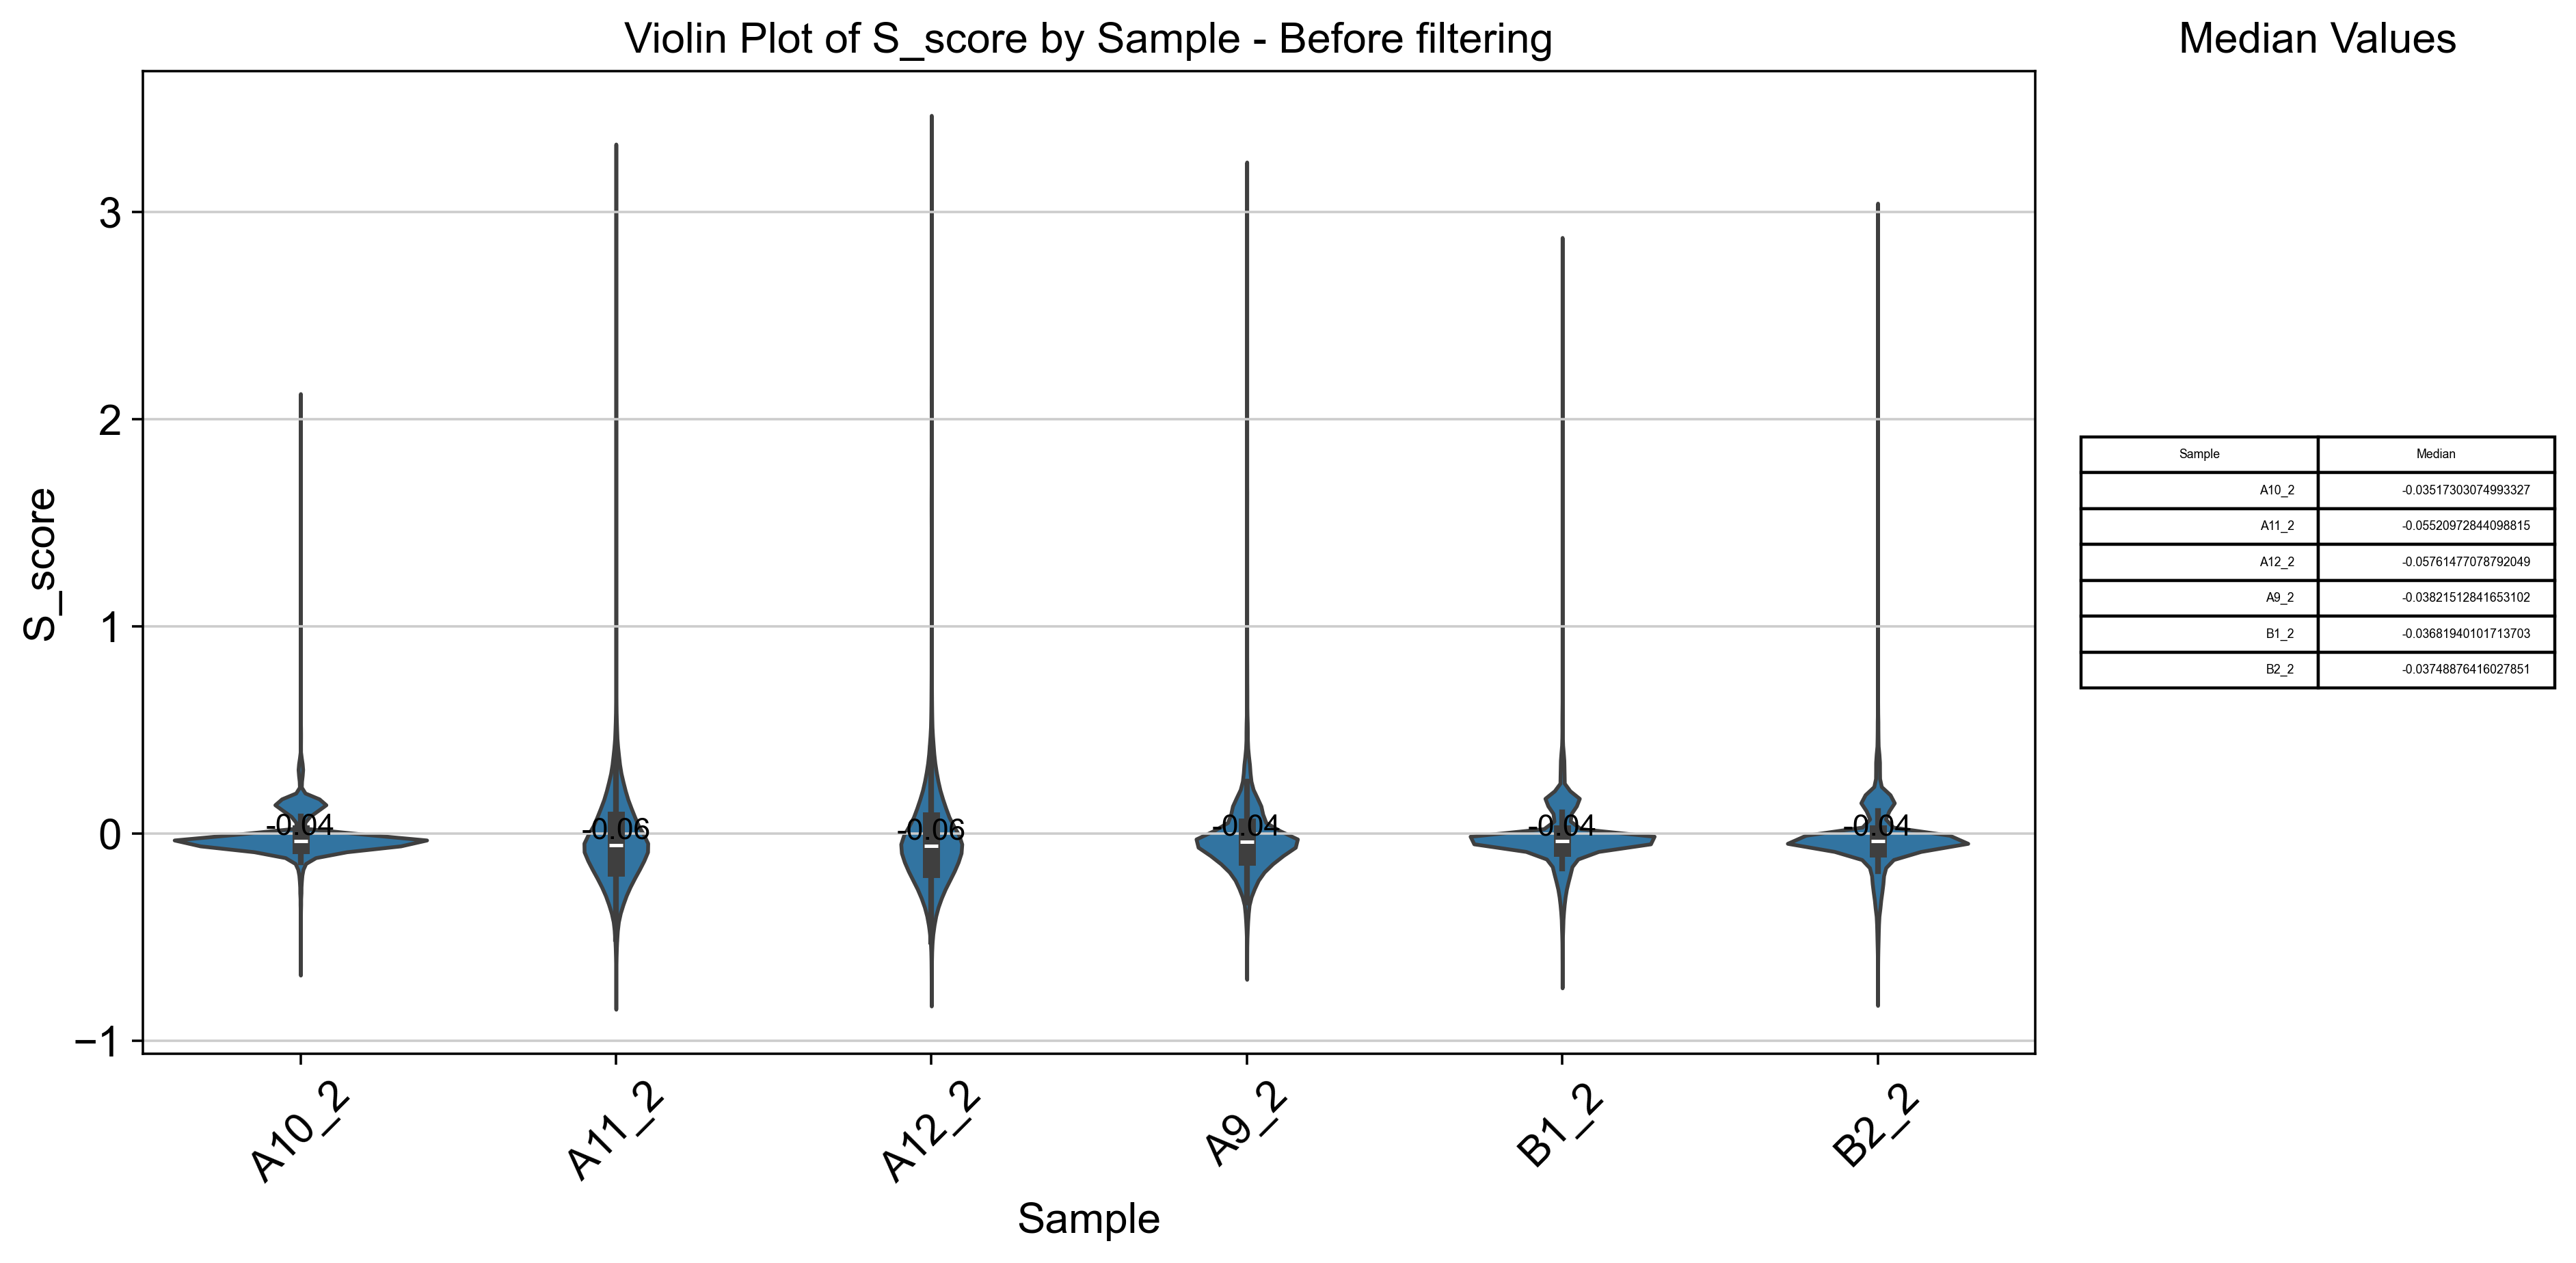

In [50]:
variables = 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 'doublet_scores', 'G2M_score', 'S_score'

for var in variables:

    fig, ax = plt.subplots(figsize=(12, 6), ncols=2, gridspec_kw={'width_ratios': [4, 1]})

    sb.violinplot(data=sample_object.obs, x='sample', y=var, ax=ax[0])
   
    medians = sample_object.obs.groupby('sample')[var].median()

    for sample, median in medians.items():
        ax[0].text(sample, median, f'{median:.2f}', ha='center', va='bottom', color='black', fontsize=10)
    
    ax[0].set_title(f'Violin Plot of {var} by Sample - Before filtering')
    ax[0].set_xlabel('Sample')
    ax[0].set_ylabel(var)
    ax[0].tick_params(axis='x', rotation=45)

    median_df = pd.DataFrame({'Sample': medians.index, 'Median': medians.values})

    ax[1].axis('off')
    ax[1].table(cellText=median_df.values, colLabels=median_df.columns, loc='center')
    ax[1].set_title('Median Values')
    
    plt.tight_layout()
    plt.show()


### Filtering based on QC metrics

In [51]:
sample_object = sample_object[sample_object.obs['n_genes'] > 600]
sample_object = sample_object[sample_object.obs['n_genes'] < 5000]

sample_object = sample_object[sample_object.obs['total_counts'] > 200]
sample_object = sample_object[sample_object.obs['total_counts'] < 15000]

sample_object = sample_object[sample_object.obs['pct_counts_mt'] < 60]
sample_object = sample_object[sample_object.obs['pct_counts_ribo'] < 20]

sample_object = sample_object[sample_object.obs['doublet_scores'] < 0.35]

sample_object

View of AnnData object with n_obs × n_vars = 46266 × 32285
    obs: 'sample', 'genotype', 'batch', 'n_genes', 'doublet_scores', 'predicted_doublets', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts_per_cell', 'percent_chrY', 'XIST-counts', 'XIST-percentage', 'gender_check_cov', 'S_score', 'G2M_score', 'phase'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'sample_colors'

/var/folders/m6/j4jl72rj0pl7_bbwngtxl9ym0000gn/T/ipykernel_55926/575484018.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  medians = sample_object.obs.groupby('sample')[var].median()


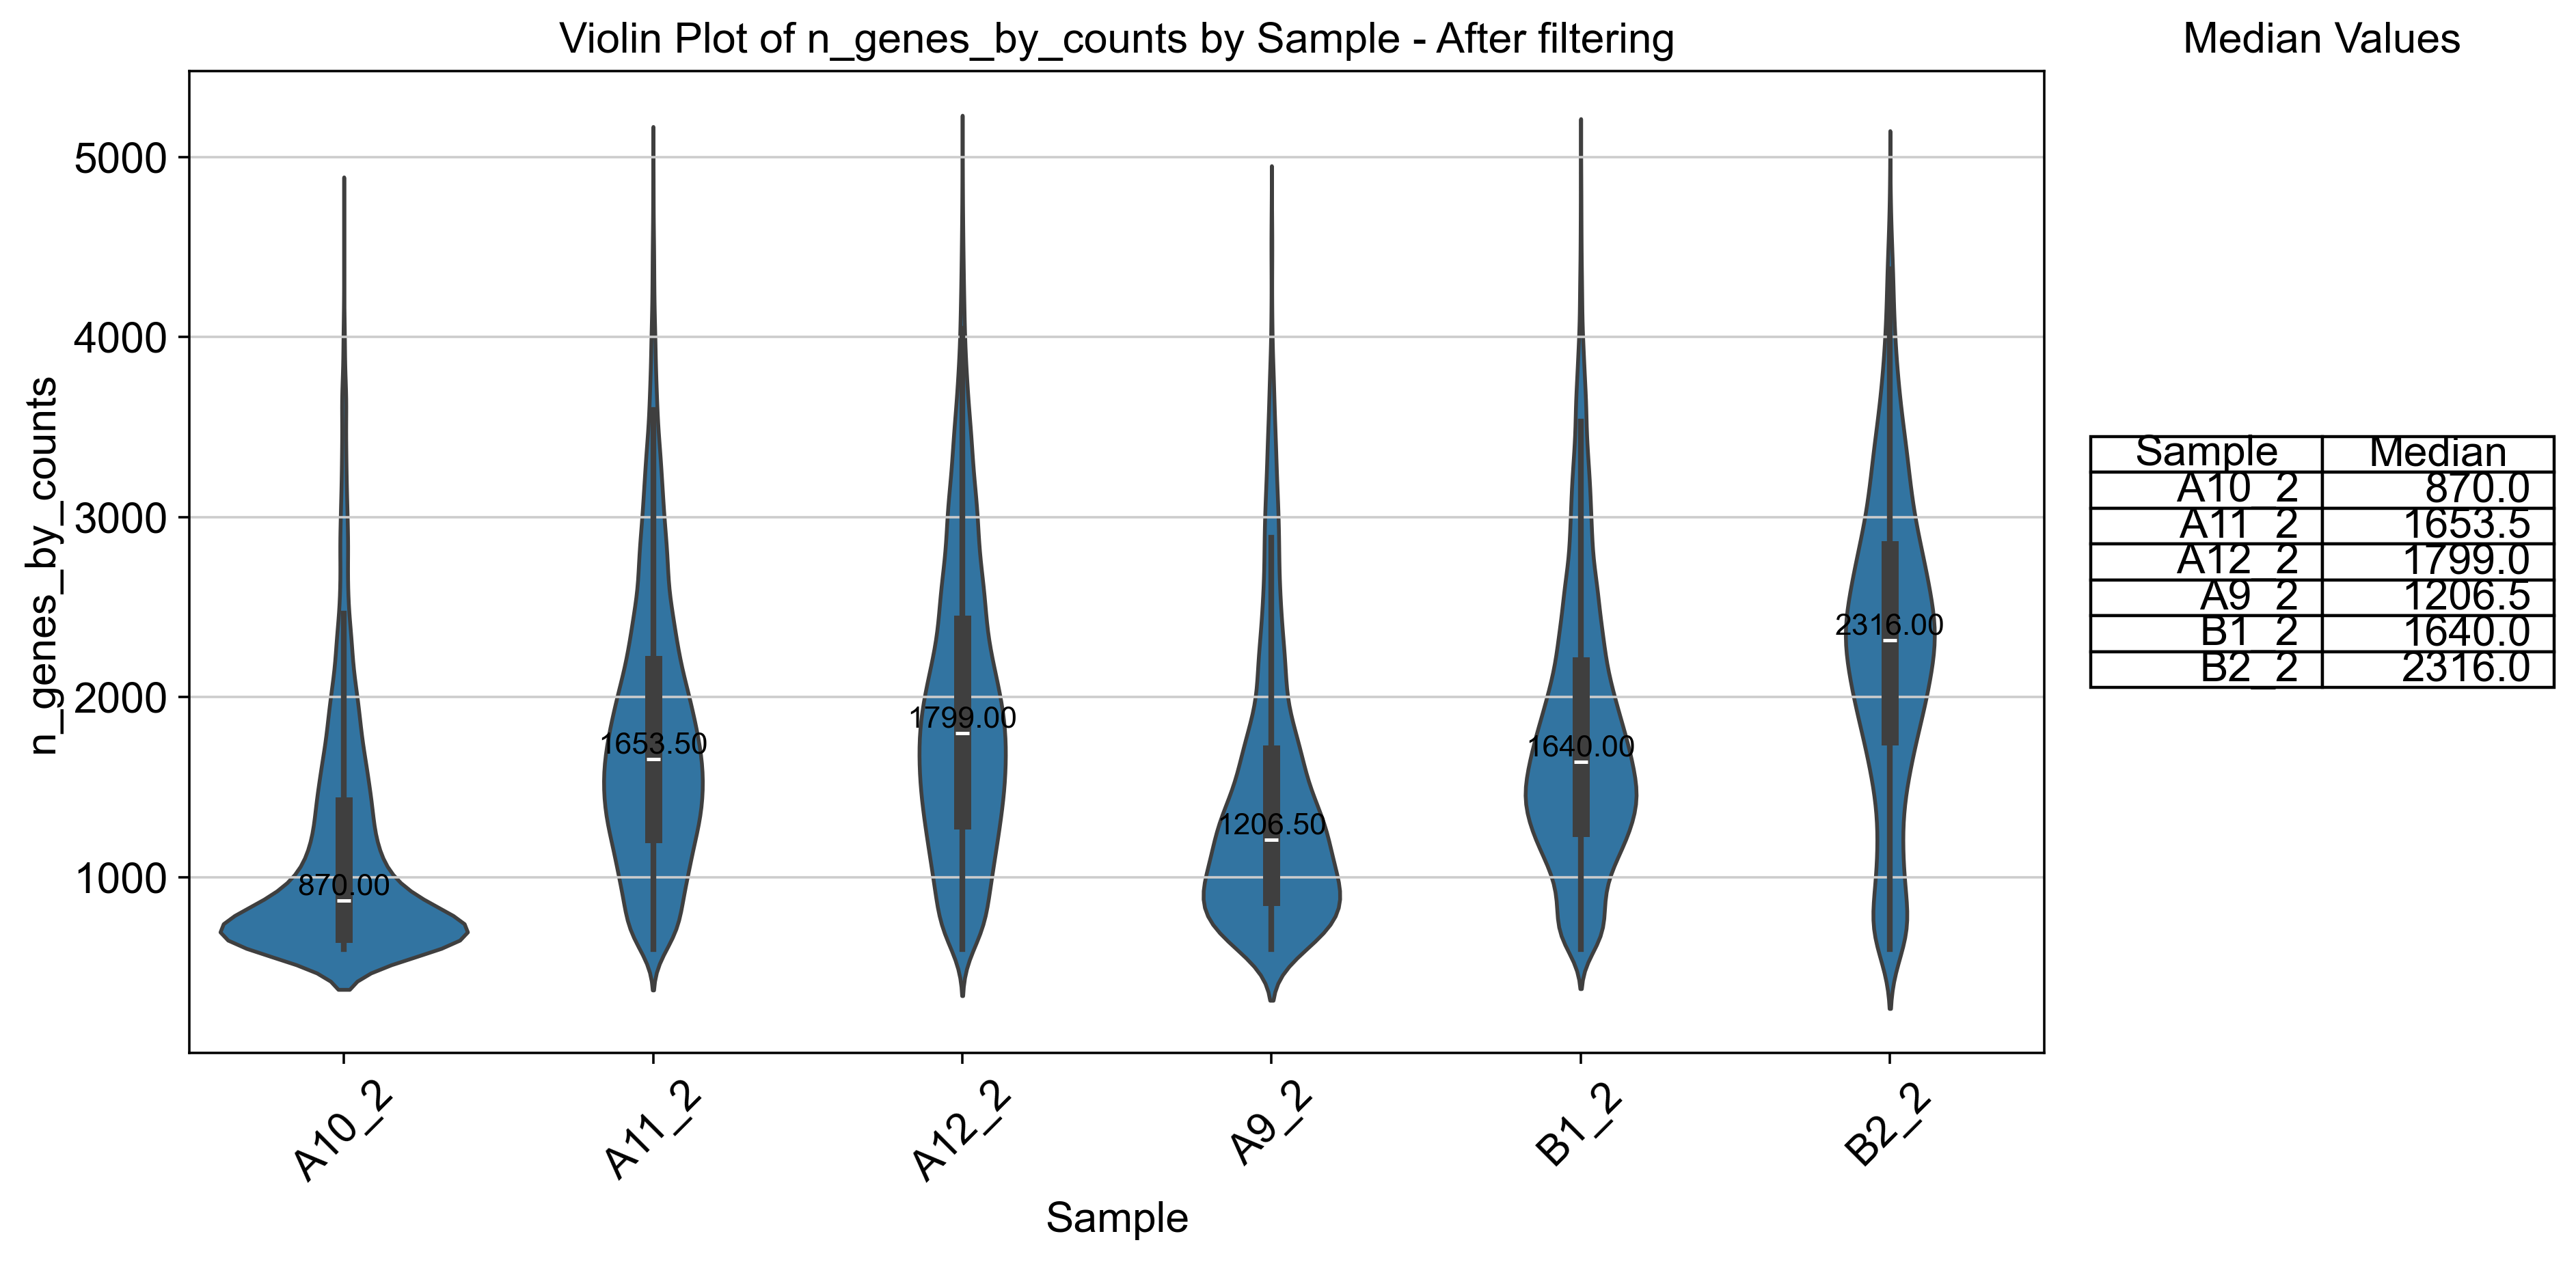

/var/folders/m6/j4jl72rj0pl7_bbwngtxl9ym0000gn/T/ipykernel_55926/575484018.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  medians = sample_object.obs.groupby('sample')[var].median()


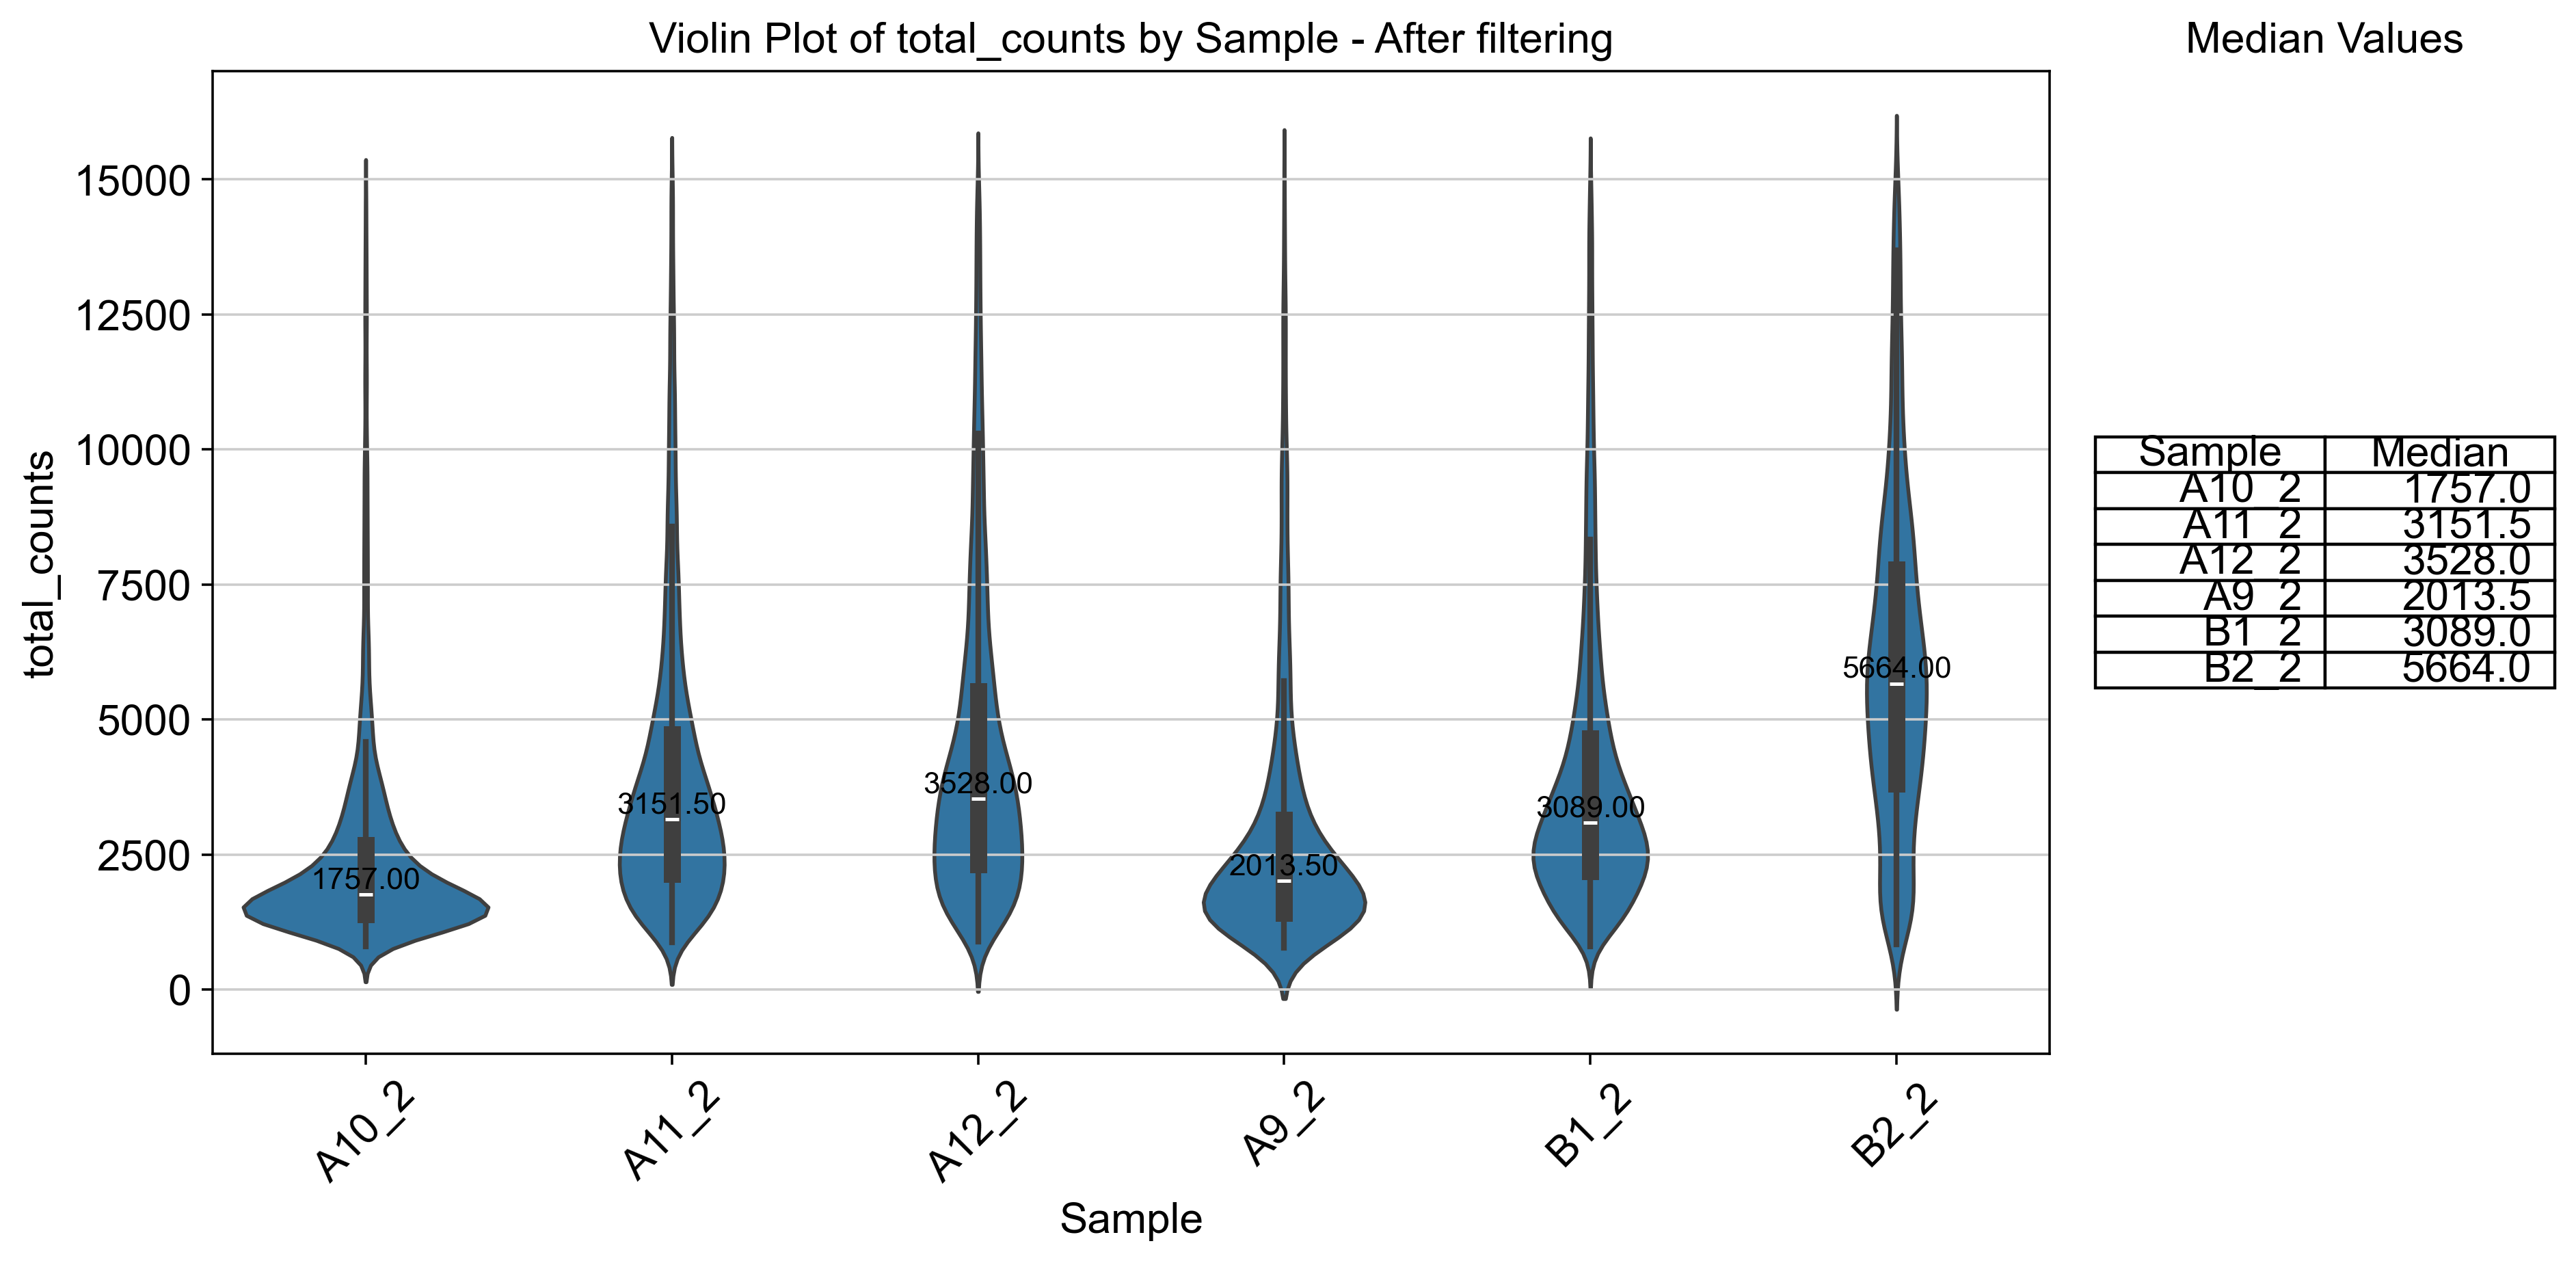

/var/folders/m6/j4jl72rj0pl7_bbwngtxl9ym0000gn/T/ipykernel_55926/575484018.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  medians = sample_object.obs.groupby('sample')[var].median()


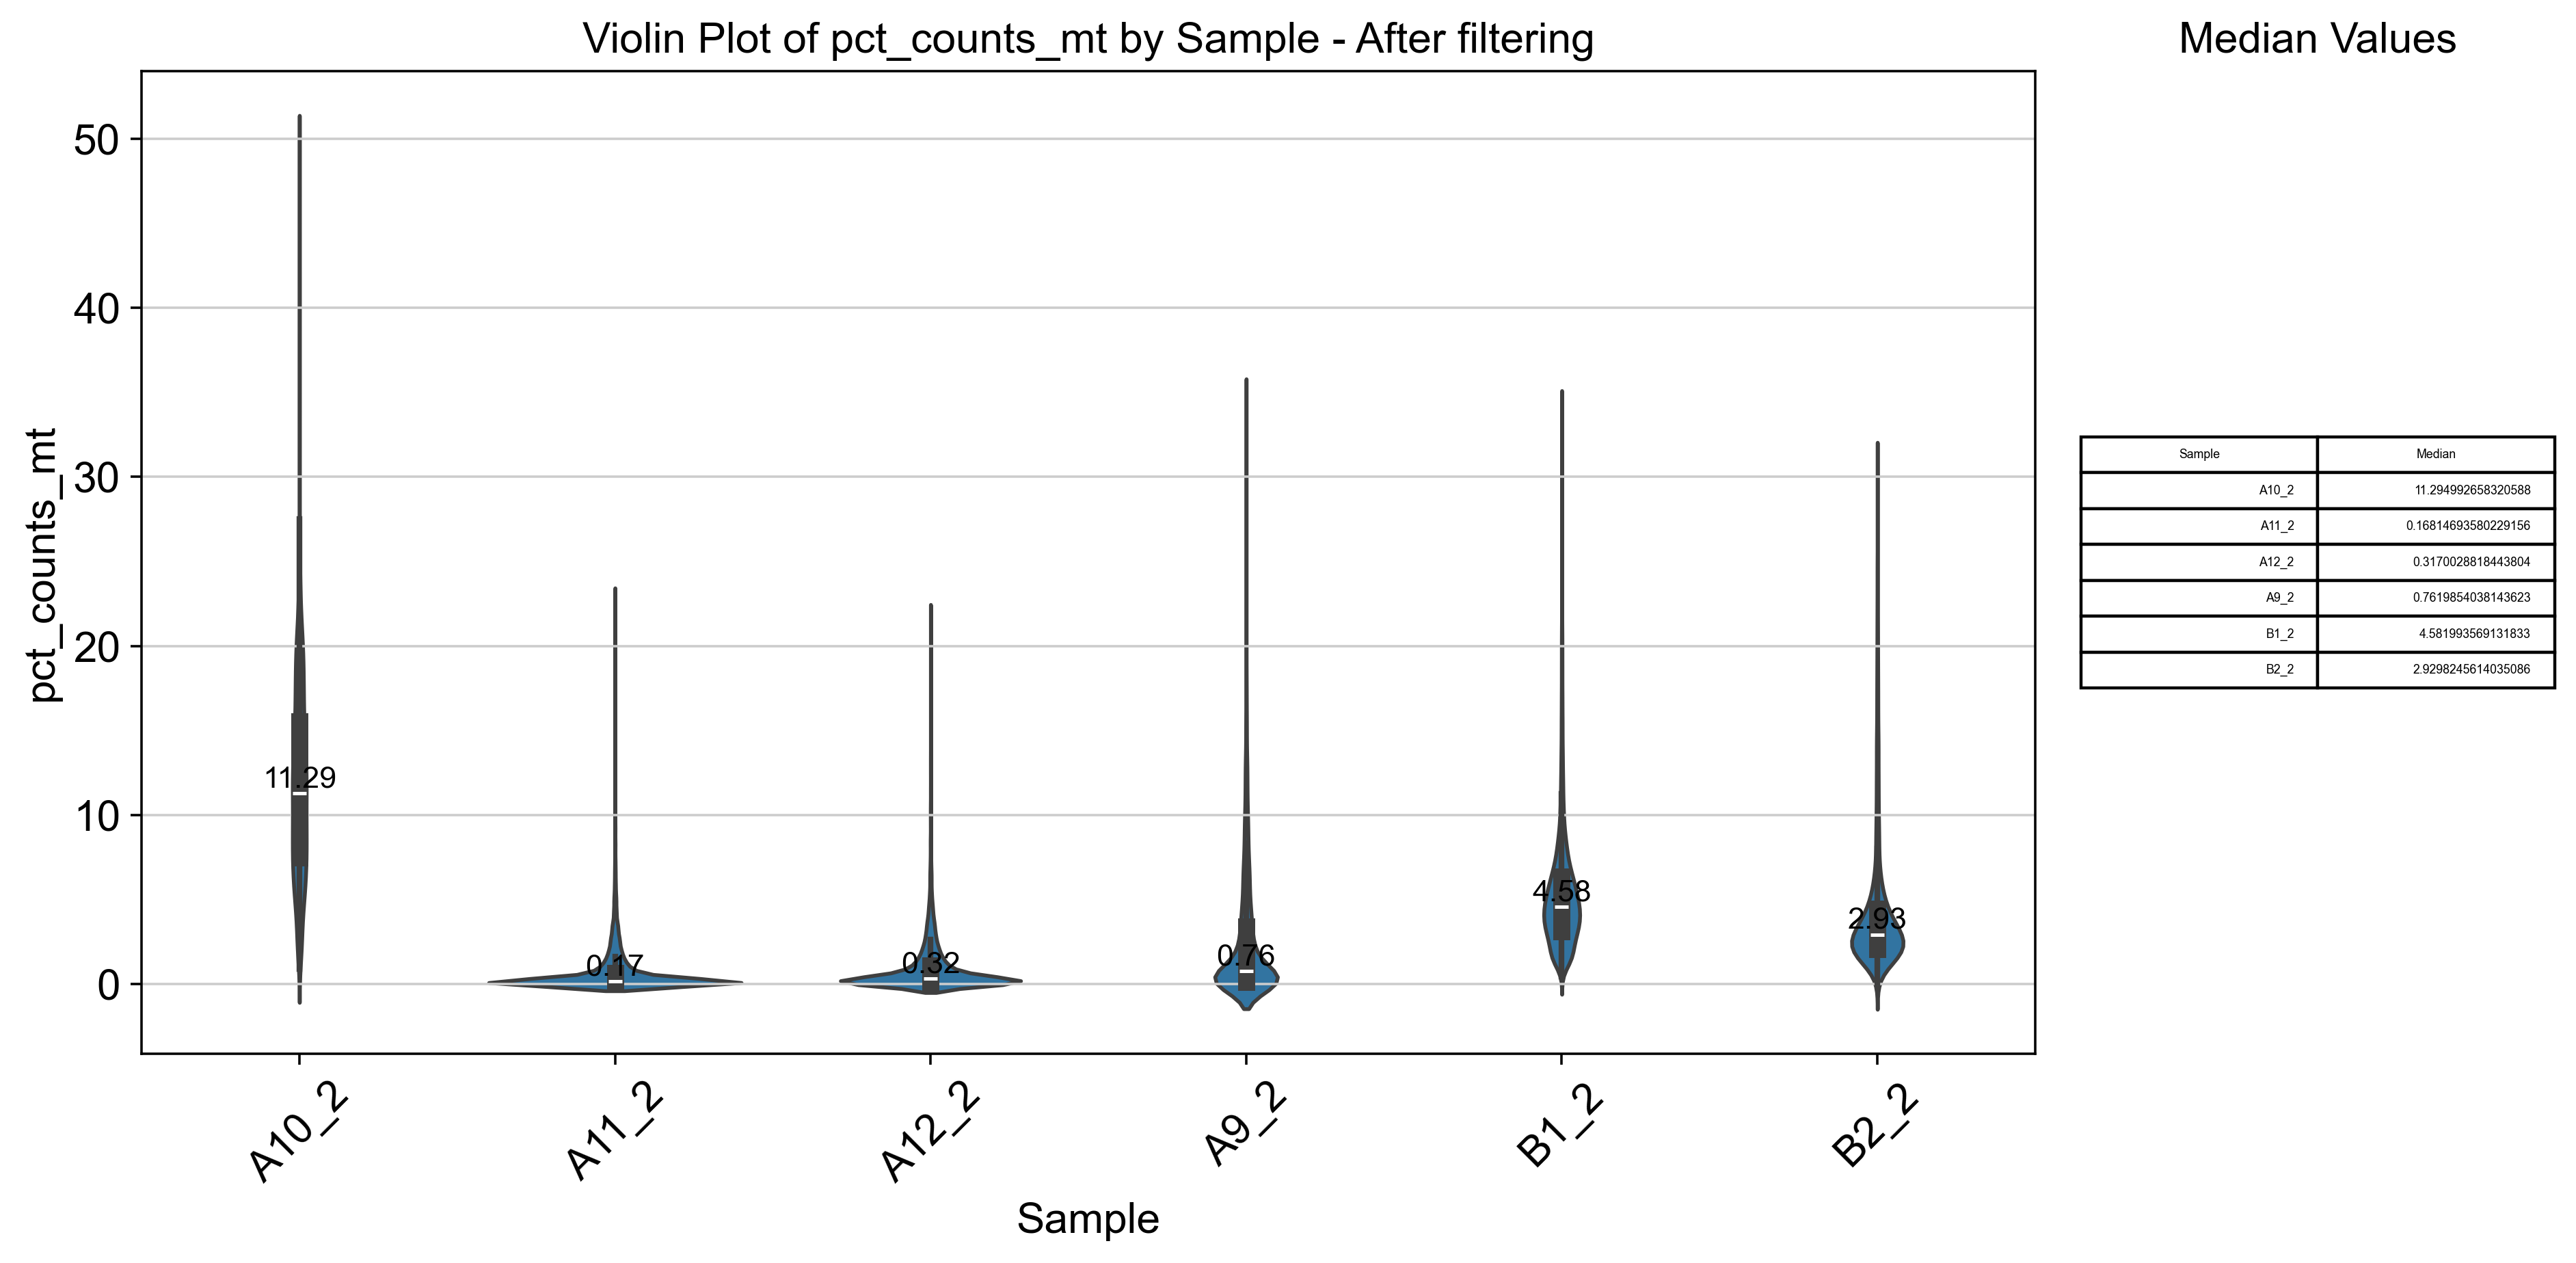

/var/folders/m6/j4jl72rj0pl7_bbwngtxl9ym0000gn/T/ipykernel_55926/575484018.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  medians = sample_object.obs.groupby('sample')[var].median()


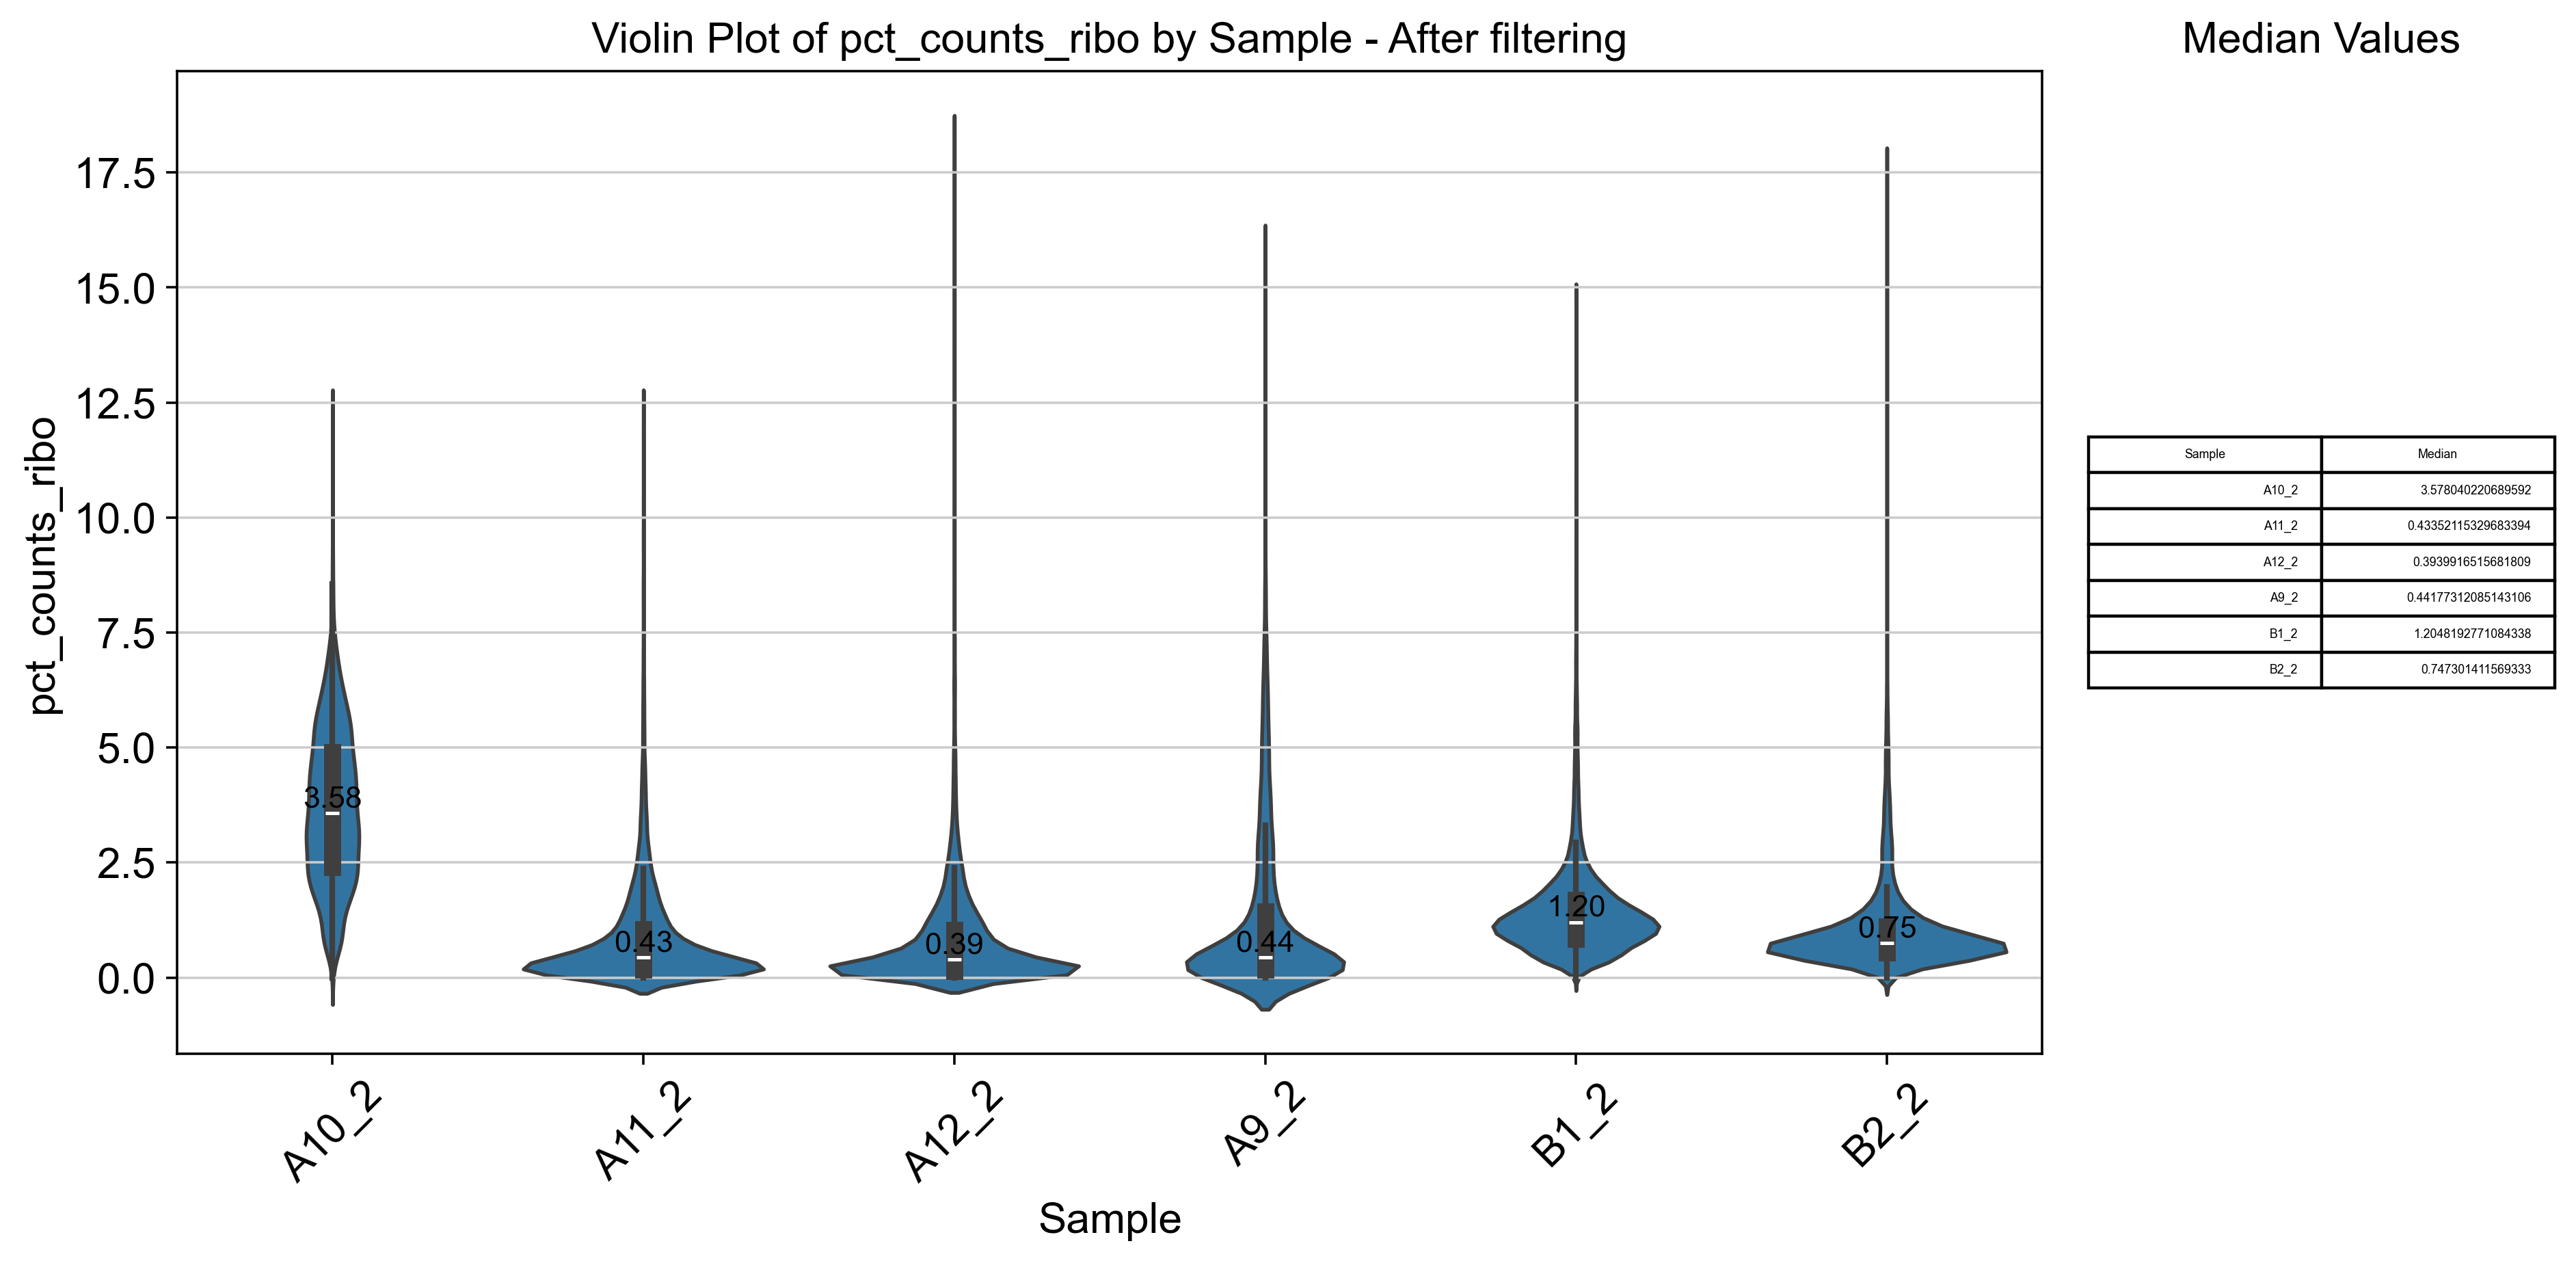

/var/folders/m6/j4jl72rj0pl7_bbwngtxl9ym0000gn/T/ipykernel_55926/575484018.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  medians = sample_object.obs.groupby('sample')[var].median()


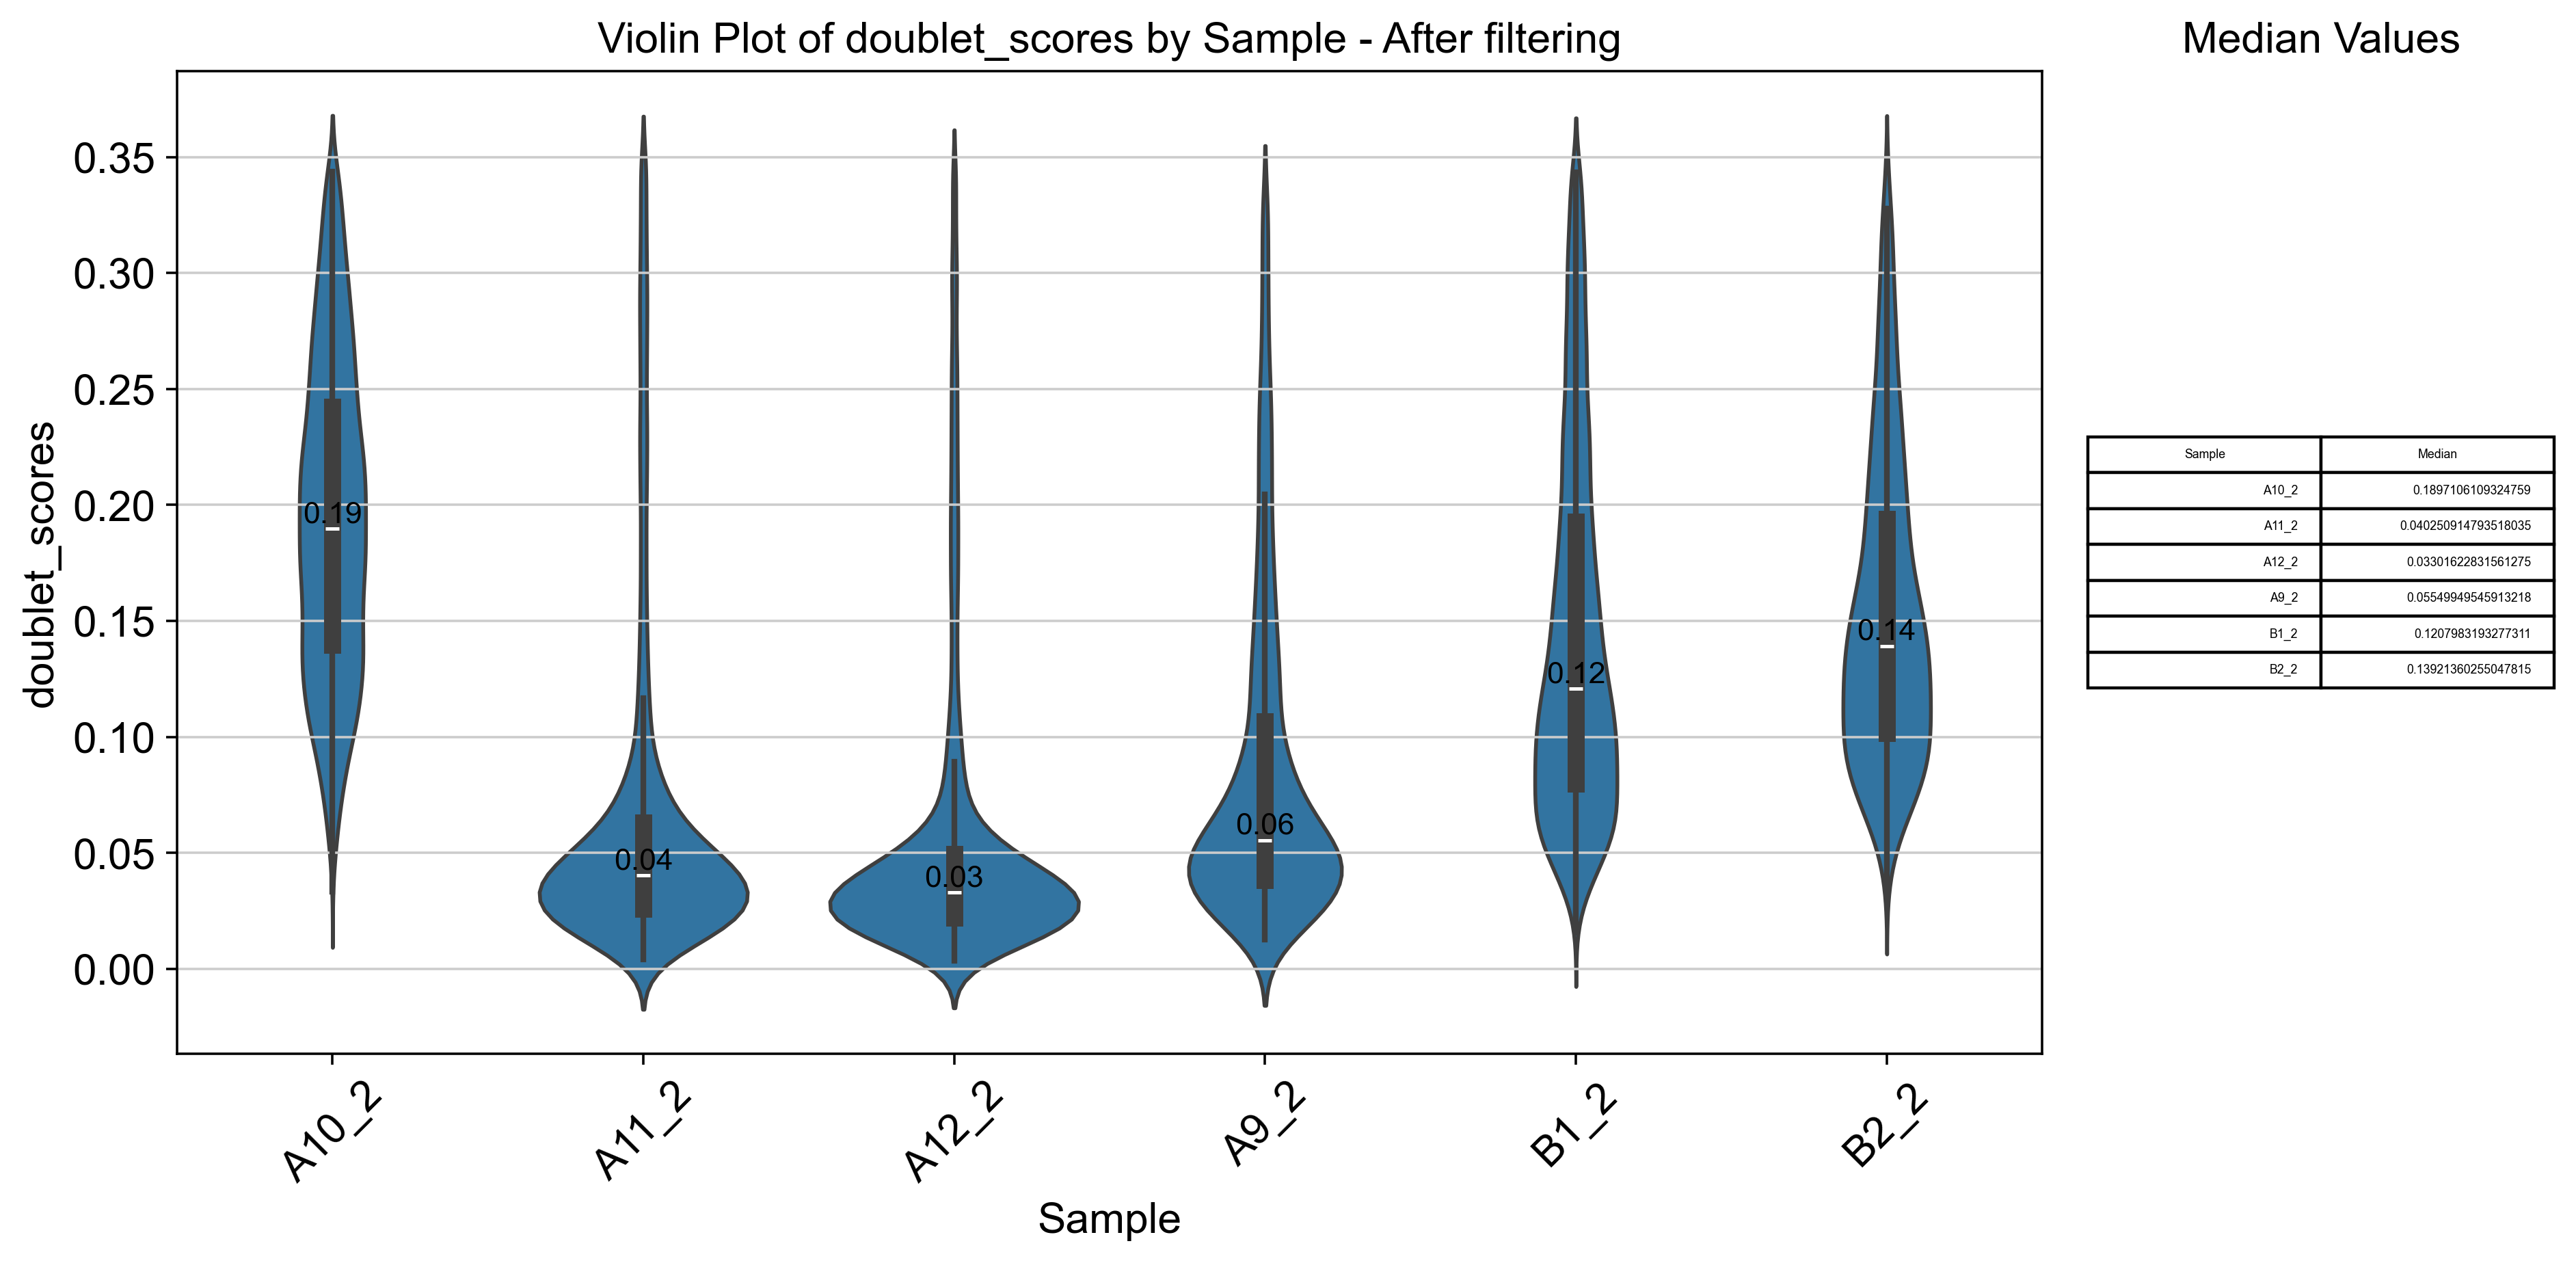

/var/folders/m6/j4jl72rj0pl7_bbwngtxl9ym0000gn/T/ipykernel_55926/575484018.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  medians = sample_object.obs.groupby('sample')[var].median()


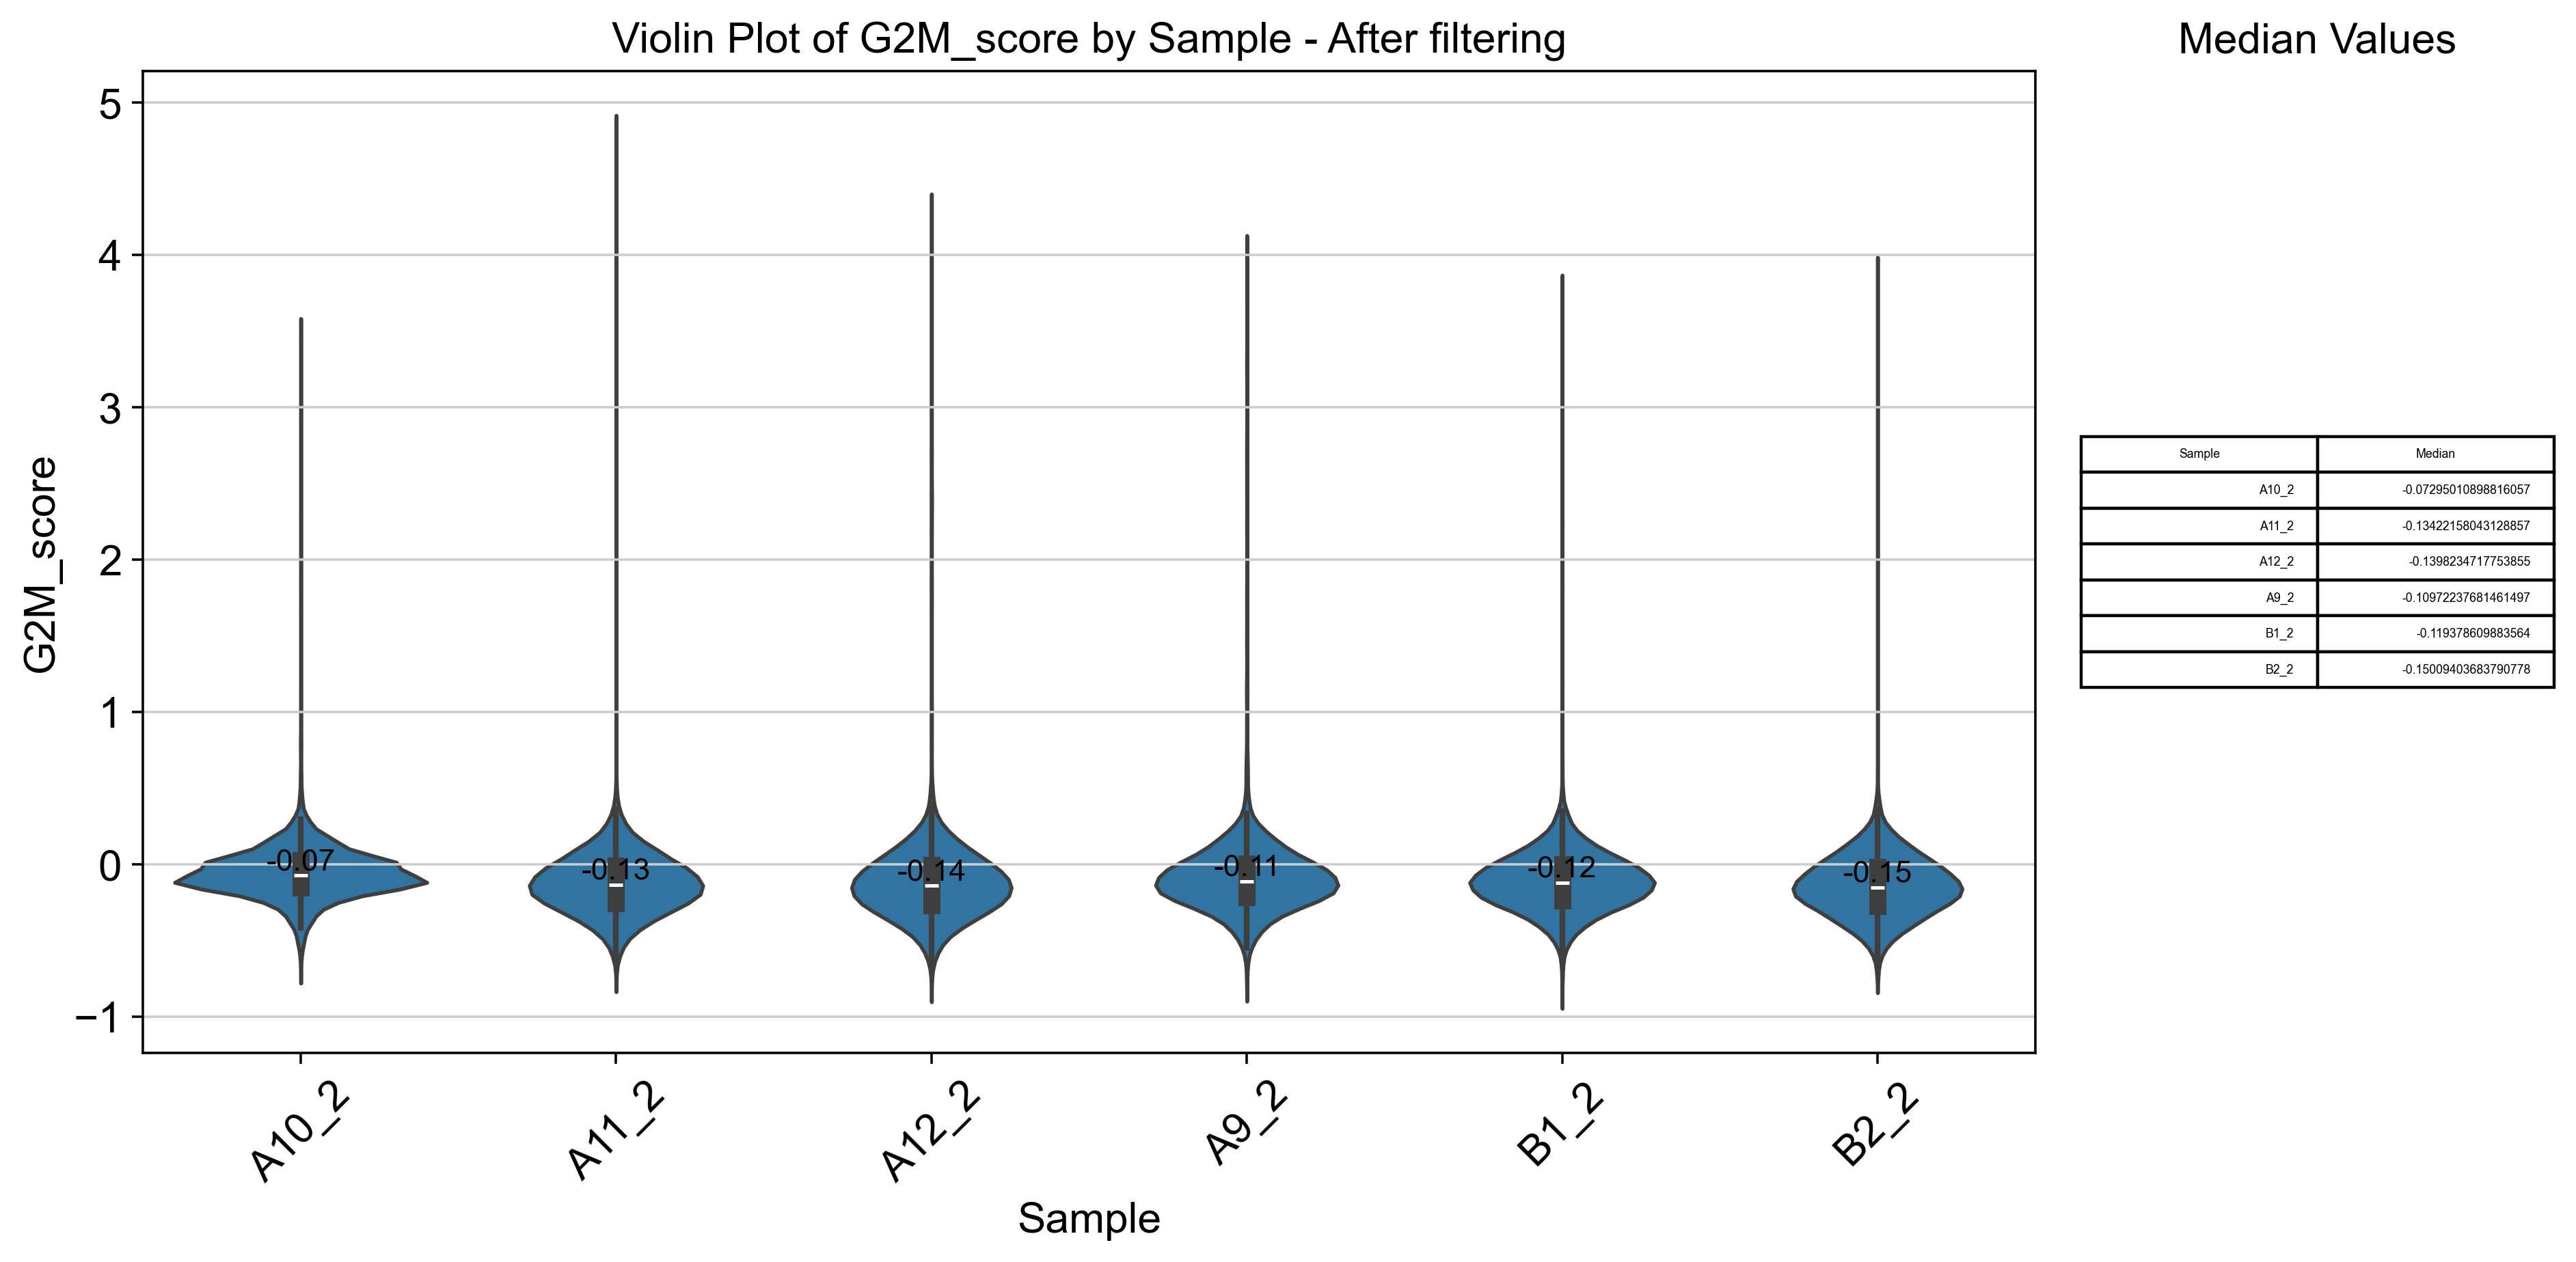

/var/folders/m6/j4jl72rj0pl7_bbwngtxl9ym0000gn/T/ipykernel_55926/575484018.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  medians = sample_object.obs.groupby('sample')[var].median()


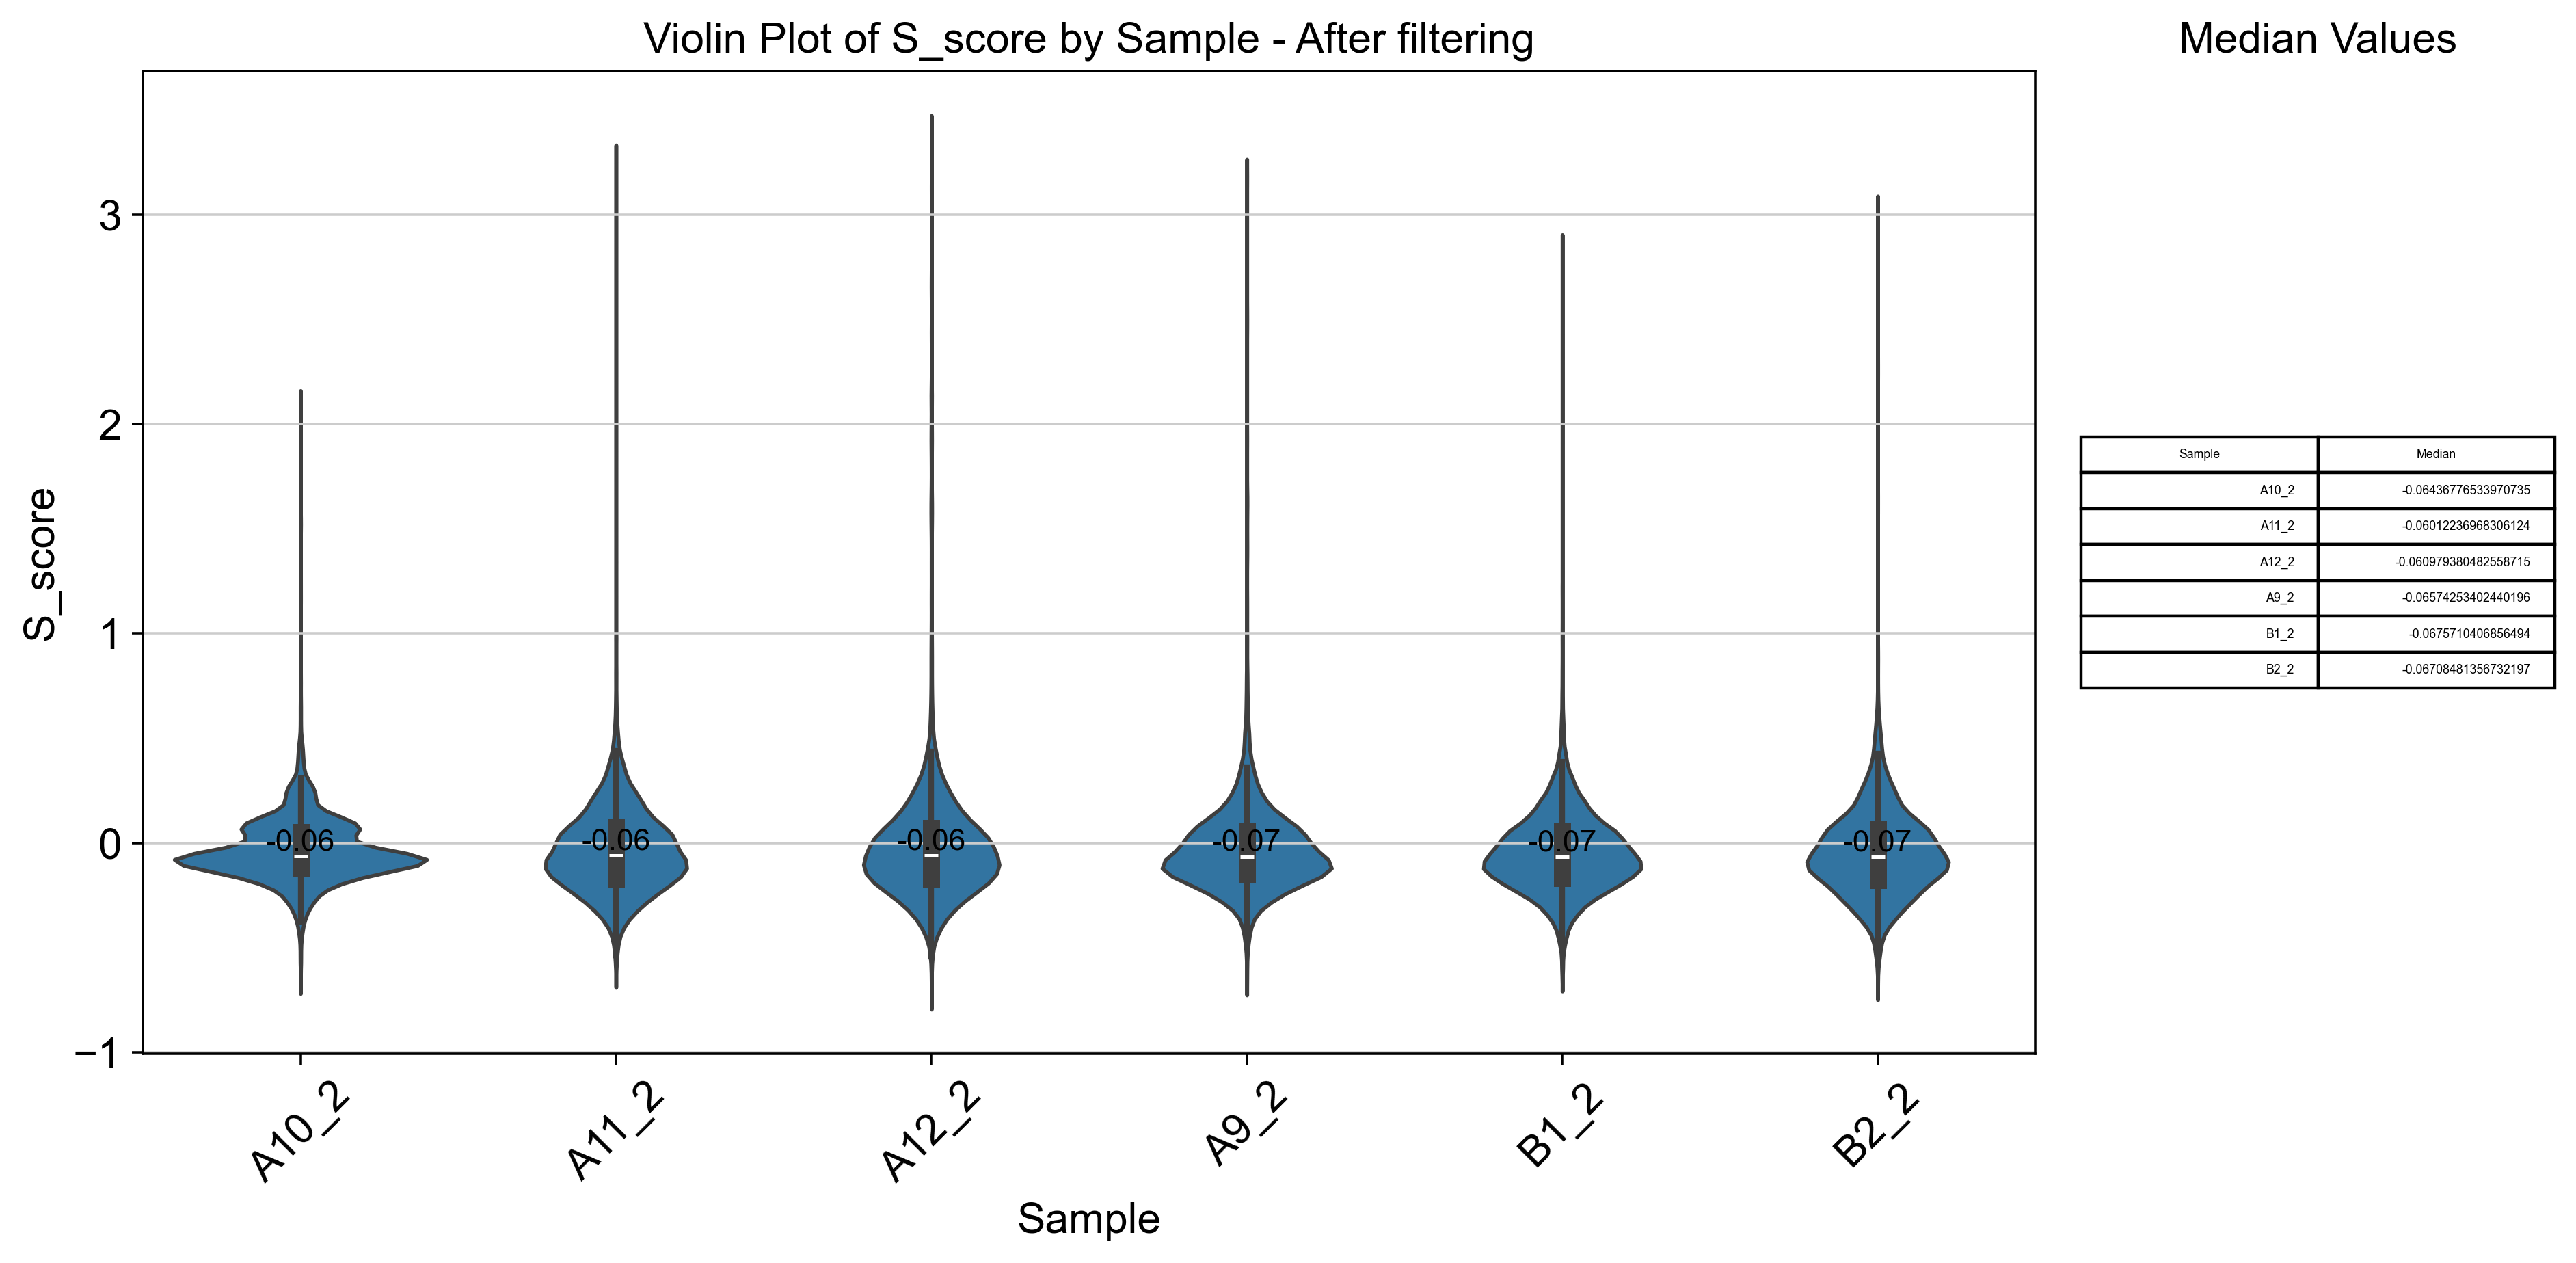

In [52]:
variables = 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 'doublet_scores', 'G2M_score', 'S_score' 

for var in variables:

    fig, ax = plt.subplots(figsize=(12, 6), ncols=2, gridspec_kw={'width_ratios': [4, 1]})

    sb.violinplot(data=sample_object.obs, x='sample', y=var, ax=ax[0])
   
    medians = sample_object.obs.groupby('sample')[var].median()

    for sample, median in medians.items():
        ax[0].text(sample, median, f'{median:.2f}', ha='center', va='bottom', color='black', fontsize=10)
    
    ax[0].set_title(f'Violin Plot of {var} by Sample - After filtering')
    ax[0].set_xlabel('Sample')
    ax[0].set_ylabel(var)
    ax[0].tick_params(axis='x', rotation=45)

    median_df = pd.DataFrame({'Sample': medians.index, 'Median': medians.values})

    ax[1].axis('off')
    ax[1].table(cellText=median_df.values, colLabels=median_df.columns, loc='center')
    ax[1].set_title('Median Values')
    
    plt.tight_layout()
    plt.show()

## Data normalization

#### Steps followed

1. Creating a copy 
2. Saving counts as a layer without normalization
3. Normalizing cells and squaring them to root to stabilize

In [53]:
sample_object.raw = sample_object.copy()

sample_object.layers['counts'] = sample_object.X.copy()

sample_object.layers["sqrt_norm"] = np.sqrt(
    sc.pp.normalize_total(sample_object, inplace = False)["X"]
)

sample_object

normalizing counts per cell
    finished (0:00:00)


AnnData object with n_obs × n_vars = 46266 × 32285
    obs: 'sample', 'genotype', 'batch', 'n_genes', 'doublet_scores', 'predicted_doublets', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts_per_cell', 'percent_chrY', 'XIST-counts', 'XIST-percentage', 'gender_check_cov', 'S_score', 'G2M_score', 'phase'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'sample_colors'
    layers: 'counts', 'sqrt_norm'

## Data Export

In [54]:
sample_object.obs.dtypes

sample                category
genotype              category
batch                 category
n_genes                  int64
doublet_scores         float64
predicted_doublets      object
n_genes_by_counts        int32
total_counts           float64
total_counts_mt        float64
pct_counts_mt          float64
total_counts_ribo      float64
pct_counts_ribo        float64
percent_mt2            float64
n_counts_per_cell      float64
percent_chrY           float64
XIST-counts            float64
XIST-percentage        float64
gender_check_cov        object
S_score                float64
G2M_score              float64
phase                   object
dtype: object

In [55]:
sample_object.obs['predicted_doublets'] = sample_object.obs['predicted_doublets'].astype('category')

In [60]:
sample_object.write(path + f'heart_mm_nuclei-23-0092_CB_QCed_ctl231123_{timestamp}.raw.h5ad')